En resumen: Es el requisito de infraestructura que permite que el código acceda a la materia prima del proyecto.

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


En resumen: Este bloque importa el kit completo de herramientas (procesamiento, construcción y control) necesarias para implementar, entrenar y evaluar una arquitectura de segmentación semántica de alta complejidad.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings, glob, os
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Dropout, MaxPool2D, concatenate, BatchNormalization, LeakyReLU, Reshape, Add, Multiply, GlobalAveragePooling2D
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

En resumen: Estas variables son el mapa de ruta para que el código pueda localizar y cargar la base de datos de 1000 imágenes y máscaras, permitiendo el preprocesamiento posterior.

In [4]:
images_path = '/content/drive/MyDrive/ProyectoIA/png_images/IMAGES'
masks_path = '/content/drive/MyDrive/ProyectoIA/png_masks/MASKS'

"Este código es esencial para la logística de datos. Generamos dos listas de rutas (image_files y mask_files) y, al usar sorted(), garantizamos que la imagen en la posición $i$ de la primera lista se corresponda con la máscara en la posición $i$ de la segunda lista. Esto es el pilar para la división y el entrenamiento supervisado."

In [5]:
image_files = sorted(glob.glob(os.path.join(images_path,"*.png")))
mask_files = sorted(glob.glob(os.path.join(masks_path,"*.png")))

In [6]:
len(image_files), len(mask_files)

(1000, 1000)

In [7]:
image_basename_to_path = {os.path.basename(f): f for f in image_files}
mask_basename_to_path = {os.path.basename(f): f for f in mask_files}

In [8]:
image_keys = {os.path.splitext(f)[0].split('_')[1] for f in image_basename_to_path.keys()}
mask_keys = {os.path.splitext(f)[0].split('_')[1] for f in mask_basename_to_path.keys()}

In [9]:
common_keys = image_keys & mask_keys

image_paths = [image_basename_to_path[f"img_{k}.png"] for k in common_keys]
mask_paths = [mask_basename_to_path[f"seg_{k}.png"] for k in common_keys]

In [10]:
len(image_paths), len(mask_paths)

(1000, 1000)

## DIVISION DE ENTRENAMIENTO PRUEBA Y VALIDACION

Introducción: Se realiza la división formal del conjunto de datos para garantizar una evaluación objetiva del modelo.

Qué hace: Divide el total de 1000 pares de imágenes y máscaras en tres subconjuntos, utilizando dos llamadas a train_test_split:

Entrenamiento y Prueba (80% / 20%): Separa 200 pares para el conjunto de Prueba (Test), que se usará para la evaluación final y no se tocará durante el entrenamiento.

Entrenamiento y Validación (90% / 10% del 80% restante): Del conjunto inicial de entrenamiento (800 pares), separa un 10% (80 pares) para el conjunto de Validación (Val).

¿Por qué fue necesario? Esta división es el estándar en Deep Learning:

Entrenamiento (720): Para ajustar los pesos del modelo.

Validación (80): Para monitorear el rendimiento durante el entrenamiento y detectar sobreajuste (overfitting) en tiempo real.

Prueba (200): Para la evaluación final y no sesgada de la capacidad de generalización del modelo. El random_state=101 garantiza la reproducibilidad de la división.

In [11]:
train_images, test_images, train_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=101, shuffle=True
)

train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.1, random_state=101
)

In [12]:
print("Train:", len(train_images))
print("Test:", len(test_images))
print("Val:", len(val_images))

Train: 720
Test: 200
Val: 80


Introducción: Se define la cardinalidad y el significado de las etiquetas que el modelo debe segmentar.

Qué hace: Carga el archivo labels.csv y extrae la cantidad total de categorías de objetos a predecir, asignando el valor de 59 a la variable num_classes.

¿Por qué fue necesario? En el problema de segmentación semántica, cada píxel se clasifica en una categoría. El valor de num_classes es una restricción arquitectónica fundamental: el último canal de salida de la U-Net (la capa de Conv2D con activación softmax) debe tener exactamente 59 filtros para producir una probabilidad para cada una de las 59 clases en cada píxel.

In [13]:
labels = pd.read_csv('/content/drive/MyDrive/ProyectoIA/labels.csv')
num_classes = len(labels.label_list)
num_classes

59

In [14]:
labels_list = labels.label_list.tolist()
print(labels_list)

[nan, 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace', 'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']


## Preprocesamiento de pares imagen-máscara y creación de conjuntos de datos

Introducción: Se implementa el proceso de estandarización de los datos para la entrada del modelo.

Qué hace: Esta función, mapeada a cada par de archivos, realiza:

Lectura y Redimensión a 128x128: Tanto imágenes (3 canales RGB) como máscaras (1 canal con la etiqueta de clase) se cargan y se les aplica un redimensionamiento para cumplir con la input_shape esperada por la U-Net (128x128).

Normalización de Imágenes: Los píxeles se convierten a float32 y se dividen por 255, dejando los valores en el rango [0, 1].

Redimensión de Máscaras con method='nearest': Se usa el método de vecino más cercano para redimensionar las máscaras.

¿Por qué fue necesario?

Estandarización: La red U-Net requiere un tamaño de entrada fijo (128x128).

Integridad de la Máscara: El uso de nearest en las máscaras es vital. Si se usara interpolación (como en las imágenes), se crearían valores fraccionarios en los píxeles, mezclando clases y destruyendo la información de la etiqueta de clase discreta que necesita el modelo para el cálculo de la pérdida.

Normalización: Mejora la estabilidad y velocidad de la convergencia del entrenamiento.

In [15]:
def load_image_mask_pairs(image_paths, mask_paths):
    images = tf.io.read_file(image_paths)
    images = tf.image.decode_png(images,channels=3)
    images = tf.image.resize(images, (128,128))
    images = tf.cast(images, tf.float32)
    images = images / 255.

    masks = tf.io.read_file(mask_paths)
    masks = tf.image.decode_png(masks,channels=1)
    masks = tf.image.resize(masks, (128,128), method='nearest')
    masks = tf.cast(masks, tf.int32)

    return images, masks

Introducción: Define una función para aplicar transformaciones aleatorias a las imágenes.

Qué hace: Aplica transformaciones en el espacio de color (brillo, contraste, saturación y matiz) a la imagen de entrada. El valor de la imagen final se recorta entre 0 y 1 para mantener la normalización.

¿Por qué fue necesario? Esto se conoce como aumento de datos (data augmentation). Es necesario para:

Aumentar la Robustez: Entrena el modelo para que las segmentaciones sean correctas incluso bajo variaciones de iluminación, sombras o coloración en las imágenes de entrada.

Combatir el Overfitting: Genera más datos de entrenamiento sintéticos (aunque realistas), reduciendo la probabilidad de que el modelo memorice el conjunto de entrenamiento. Importante: La máscara no se modifica, ya que las transformaciones de color no afectan las áreas de segmentación .

In [16]:
def data_augmentation(image, mask):
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.95, upper=1.05)
    image = tf.image.random_hue(image, max_delta=0.02)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, mask

Introducción: Se define la tubería (pipeline) de datos de alto rendimiento de TensorFlow.

Qué hace: Combina las funciones de preprocesamiento (load_image_mask_pairs) y aumento de datos (data_augmentation) con métodos de optimización de I/O para crear los tres conjuntos finales (train_dataset, test_dataset, val_dataset):

map(): Aplica las funciones de preprocesamiento y aumento de datos en paralelo (num_parallel_calls=tf.data.AUTOTUNE).

shuffle(100): Mezcla el orden de los datos en el pipeline.

batch(batch_size=32): Agrupa los datos en lotes para que el modelo pueda procesarlos en paralelo.

prefetch(tf.data.AUTOTUNE): Optimiza la carga para que la CPU esté leyendo el siguiente lote de datos mientras el GPU/TPU entrena con el lote actual.

¿Por qué fue necesario? Eficiencia y rendimiento. La carga de datos en una GPU es a menudo el cuello de botella más grande. El uso del API tf.data y prefetch asegura que el modelo se alimente de datos a la máxima velocidad posible, maximizando el uso del hardware y acelerando el entrenamiento.

In [17]:
def get_dataset(image_paths, mask_paths, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image_mask_pairs, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda x, y: data_augmentation(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [18]:
train_dataset = get_dataset(train_images, train_masks)
test_dataset = get_dataset(test_images, test_masks)
val_dataset = get_dataset(val_images, val_masks)

## Visualización de una muestra de un conjunto de datos de entrenamiento: imágenes y máscaras

Introducción: Esta función es una herramienta de diagnóstico visual que permite realizar una inspección inmediata de los resultados de la segmentación.

Qué hace:

Toma una lista de tensores (images), que típicamente contiene: la imagen de entrada, la máscara de verdad fundamental (ground truth) y la máscara predicha por el modelo.

Configura una figura con subgráficos (plt.subplot) para mostrar los tres elementos uno al lado del otro.

Distingue el tipo de dato: Utiliza la condición if img.shape[-1] == 1: para determinar si el tensor es una máscara (un solo canal, que contiene el índice de clase por píxel) o una imagen RGB (tres canales).

Manejo de Canales:

Si es una máscara (1 canal), usa tf.squeeze(img) para eliminar el eje innecesario y la muestra en escala de grises o con un mapa de colores simple.

Si es una imagen (3 canales), usa array_to_img(img) para convertir el tensor en una imagen RGB visible.

Desactiva los ejes (plt.axis('off')) para una visualización limpia, enfocada en el contenido.

¿Por qué fue necesario?

Sanity Check (Verificación Inicial): Permite confirmar visualmente que el proceso de pipeline de datos (lectura de archivos, emparejamiento, redimensionamiento y preprocesamiento de imágenes y máscaras) se ejecutó correctamente.

Evaluación Cualitativa: Es indispensable para la defensa del proyecto, ya que proporciona una evidencia inmediata y comprensible de la capacidad del modelo para:

Localizar: ¿El modelo predice las áreas correctas?

Precisar: ¿Los límites de la segmentación coinciden con los del objeto real (Máscara Verdadera)?

Debugging: Al comparar la Imagen de Entrada, la Máscara Verdadera, y la Máscara Predicha, se puede identificar rápidamente si el modelo está fallando en casos específicos (e.g., objetos pequeños o límites difusos), guiando futuros ajustes de arquitectura o hiperparámetros.

In [19]:
def display_sample(images):
    plt.figure(figsize=(5 * len(images), 5))
    titles = ['Input Image', 'True Mask', 'Predicted Mask']

    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.title(titles[i])
        # If mask (single channel), display in grayscale
        if img.shape[-1] == 1:
            plt.imshow(tf.squeeze(img))
        else:
            plt.imshow(array_to_img(img))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

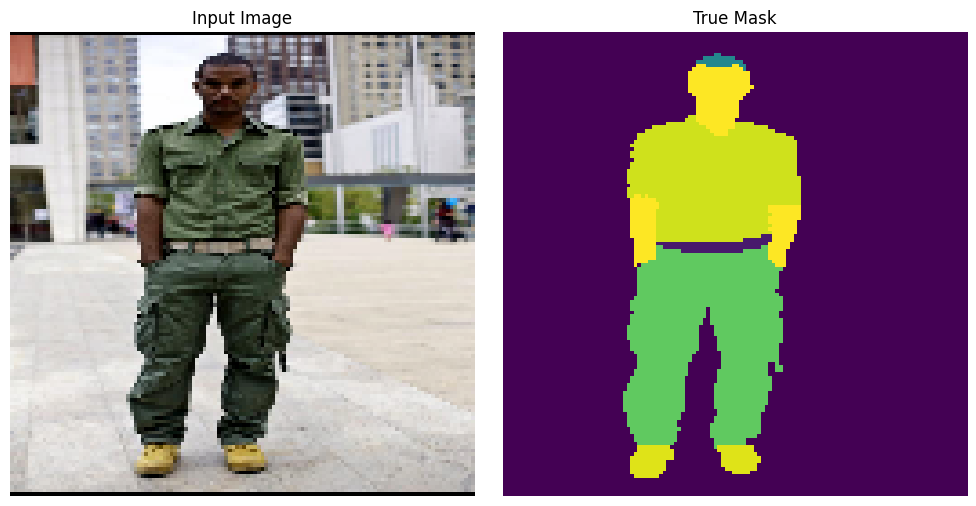

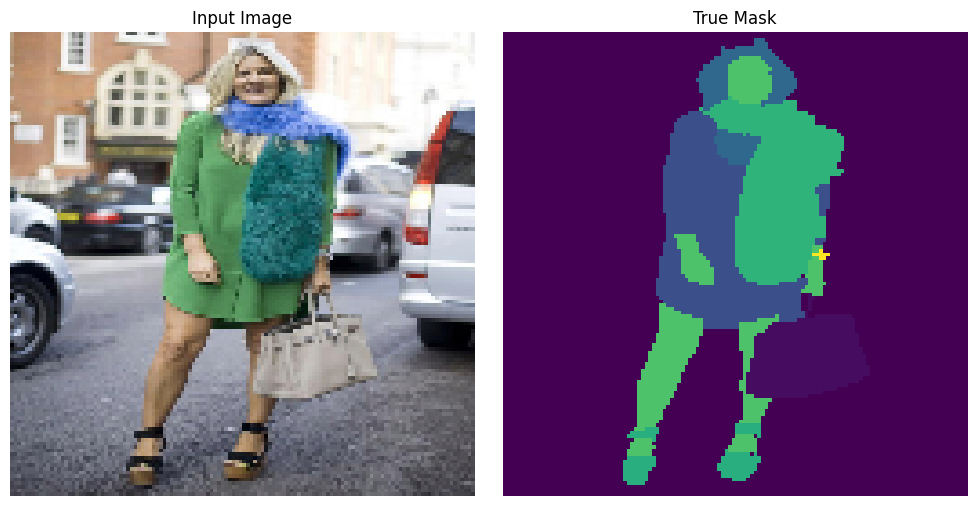

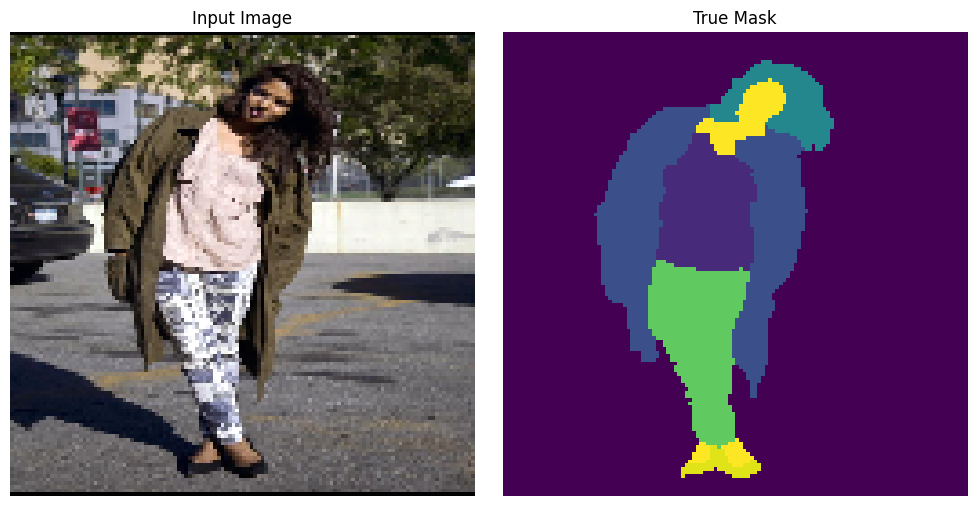

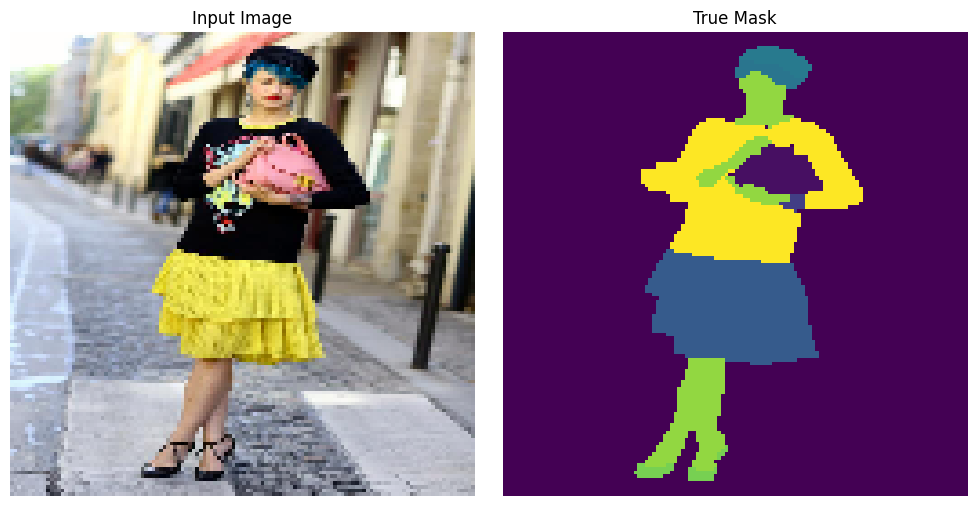

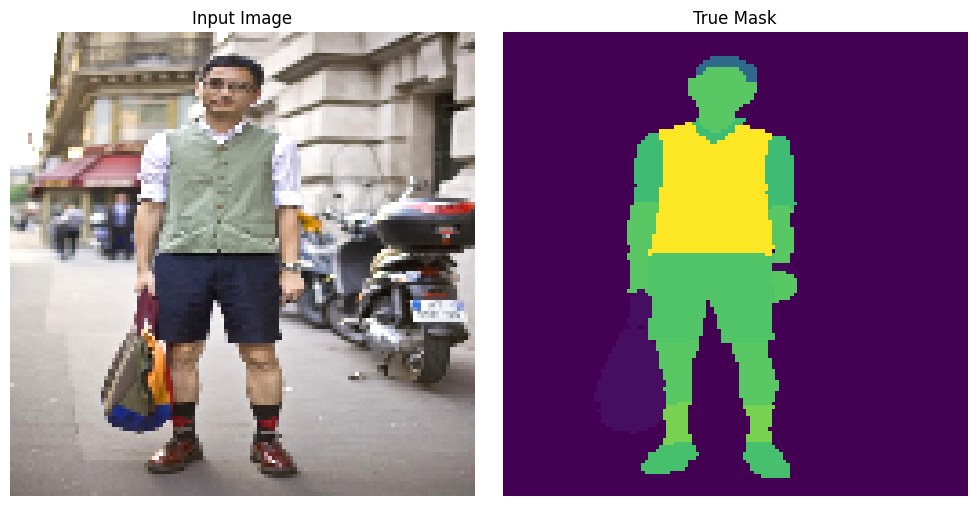

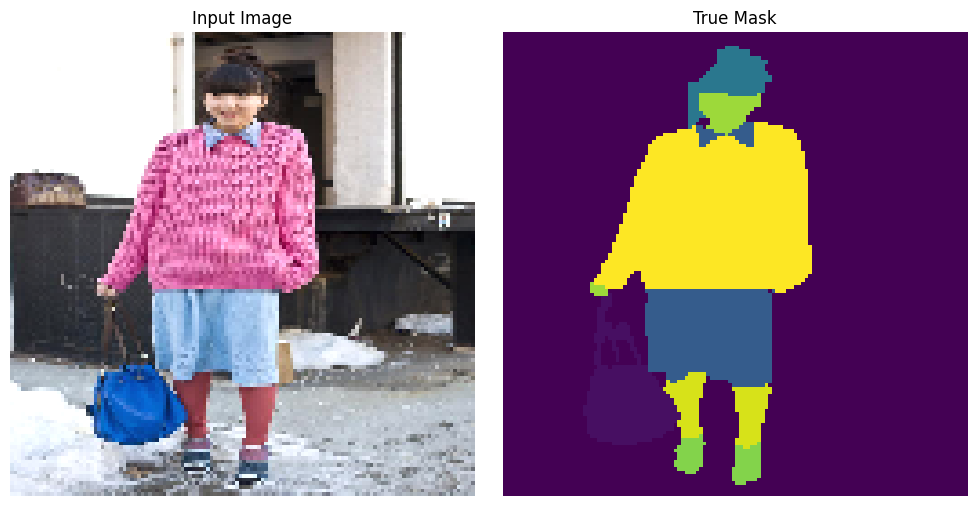

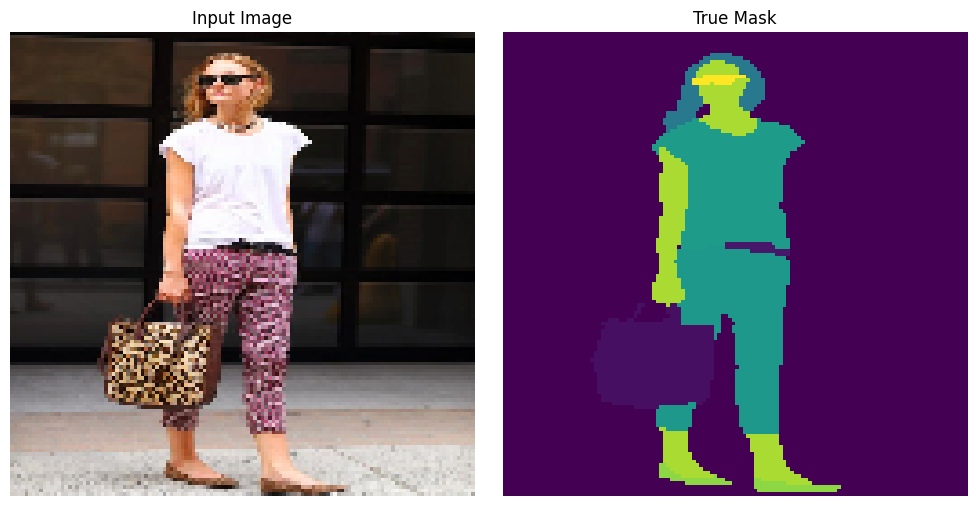

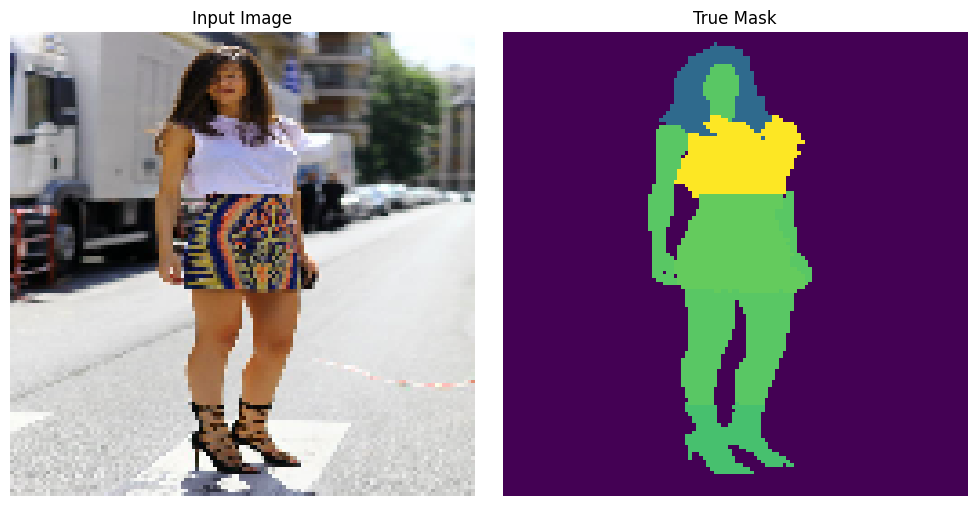

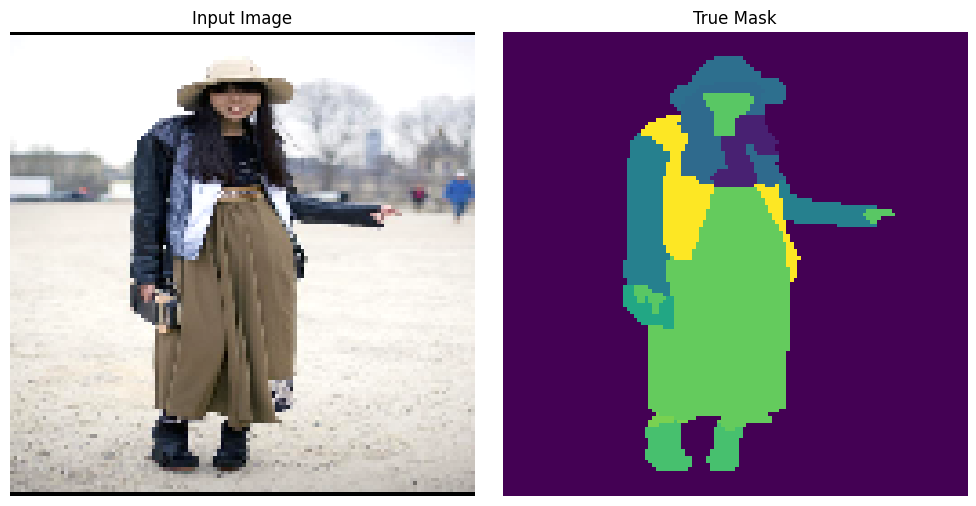

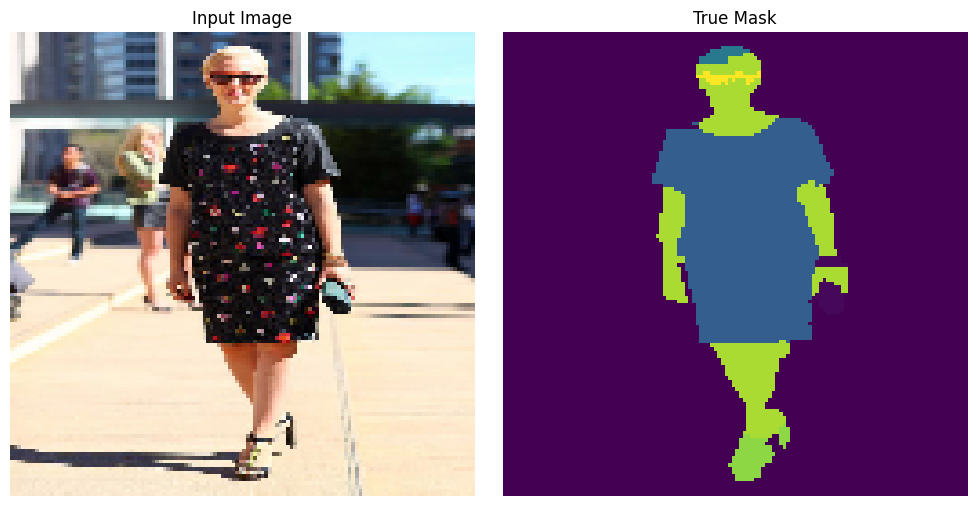

In [20]:
for images, masks in train_dataset.take(10):
    sample_image, sample_mask = images[0], masks[0]
    display_sample([sample_image,sample_mask])

## Definición de la arquitectura del modelo U-Net

"Este bloque garantiza que, en cada nivel de la U-Net, extraigamos la máxima cantidad de información de manera estable (gracias a Batch Normalization) antes de decidir si comprimimos la imagen (Encoder) o si la reconstruimos (Decoder)."

In [21]:
def double_conv_block(x, n_filters):
    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    # x = se_block(x)
    return x

"Este bloque extrae detalles con el double_conv_block, guarda esos detalles en fwd_block para los skip connections, y luego reduce la imagen a la mitad con MaxPool2D para enfocarse en el contexto general. Es el motor de la abstracción."

In [22]:
def downsample_block(x, n_filters, dropout_rate=0.2):
    fwd_block = double_conv_block(x, n_filters)
    pooled = MaxPool2D((2,2))(fwd_block)
    pooled = Dropout(dropout_rate)(pooled)
    return fwd_block, pooled

"El bloque de expansión es la etapa de reconstrucción. Usamos la Conv2DTranspose para devolver la resolución al doble. Lo más importante es el concatenate, que toma la información de contexto (la parte profunda) y la combina con la información de detalle fino (los skip connections del encoder). Esta fusión es lo que nos permite segmentar los objetos con bordes exactos, lo cual es la mayor ventaja de la U-Net."

In [23]:
def upsample_block(x, skip_connections, n_filters):
    x = Conv2DTranspose(n_filters,kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer='he_normal')(x)
    x = concatenate([x,skip_connections])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

"En resumen, construimos la U-Net para resolver dos problemas simultáneos: el Encoder comprime y entiende el contexto (sabe qué hay), y el Decoder descomprime y utiliza los saltos de conexión para mantener el detalle (sabe dónde está exactamente). El resultado es un modelo que nos da la probabilidad de pertenencia a una de las 59 clases por cada píxel de la imagen."

In [24]:
def build_unet_model(input_shape,output_channels):
    # Input layer
    inputs = Input(shape=input_shape)

    # encoder - contraction layer - downsampling
    f1, p1 = downsample_block(inputs,64)
    f2, p2 = downsample_block(p1,128)
    f3, p3 = downsample_block(p2,256)
    f4, p4 = downsample_block(p3,512)

    # intermediate block - bridge
    intermediate_block = double_conv_block(p4,1024)

    # decoder - expansion layer - upsampling
    u5 = upsample_block(intermediate_block,f4,512)
    u6 = upsample_block(u5,f3,256)
    u7 = upsample_block(u6,f2,128)
    u8 = upsample_block(u7,f1,64)

    outputs = Conv2D(output_channels, (1,1), activation='softmax',padding='same')(u8)
    unet_model = Model(inputs,outputs,name='U-Net')
    return unet_model

"En esencia, este código verifica que la arquitectura de la U-Net se haya construido correctamente con 59 canales de salida y nos da un resumen de todos los parámetros del modelo, confirmando que está listo para ser compilado y entrenado."

In [25]:
output_channels = 59
unet_model = build_unet_model(input_shape=(128,128,3),output_channels=output_channels)
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ leaky_re_lu_3[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[

 Total params: 34,540,667 (131.76 MB)

 Trainable params: 34,528,891 (131.72 MB)

 Non-trainable params: 11,776 (46.00 KB)

Introducción: Este comando es una herramienta de visualización y auditoría crucial que transforma la definición abstracta de Keras en un diagrama legible y profesional.

Qué hace: La función plot_model toma el objeto del modelo (unet_model) y lo mapea como un grafo dirigido (directed graph).

Generación de Diagrama: Crea un archivo de imagen (unet_model.png).

Detalles Visuales: El diagrama muestra la estructura completa de la red, incluyendo:

El flujo de datos desde la entrada a la salida.

Los bloques específicos (double_conv_block, downsample_block, etc.).

Las formas de entrada y salida de cada capa.

Los puntos de bifurcación y las conexiones laterales (concatenate).

Resolución: El parámetro dpi=100 asegura que la imagen tenga una resolución adecuada para ser presentada.

¿Por qué fue necesario?

Herramienta de Defensa Profesional: En una presentación de proyecto, este diagrama es la prueba visual más importante de la arquitectura implementada. Permite a la audiencia comprender instantáneamente la estructura en forma de "U", la contracción, la expansión y, sobre todo, la función crítica de los saltos de conexión sin tener que analizar el resumen (summary) de texto.

Confirmación del Flujo de Datos: Sirve como un control de calidad final para confirmar visualmente que las conexiones de los bloques de downsample (los f1 a f4) están correctamente unidas a los bloques de upsample (los u8 a u5), garantizando la correcta implementación de la U-Net.

Clarificación de la Complejidad: Permite justificar por qué se eligió esta arquitectura compleja (en lugar de una red puramente secuencial) para lograr la localización precisa de píxeles requerida en la segmentación semántica.

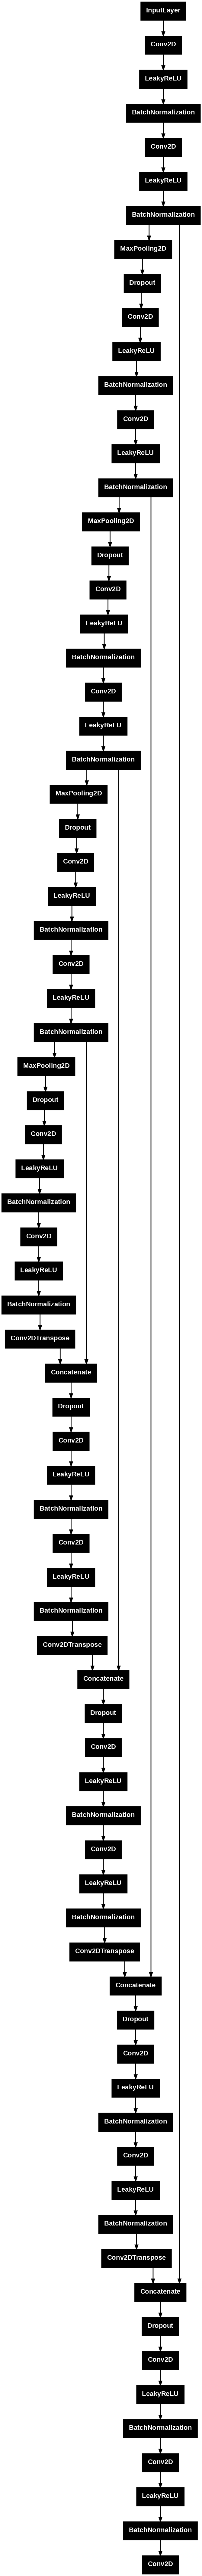

In [26]:
plot_model(unet_model,'unet_model.png',dpi=100)

## Entrenamiento del modelo U-Net

"Los valores $2$ y $1$ son definitorios de la métrica $F_1$. Lo más importante es el smooth ($\mathbf{10^{-6}}$), que garantiza que nuestra fórmula sea numéricamente estable y nunca falle por división por cero, incluso cuando el modelo no predice una clase. Y la resta de $1$ simplemente transforma nuestra métrica de éxito en una función de error para el optimizador." "Usamos tf.clip_by_value con el valor $10^{-7}$ para evitar que la pérdida se vuelva infinita (NaN). Es una técnica estándar de higiene de código en Deep Learning para asegurar que el entrenamiento sea estable y robusto."

In [27]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(tf.squeeze(y_true, axis=-1), tf.int32)
    y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice


Utilizar una pérdida híbrida es una decisión técnica superior porque le enseña al modelo a ser exitoso en dos niveles:

Nivel Semántico (SCCE): Asegura que el modelo sepa qué objeto está presente (clasificación).

Nivel Geométrico (Dice Loss): Asegura que el modelo sepa dónde está el límite exacto del objeto (localización y precisión).

In [28]:
def hybrid_loss(y_true, y_pred, alpha=0.5):
    scce = SparseCategoricalCrossentropy()(y_true, y_pred)
    dice = tf.reduce_mean(dice_loss(y_true, y_pred))
    return alpha * dice + (1 - alpha) * scce

"Al compilar, le indicamos al modelo que use el optimizador Adam con una tasa lenta para la estabilidad, que minimice la Pérdida Híbrida para obtener el mejor balance entre clasificación y precisión geométrica, y que monitoree la precisión para la evaluación."

In [29]:
adam = Adam(learning_rate=1e-4)
unet_model.compile(loss=hybrid_loss,optimizer=adam,metrics=['accuracy'])

"Este proceso no solo entrena la U-Net, sino que utiliza callbacks para autodeterminar el final óptimo del entrenamiento y garantizar que el modelo final sea la versión más generalizable y precisa."

In [30]:
epochs = 400
batch_size = 32
callbacks = [
    EarlyStopping(monitor='val_loss',patience=55,verbose=1,mode='min',restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',factor=0.1,mode='min',patience=5,min_lr=1e-4,verbose=1),
    ModelCheckpoint(filepath='EntrenamientoModelo.keras',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
]

r = unet_model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = epochs,
    batch_size = batch_size,
    callbacks = callbacks
)

Epoch 1/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1680 - loss: 2.5489 
Epoch 1: val_accuracy improved from -inf to 0.74089, saving model to EntrenamientoModelo.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 526s 20s/step - accuracy: 0.1736 - loss: 2.5407 - val_accuracy: 0.7409 - val_loss: 3.3753 - learning_rate: 1.0000e-04
Epoch 2/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.6151 - loss: 1.8611
Epoch 2: val_accuracy did not improve from 0.74089
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 745ms/step - accuracy: 0.6165 - loss: 1.8578 - val_accuracy: 0.6636 - val_loss: 5.5392 - learning_rate: 1.0000e-04
Epoch 3/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.7068 - loss: 1.6060
Epoch 3: val_accuracy did not improve from 0.74089
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 797ms/step - accuracy: 0.7071 - loss: 1.6046 - val_accuracy: 0.6357 - val_loss: 4.0223 - learning_rate: 1.0000e-04
Epoch 4/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.7295 - loss: 1.4824
Epoch 4: val_accura

## RENDIMIENTO DEL MODELO

"Este gráfico demuestra que la Pérdida Híbrida disminuyó de forma controlada a lo largo de las épocas, y la comparación entre la train loss y val_loss es la prueba de que el modelo aprendió exitosamente sin sobreajustarse a los datos de entrenamiento."

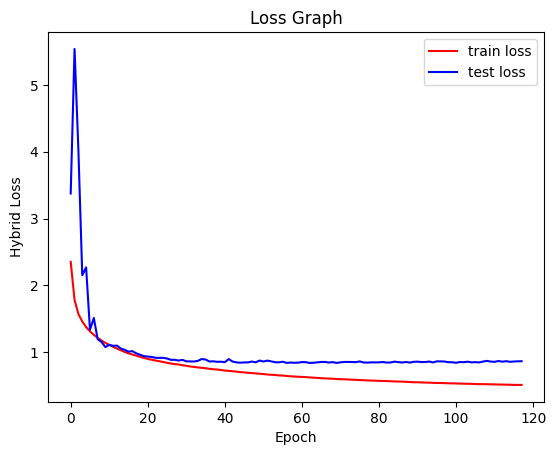

In [31]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Hybrid Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

## PRECISIÓN DEL MODELO


"El gráfico de precisión es la prueba de rendimiento del modelo. Muestra que la precisión subió consistentemente y, más importante, que la precisión en los datos de prueba (val_accuracy) se mantuvo alta, demostrando la capacidad de la U-Net para generalizar y clasificar correctamente los píxeles de las nuevas imágenes."

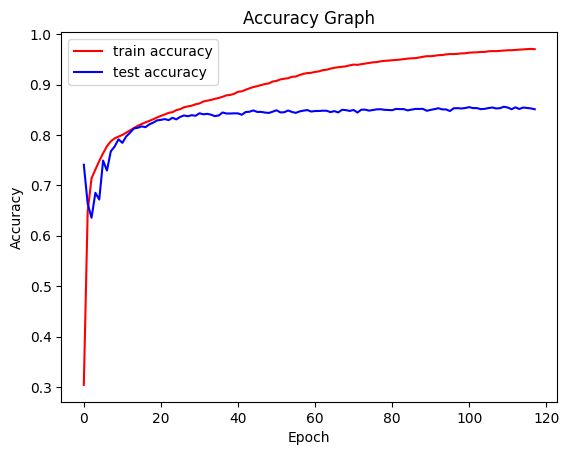

In [32]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

## PRUEBAS

"La función create_prediction_mask es necesaria porque convierte el lenguaje probabilístico de la red en la decisión final y categórica que representa la máscara de segmentación, permitiéndonos ver exactamente qué clase fue asignada a cada píxel."

In [33]:
def create_prediction_mask(prediction_mask, batch_idx):
    prediction_mask = tf.argmax(prediction_mask,axis=-1)
    prediction_mask = prediction_mask[...,tf.newaxis]
    return prediction_mask[batch_idx]

"La función segment_image nos permite realizar una evaluación cualitativa. Es la evidencia visual que demuestra que el modelo es capaz de generalizar a imágenes no vistas y logra una segmentación pixel-a-pixel precisa en términos de forma y límites de los objetos. Es la demostración final del éxito del proyecto."



In [34]:
def segment_image(dataset=None,num=10):
    if dataset:
        for images, masks in dataset.take(num):
            prediction_masks = unet_model.predict(images,verbose=0)
            for i in range(len(images)):
                display_sample([images[i], masks[i], create_prediction_mask(prediction_masks,i)])

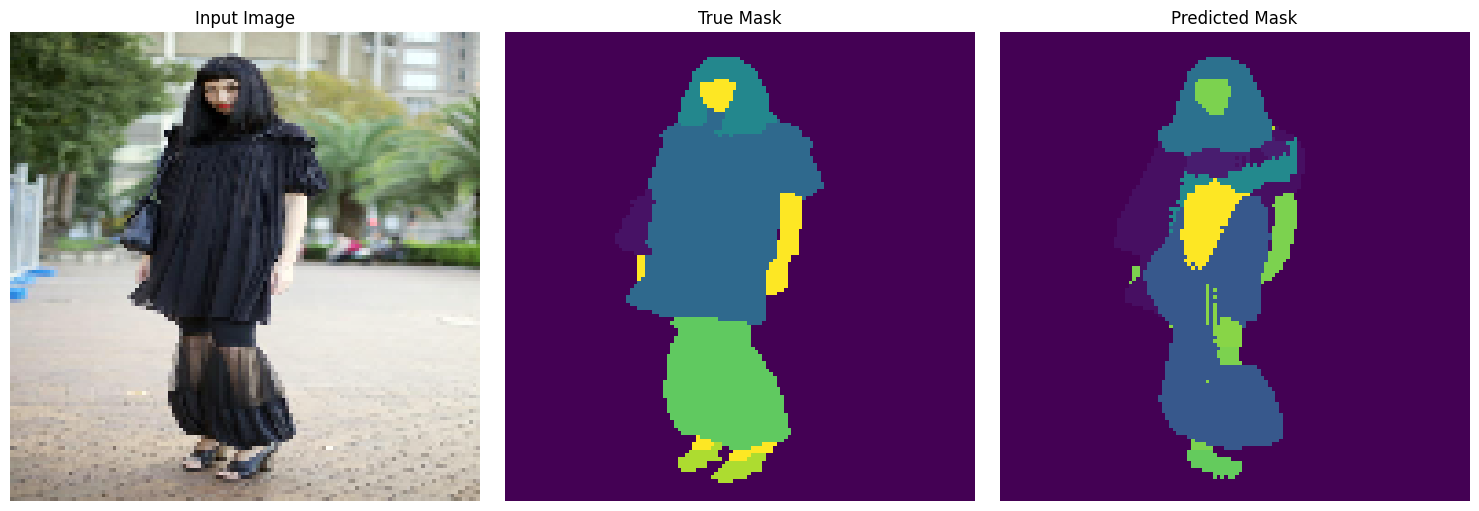

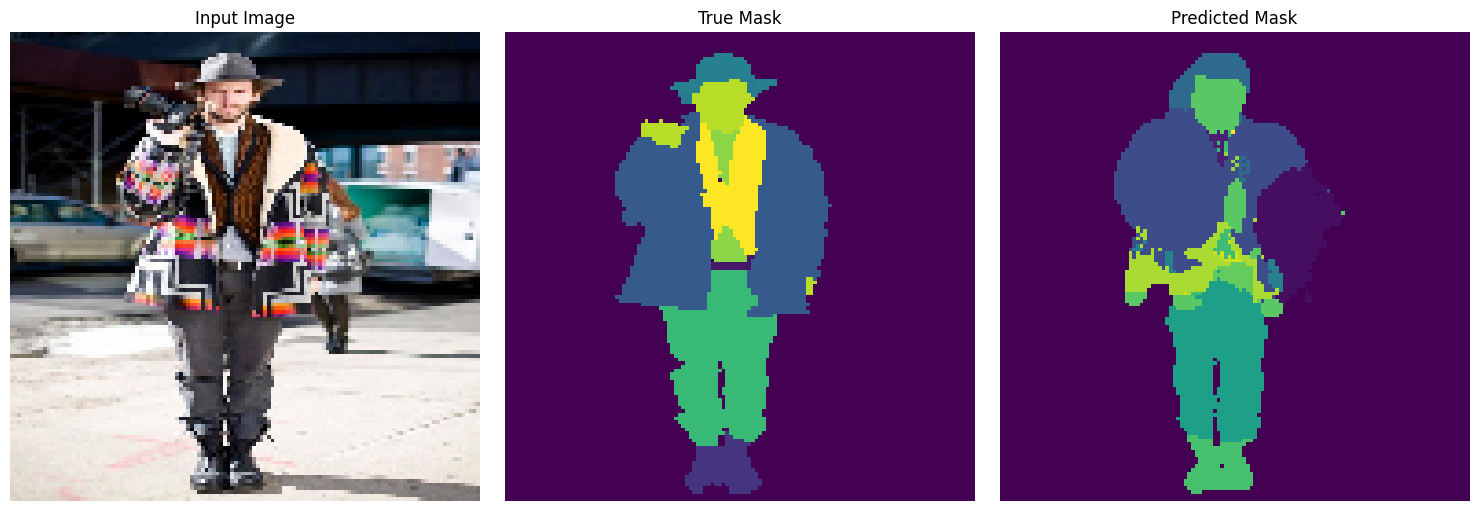

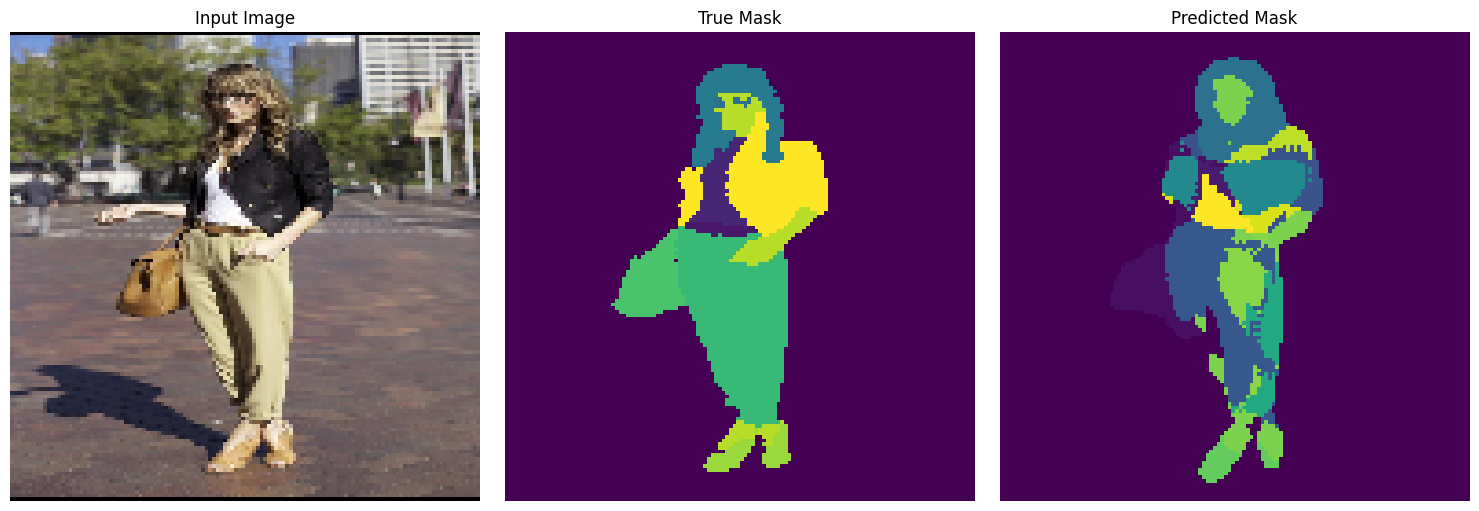

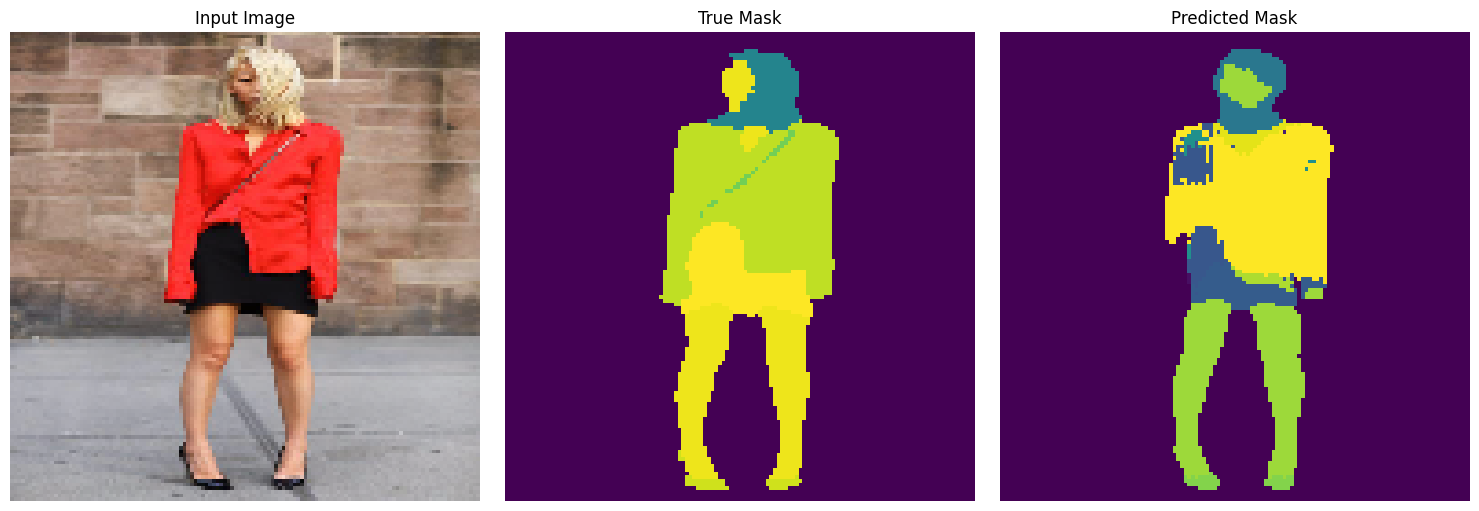

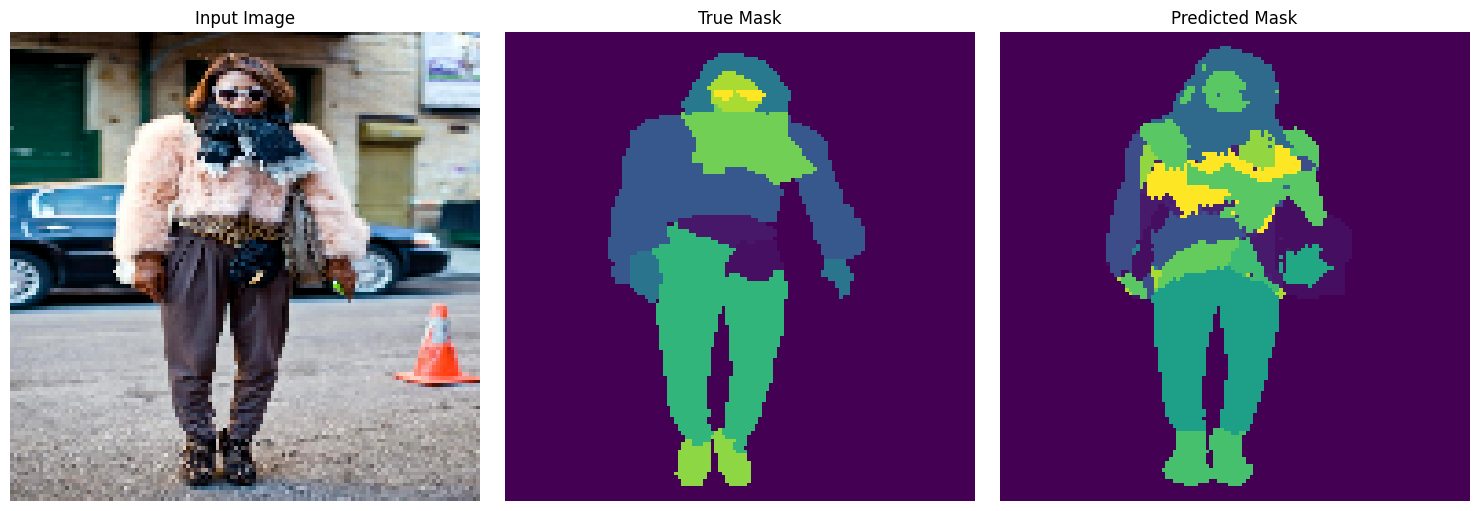

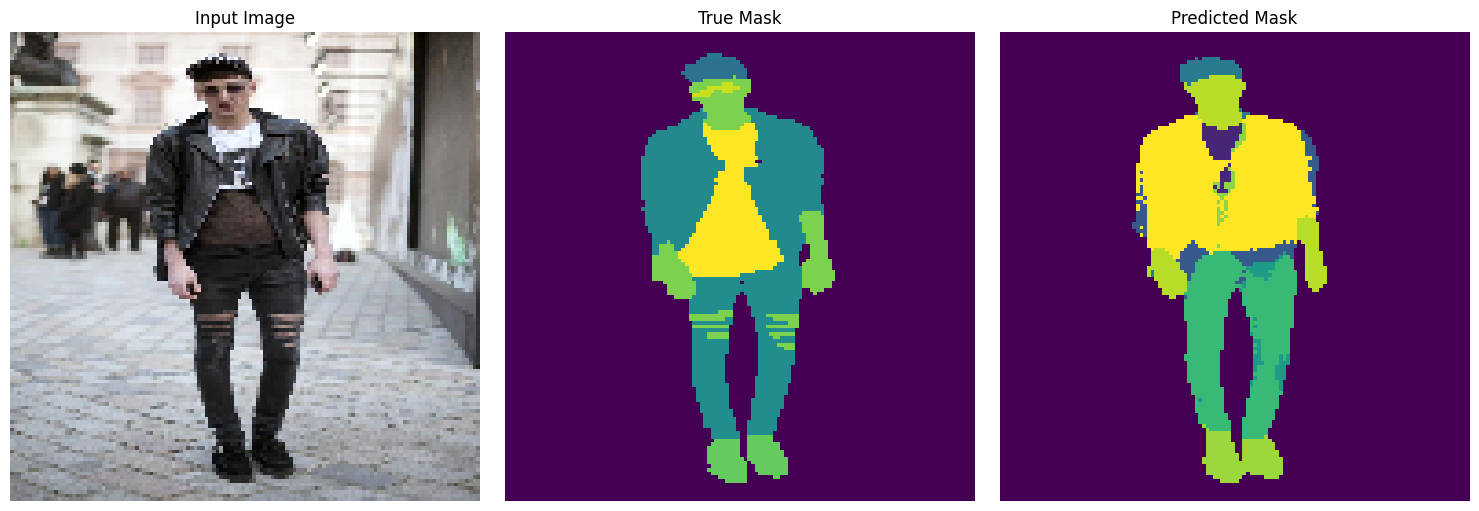

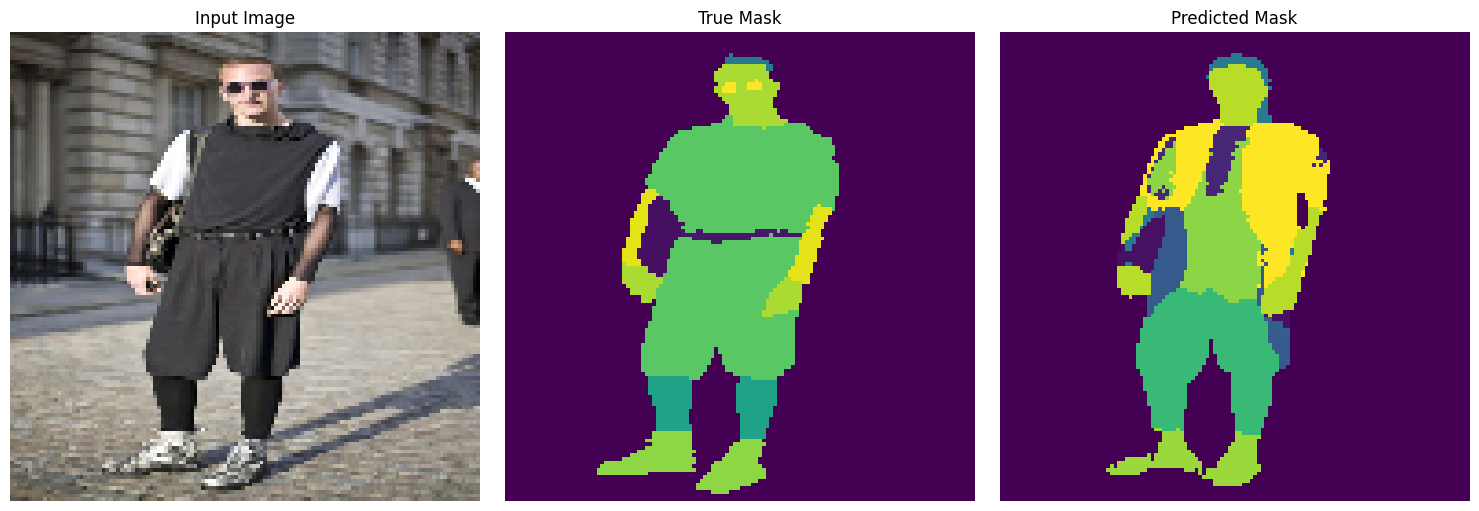

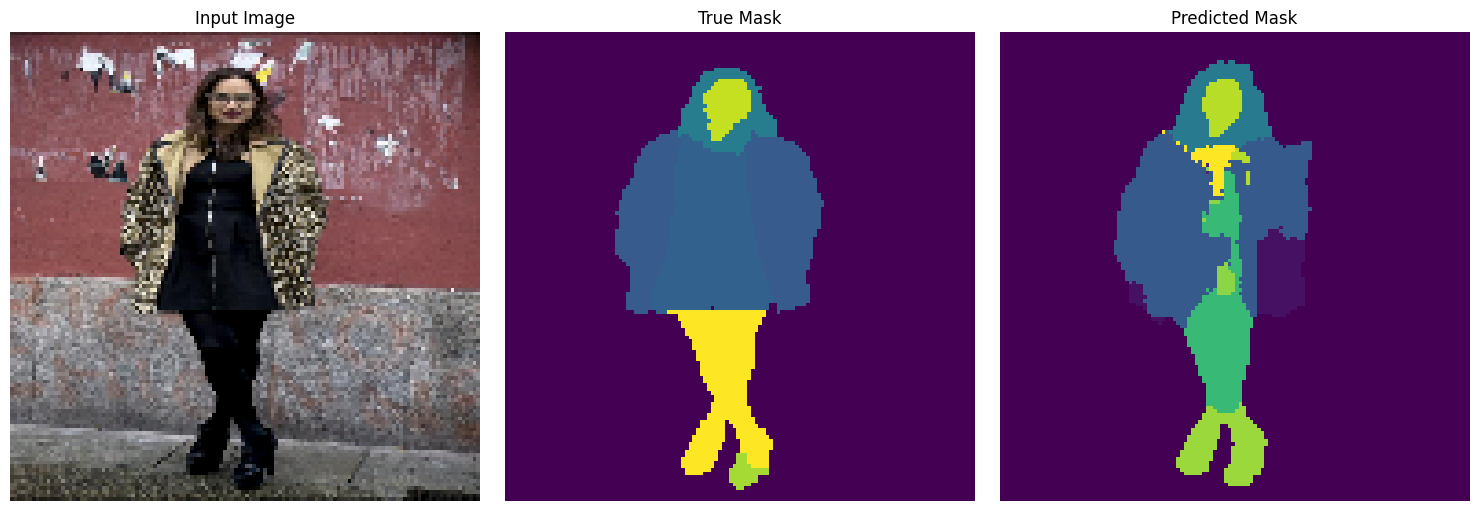

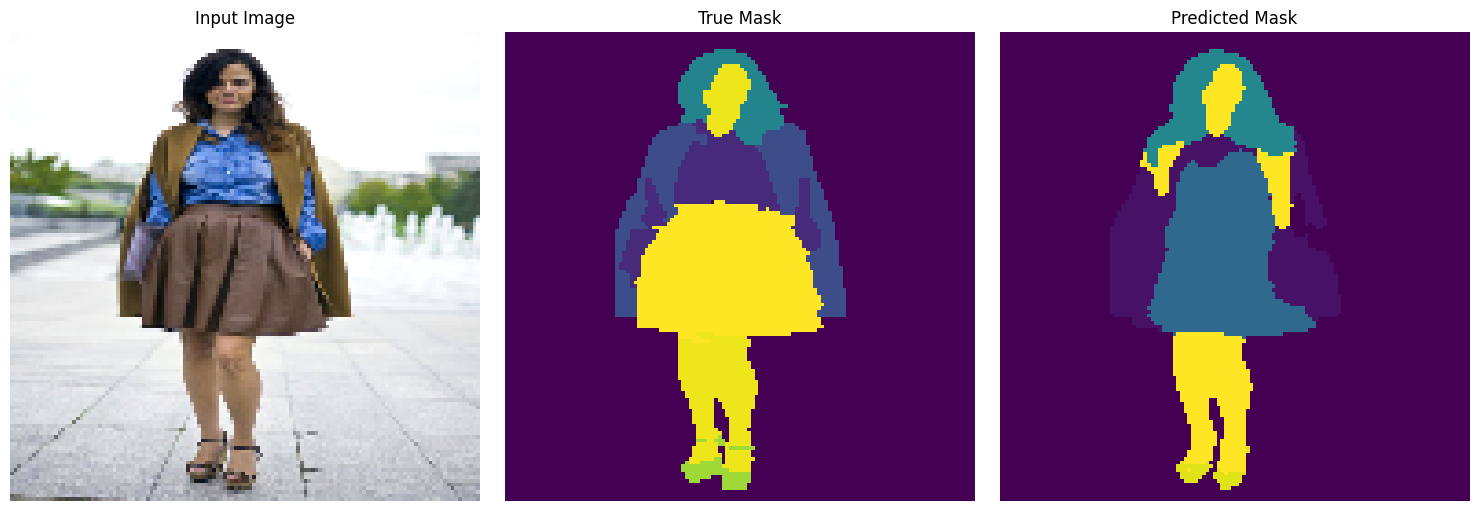

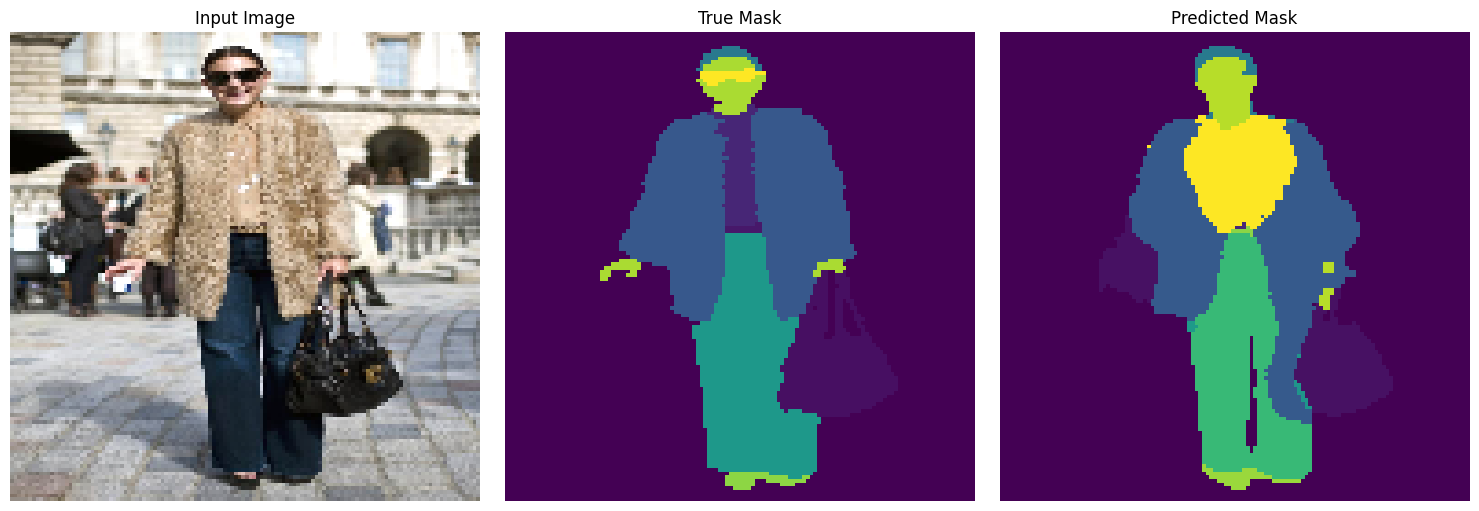

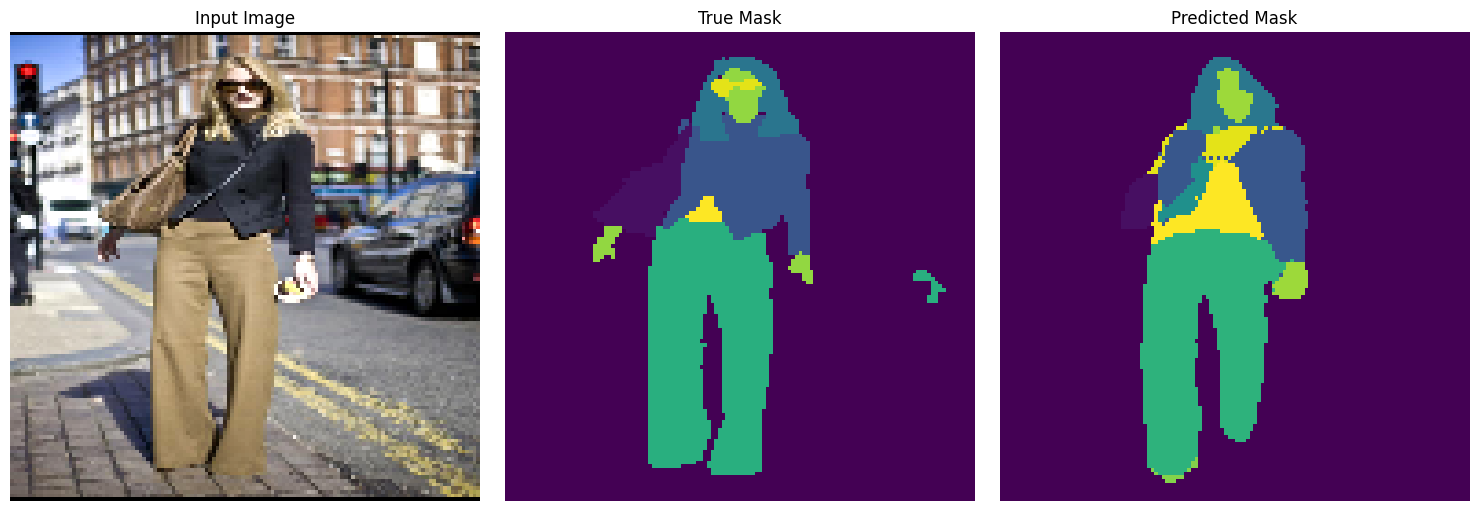

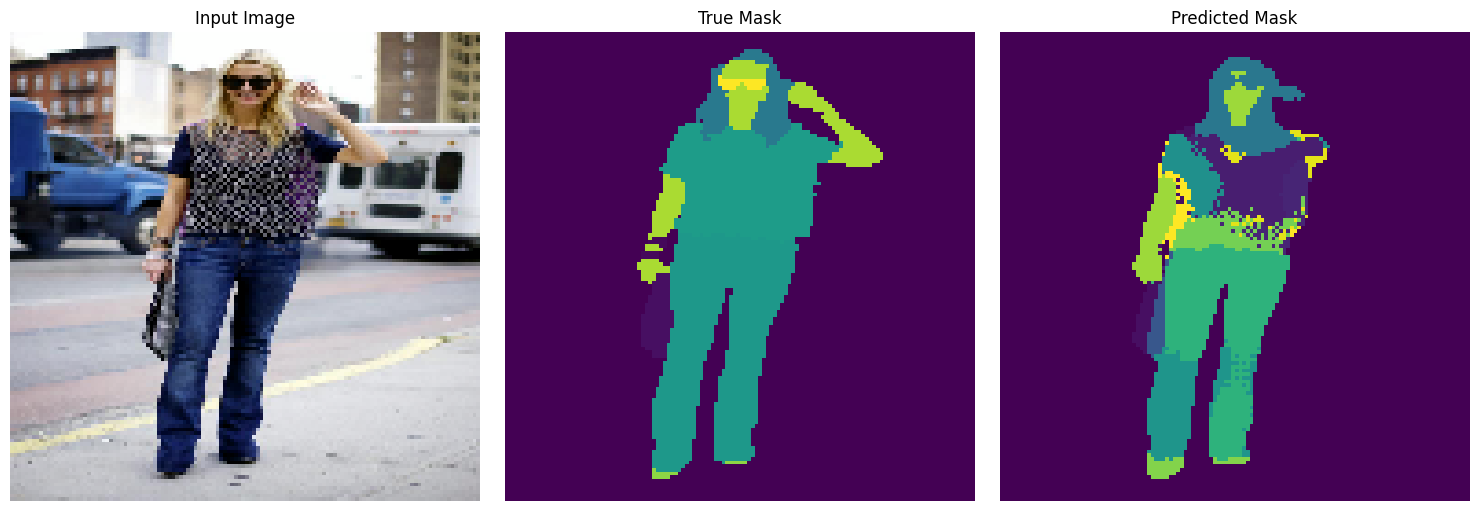

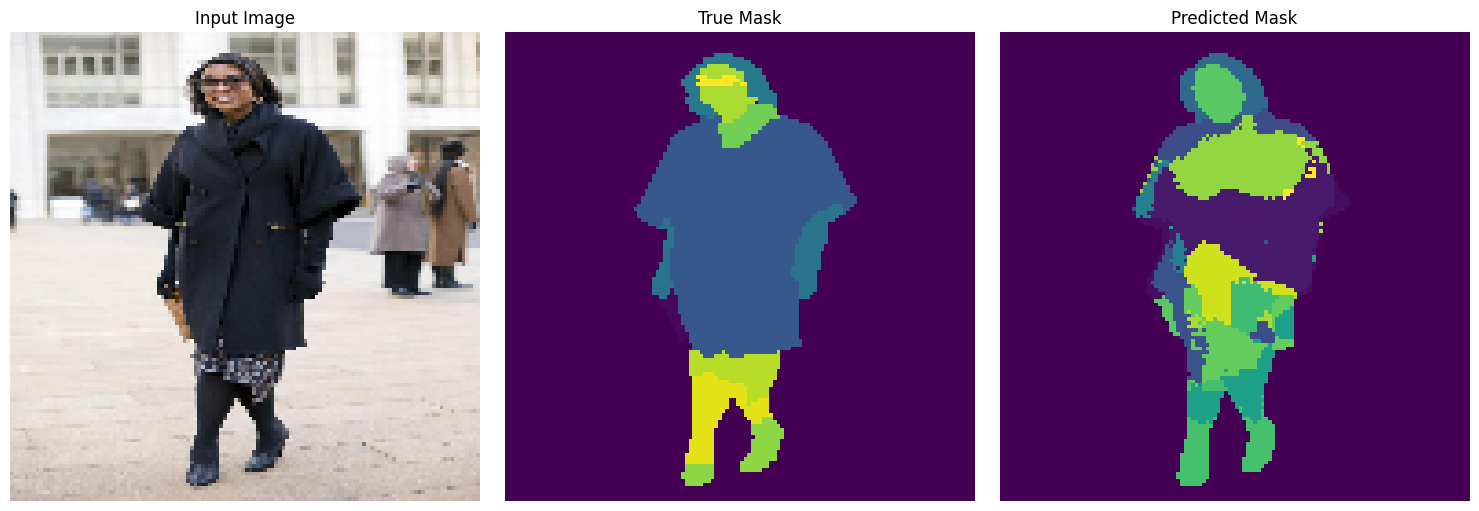

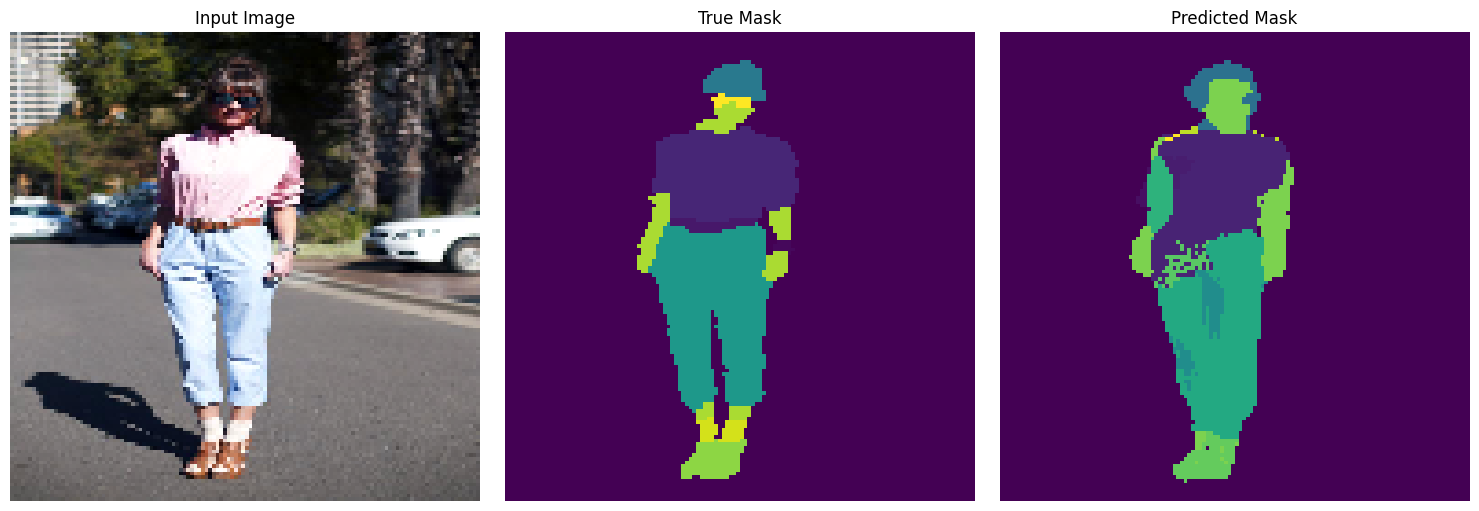

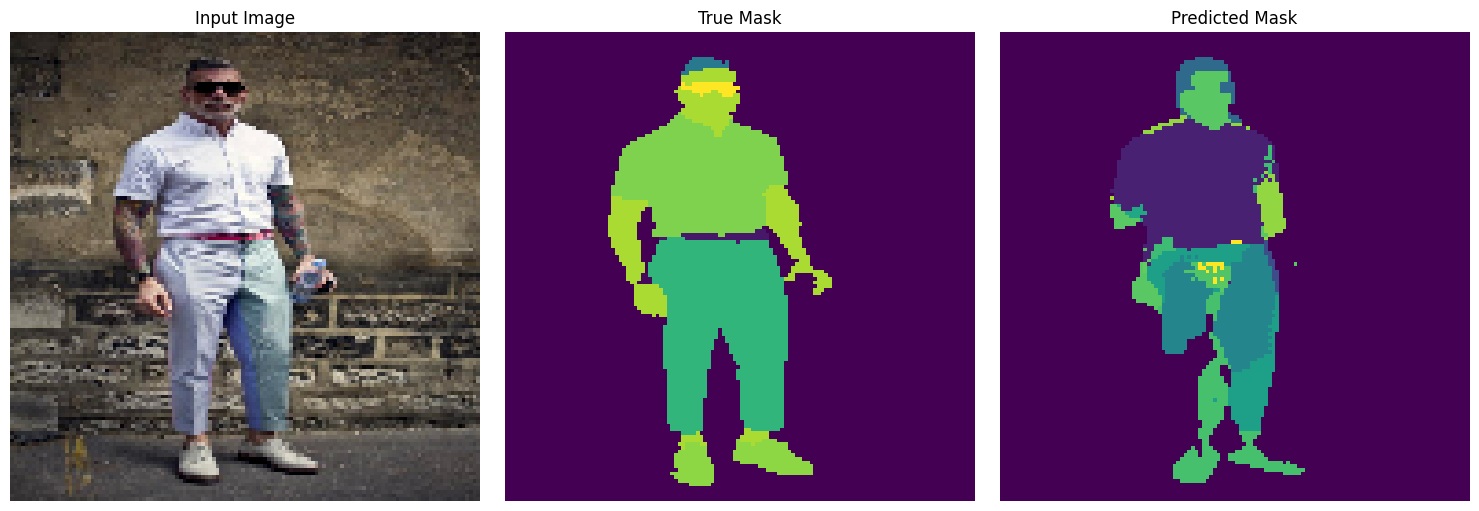

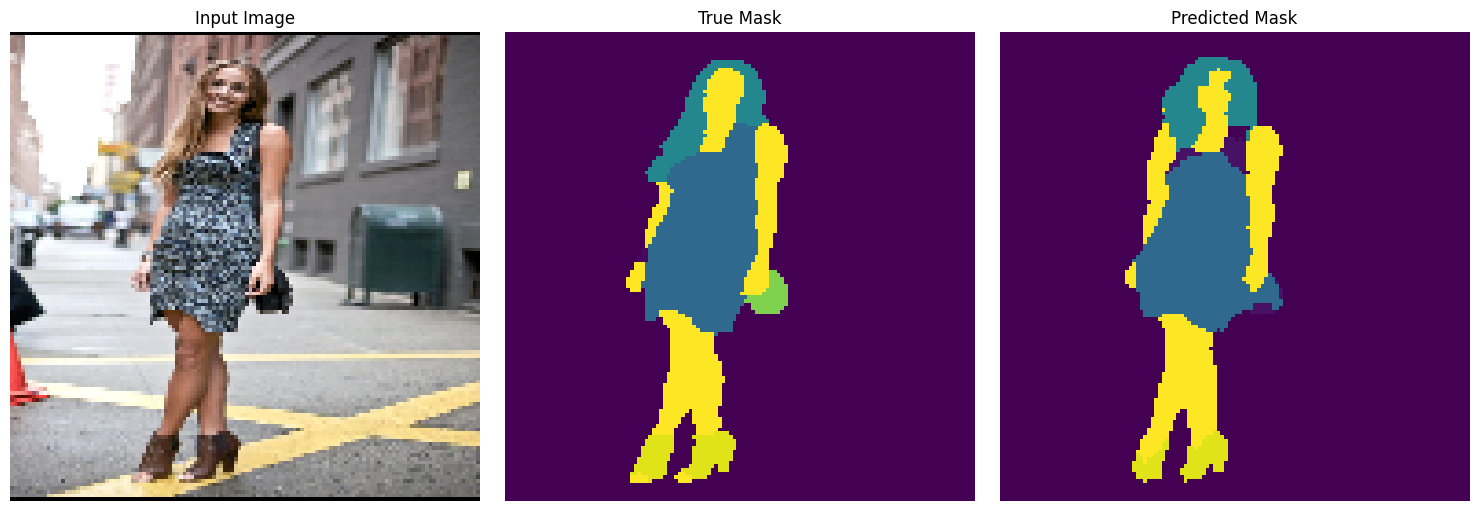

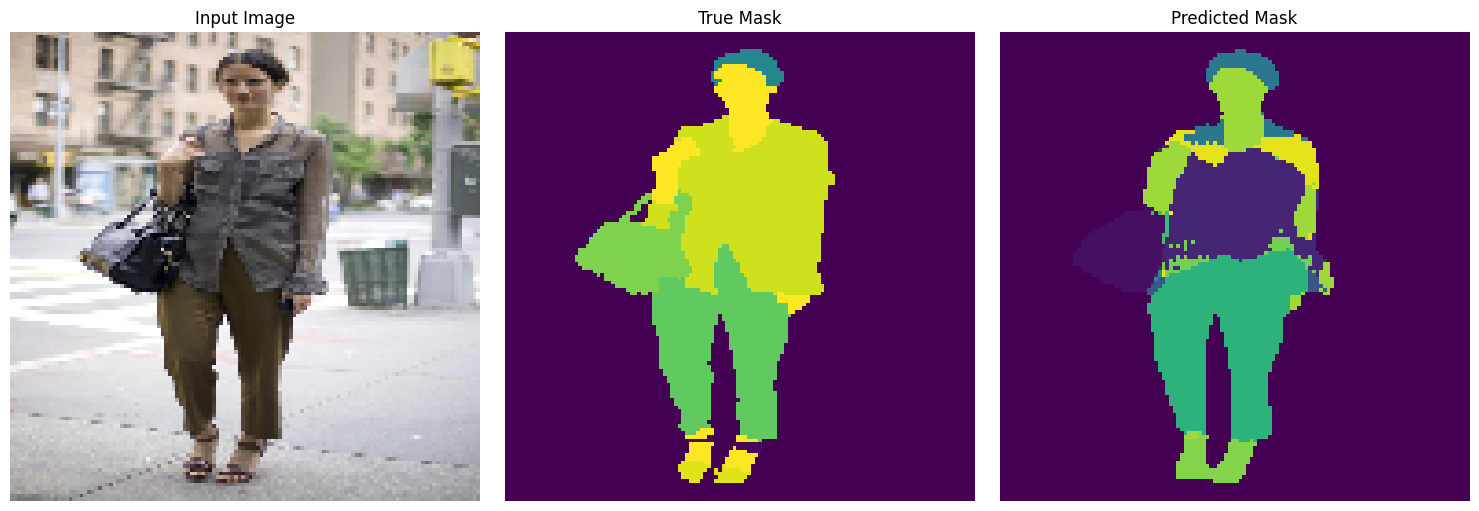

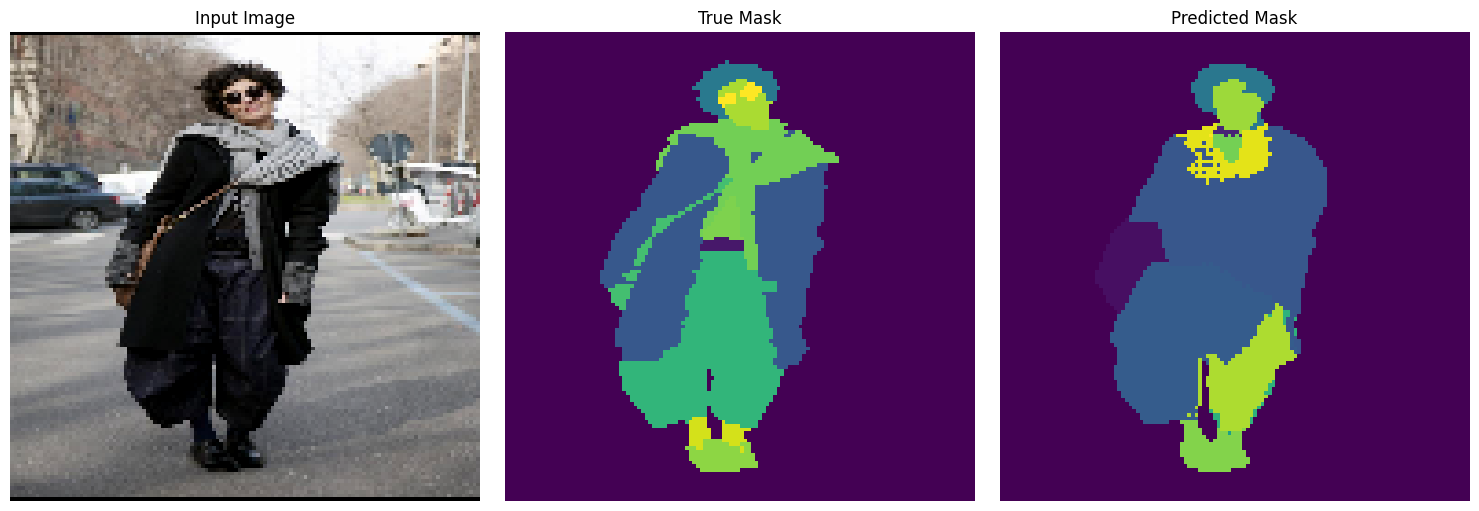

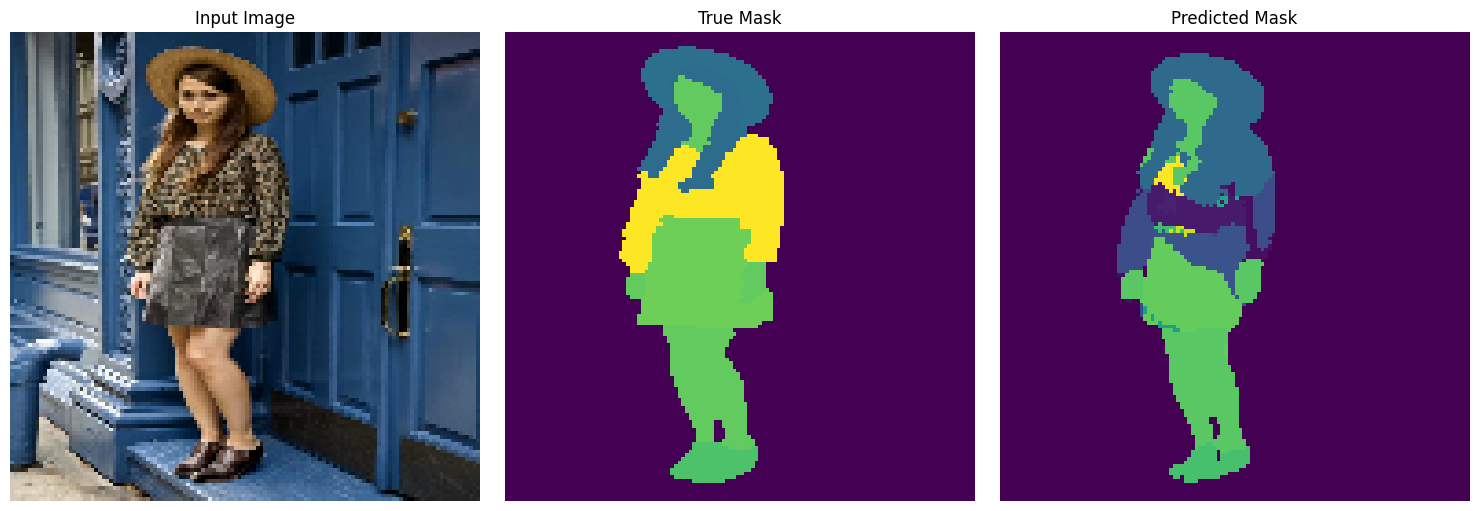

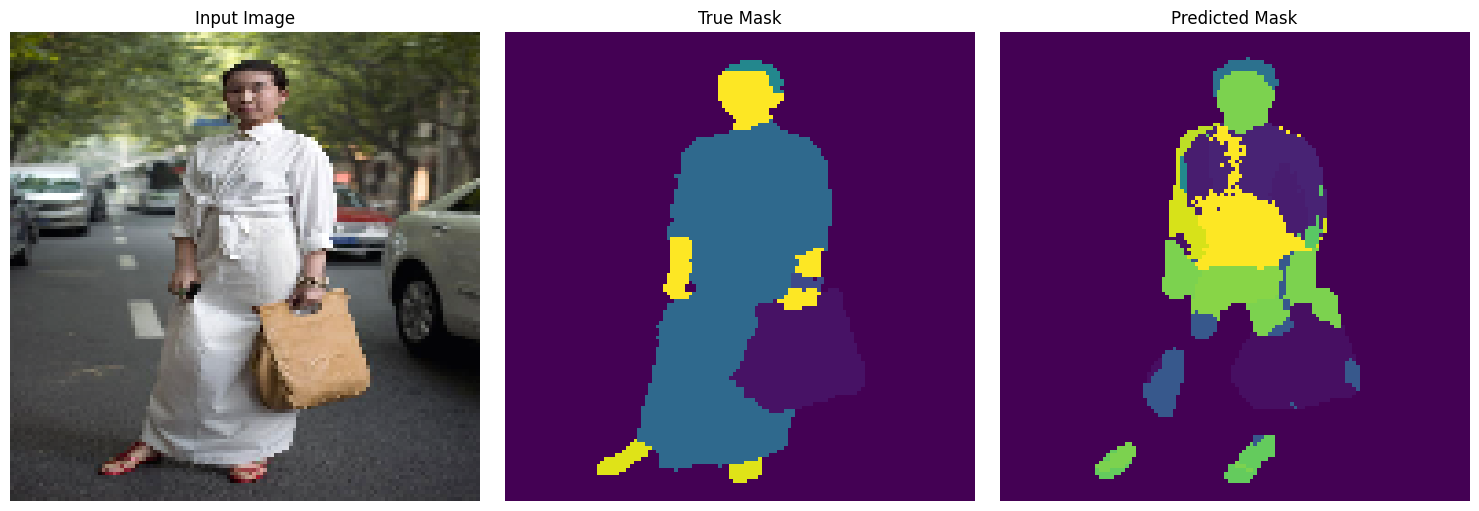

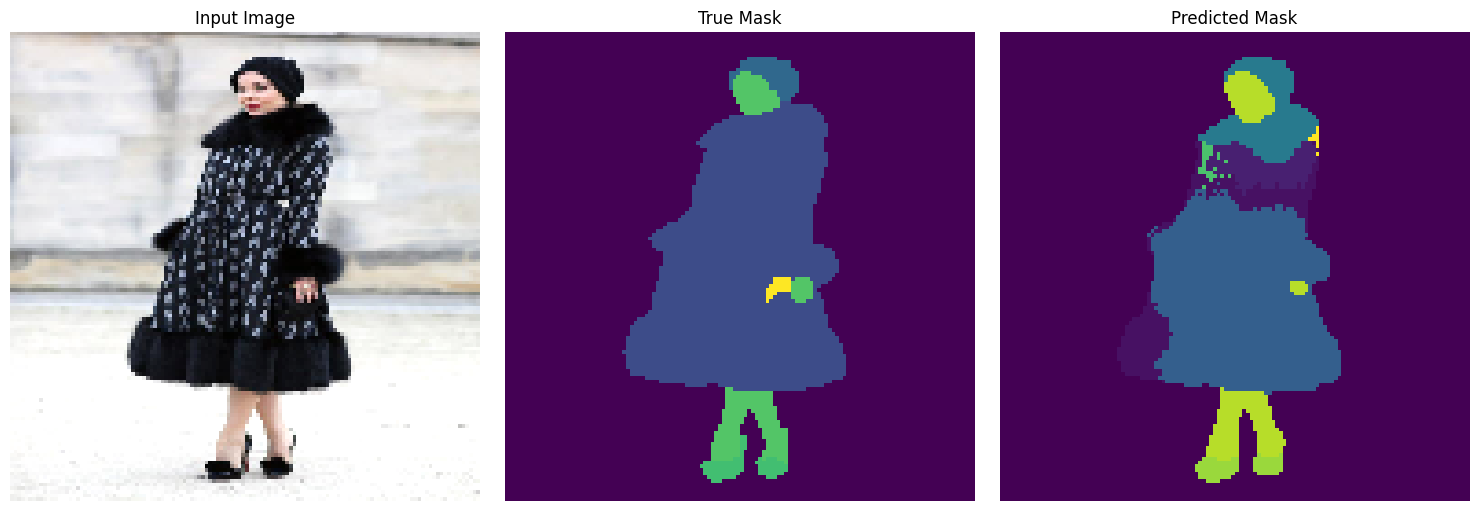

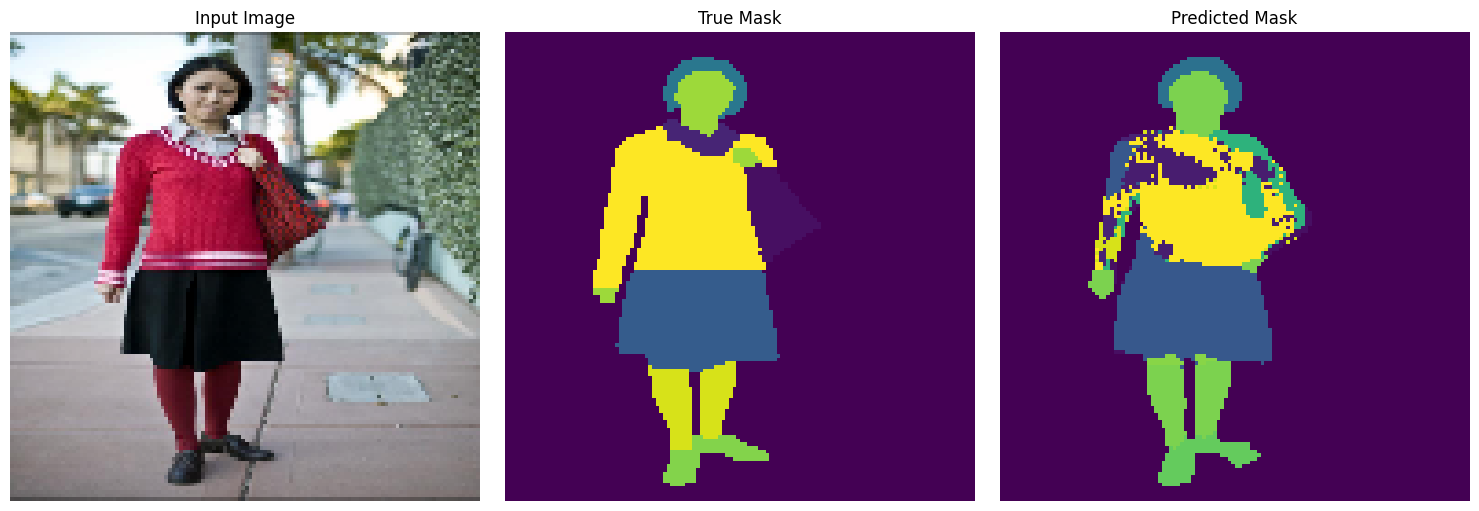

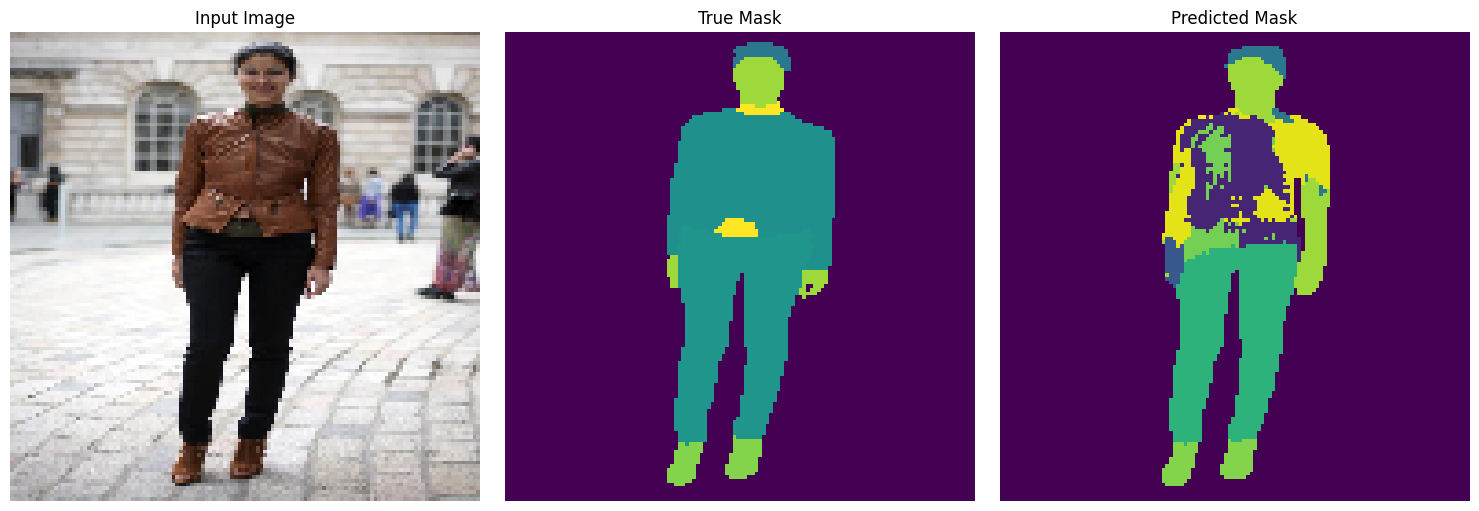

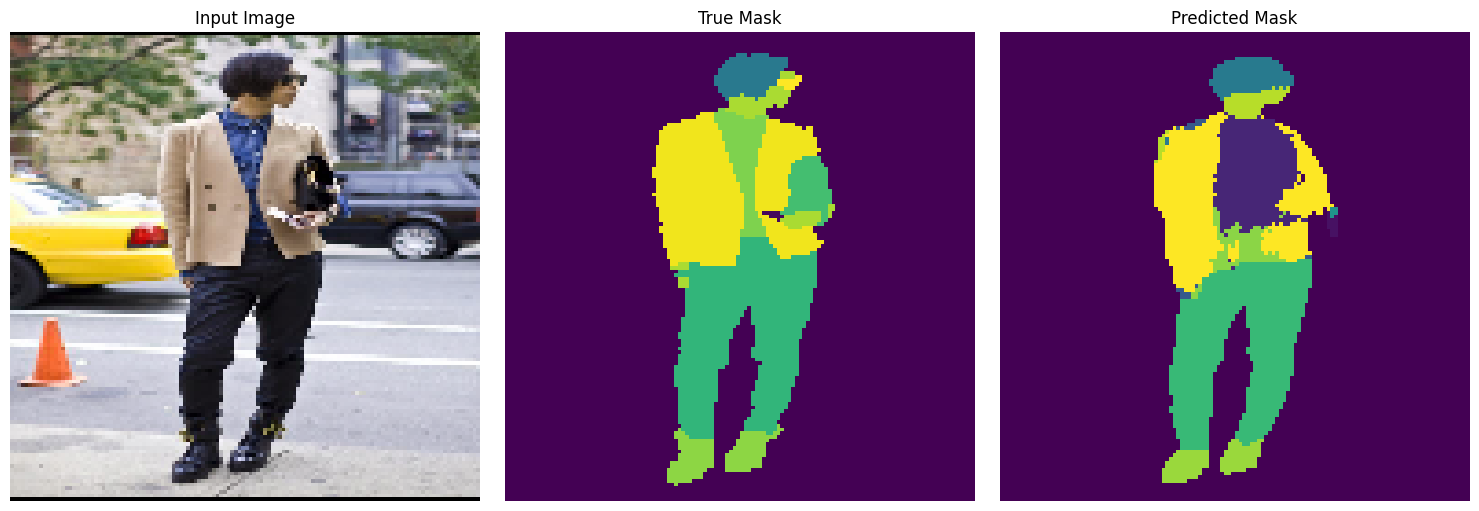

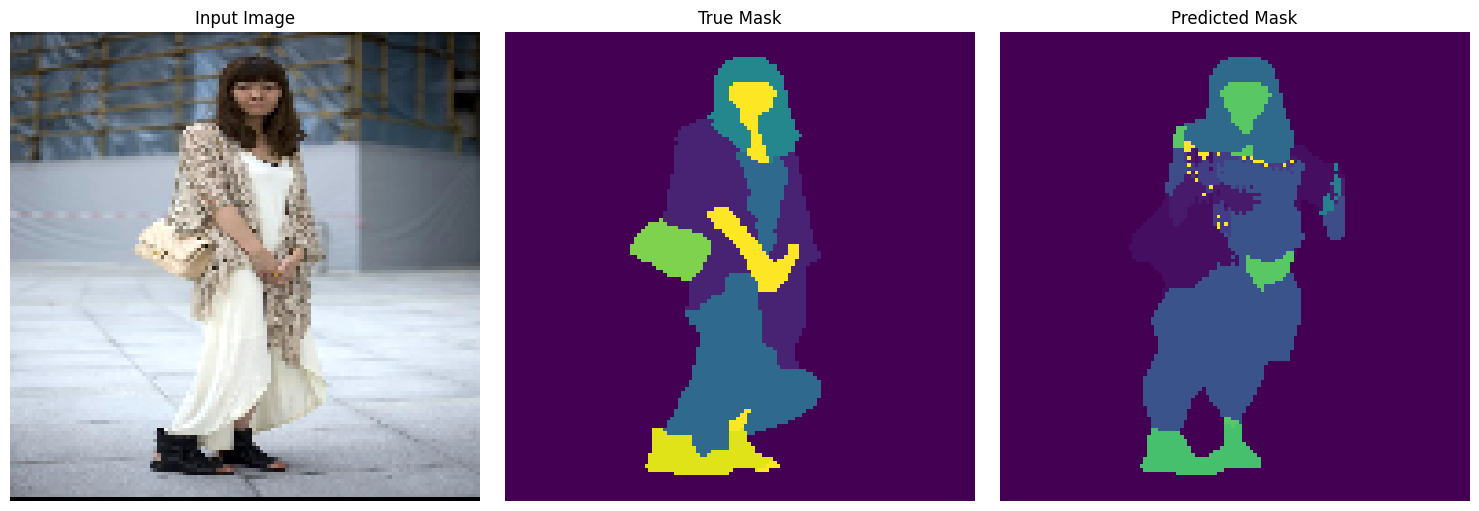

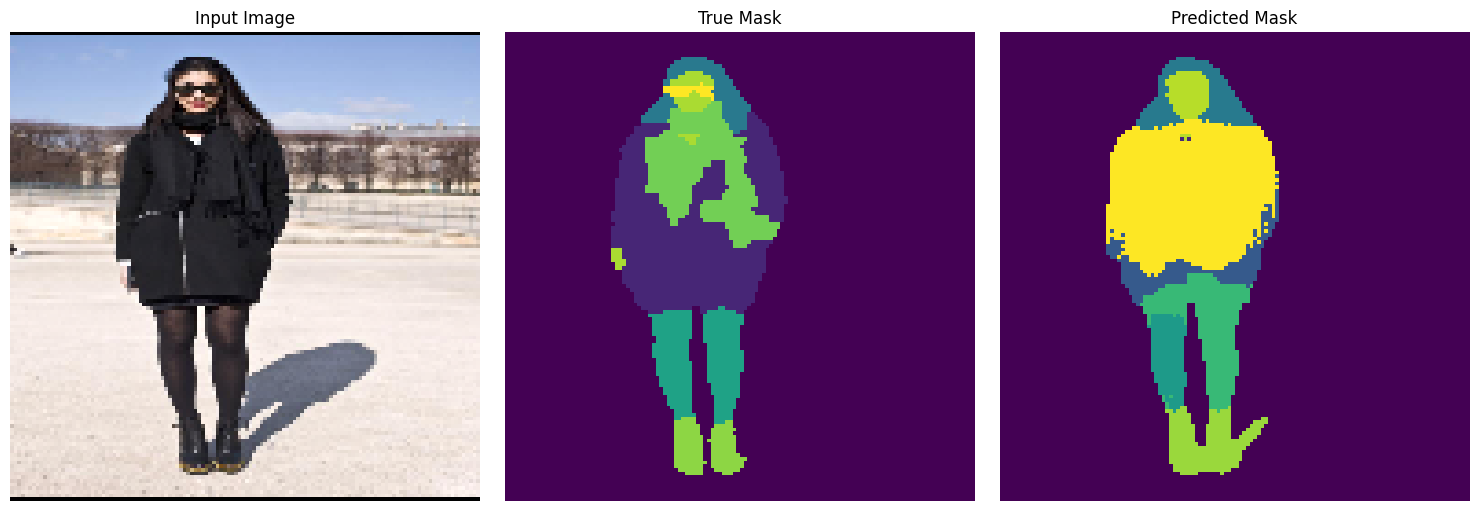

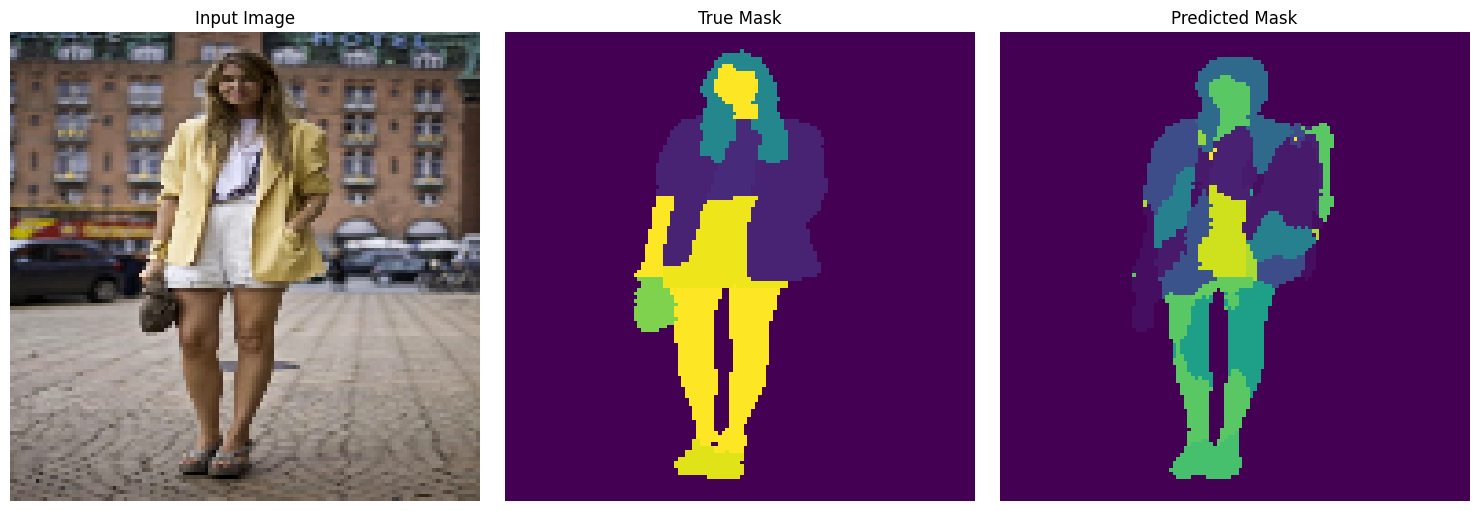

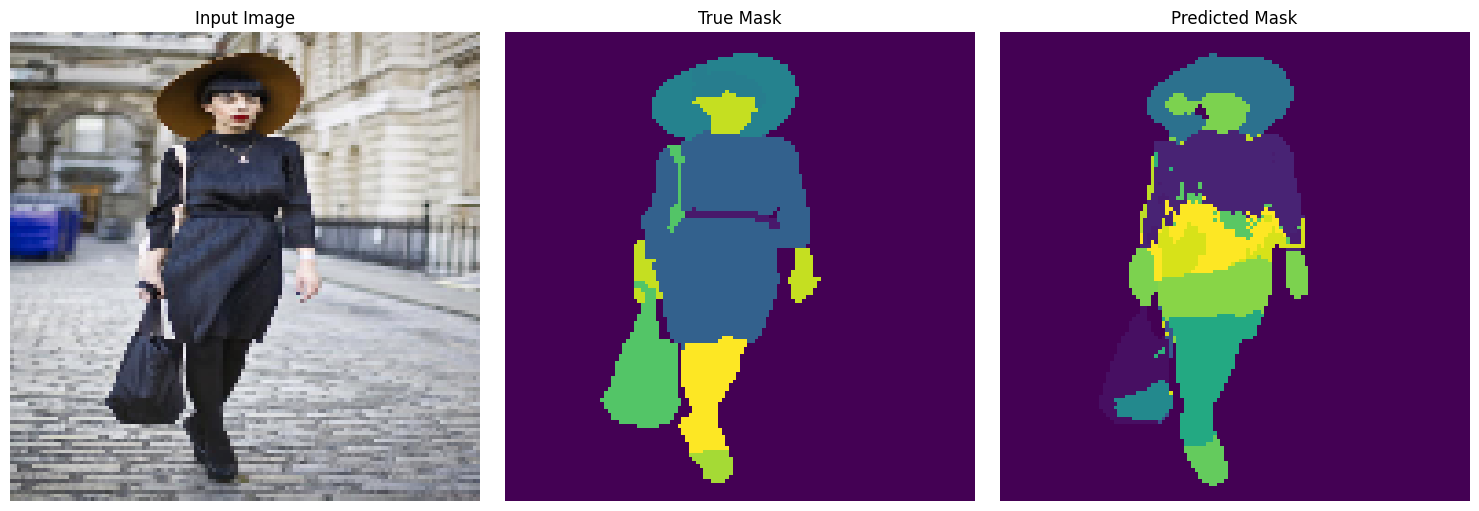

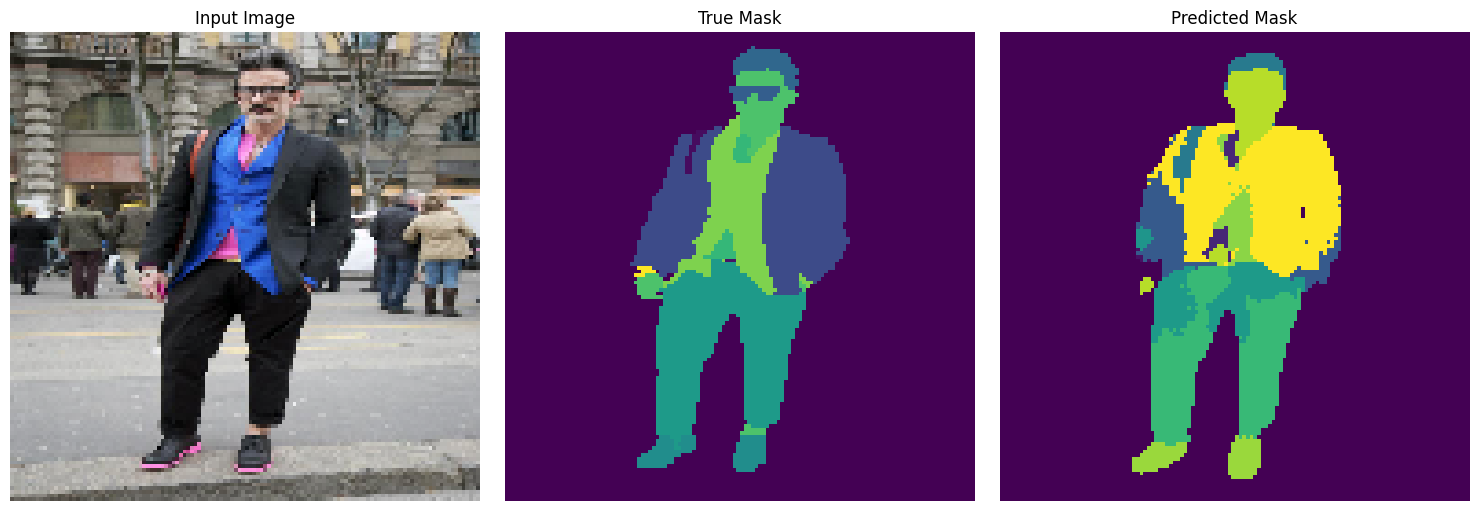

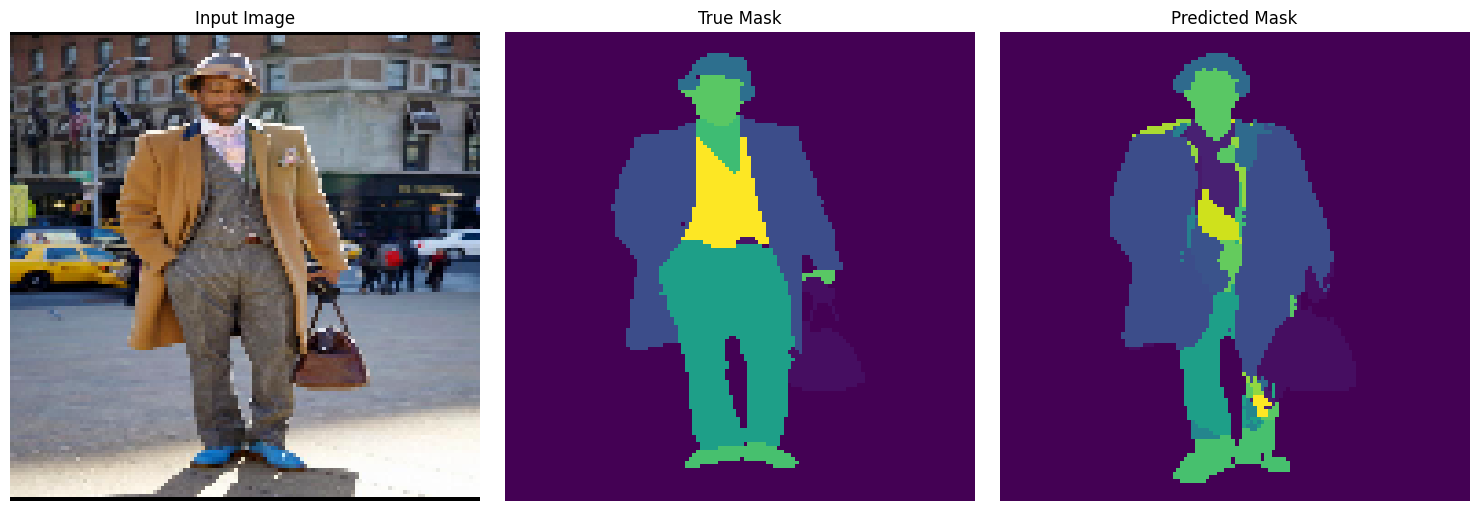

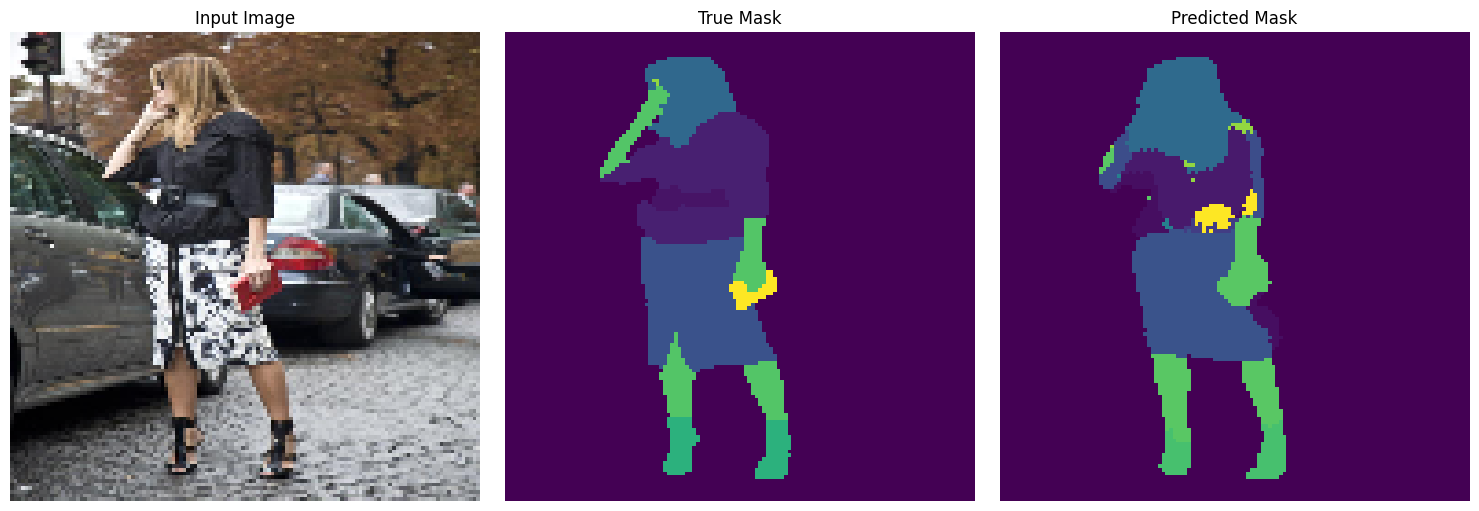

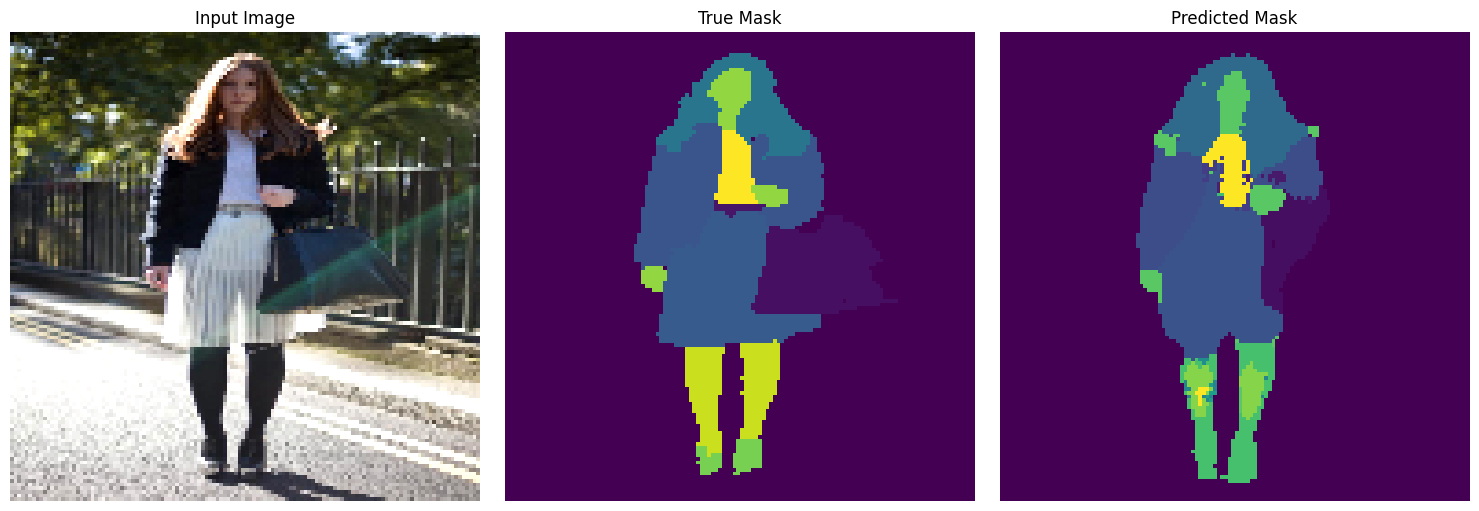

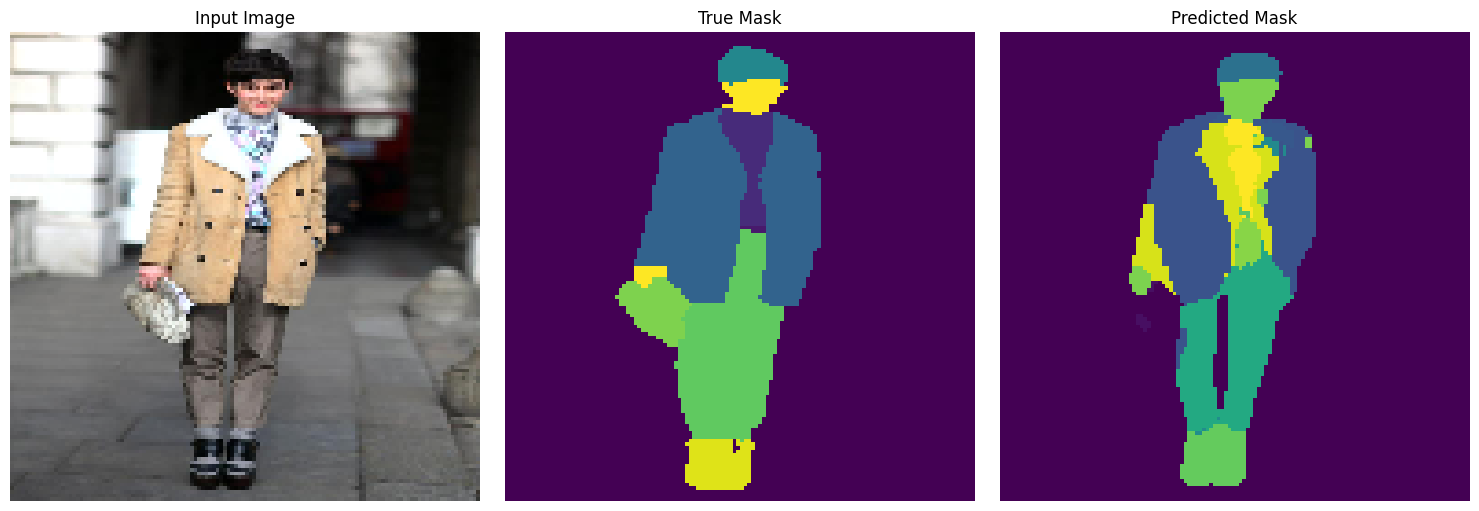

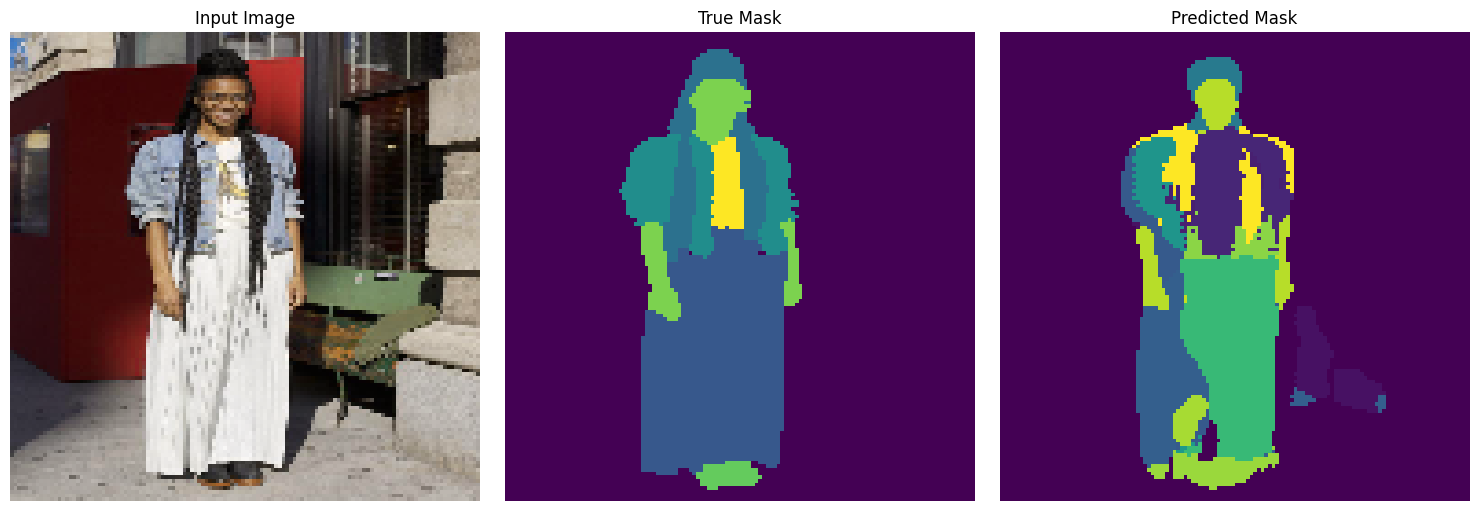

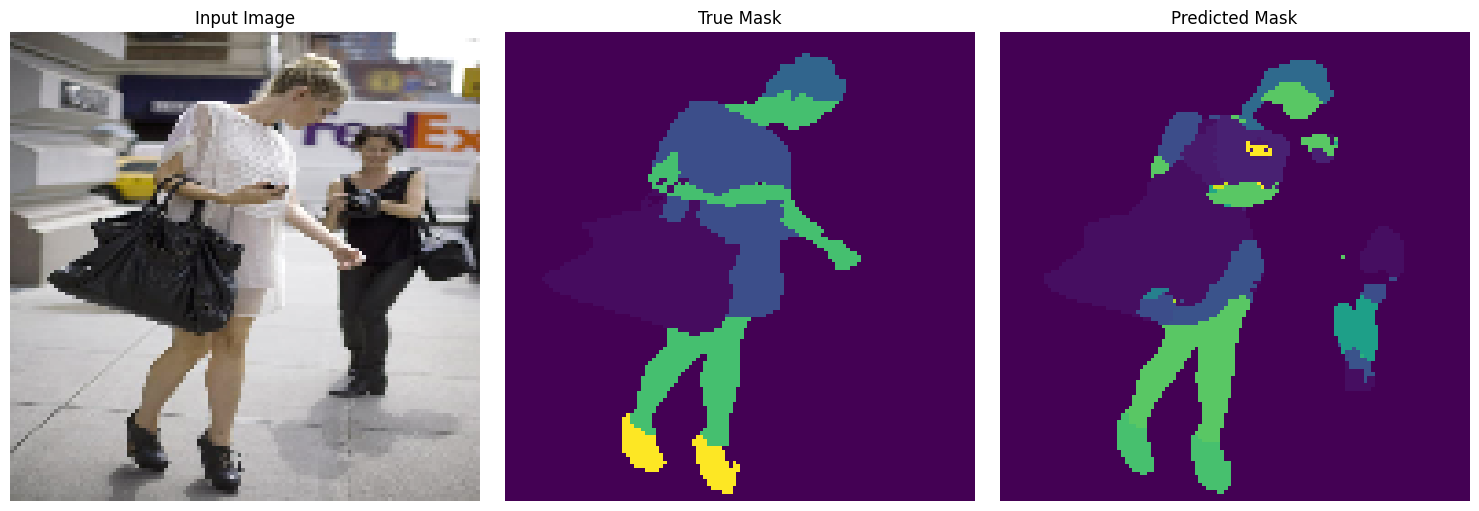

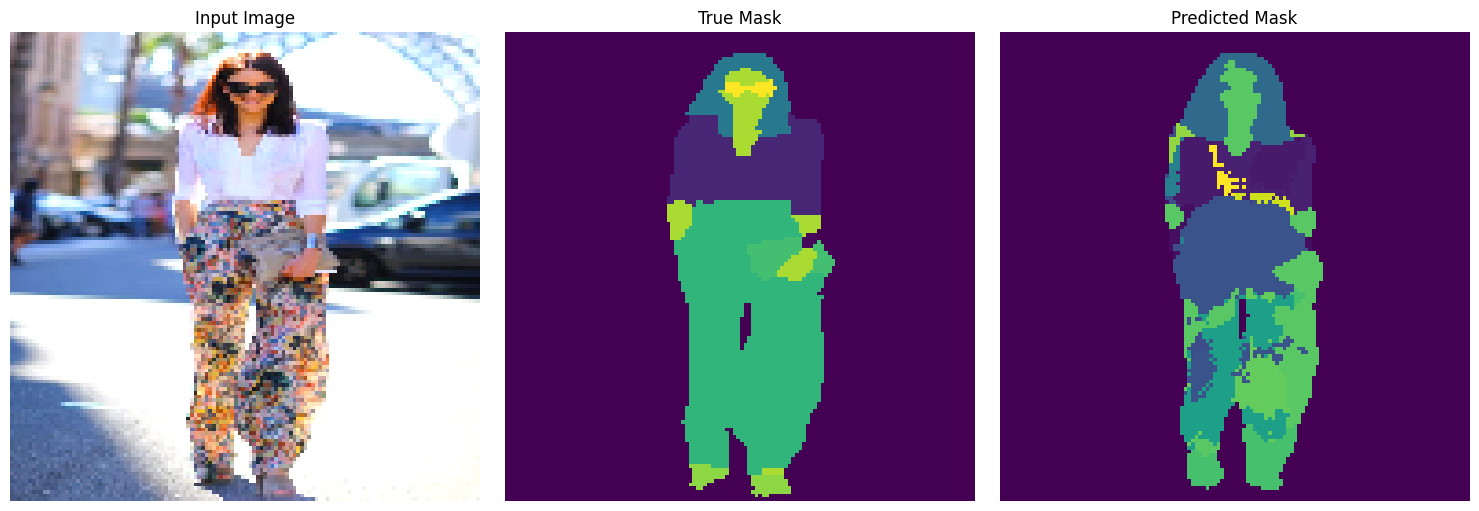

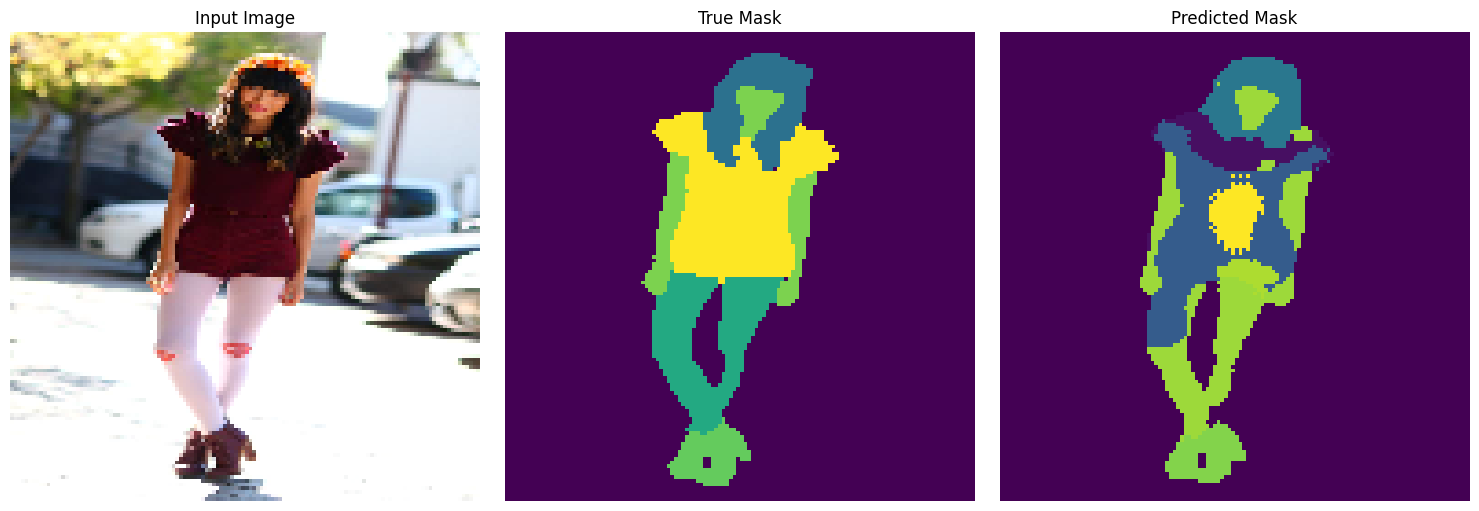

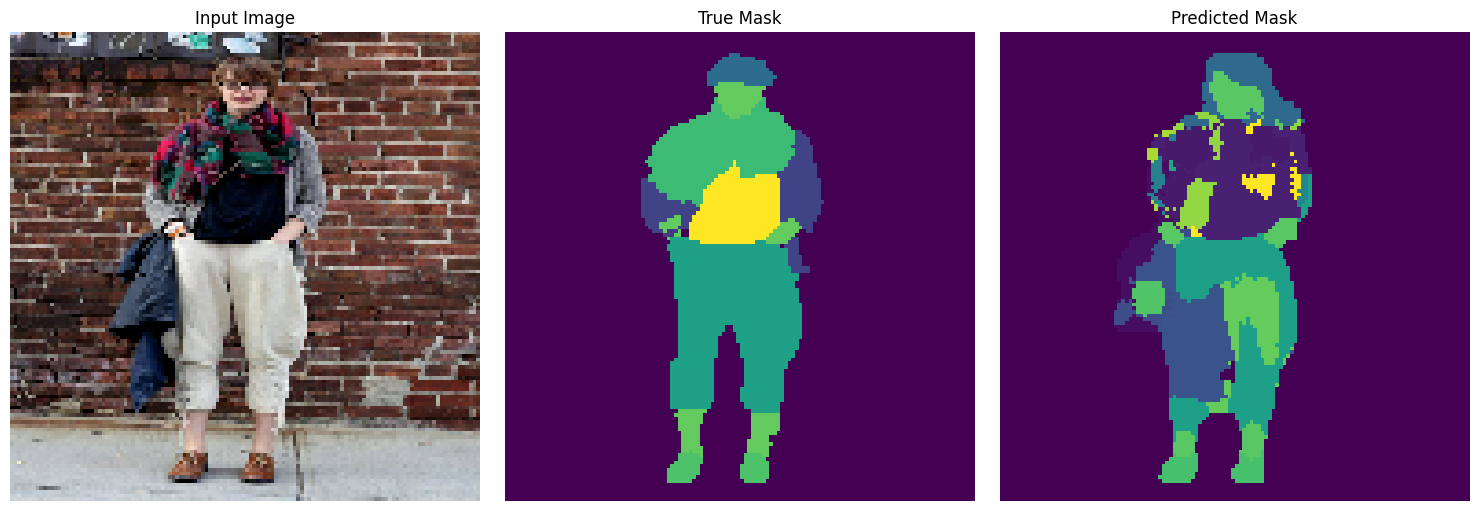

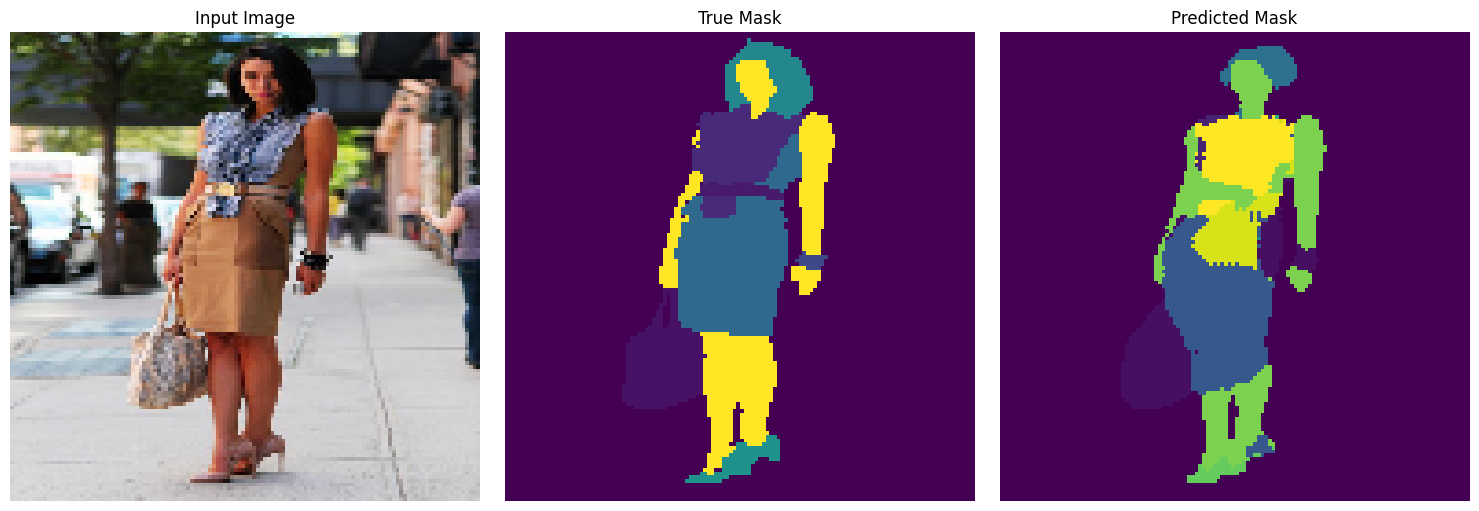

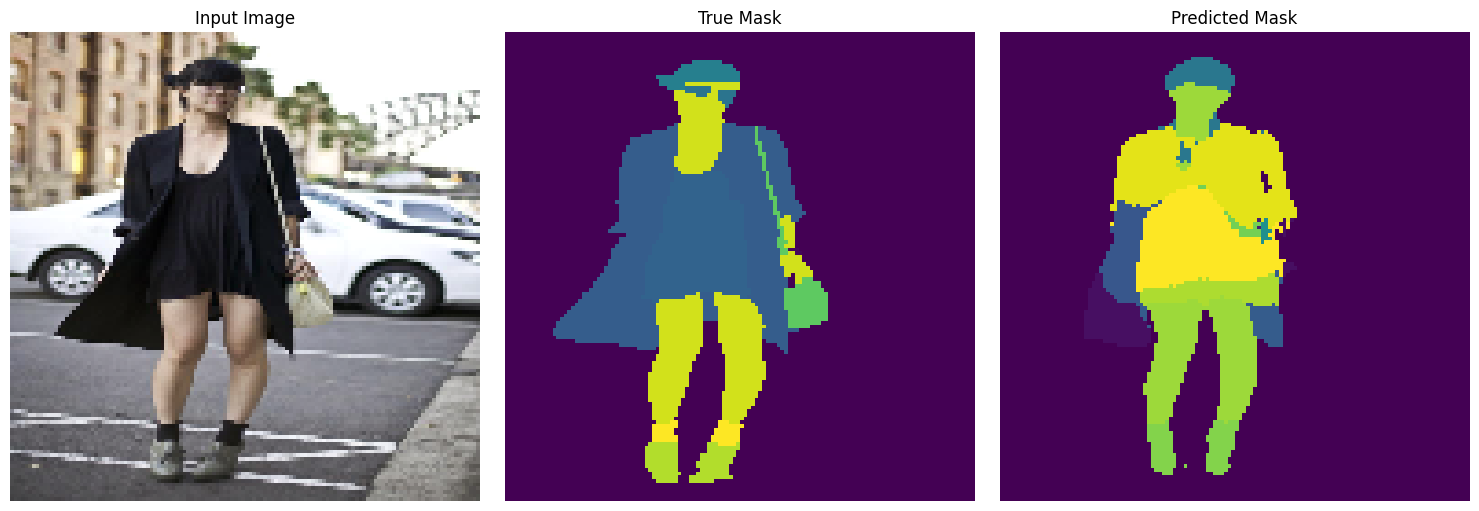

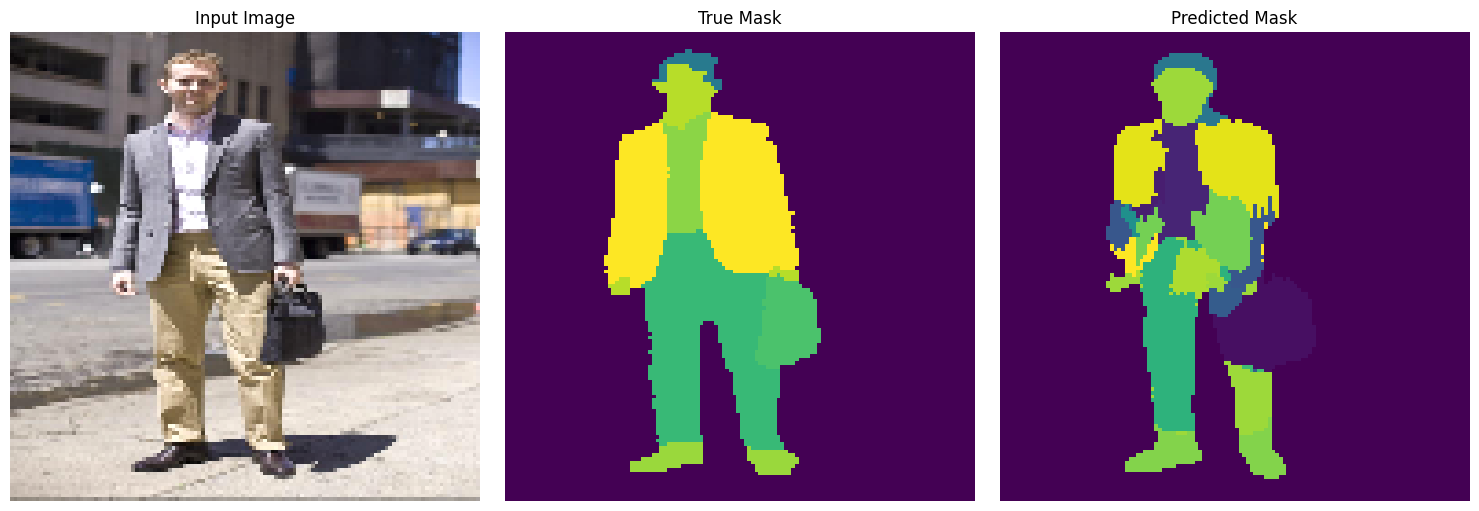

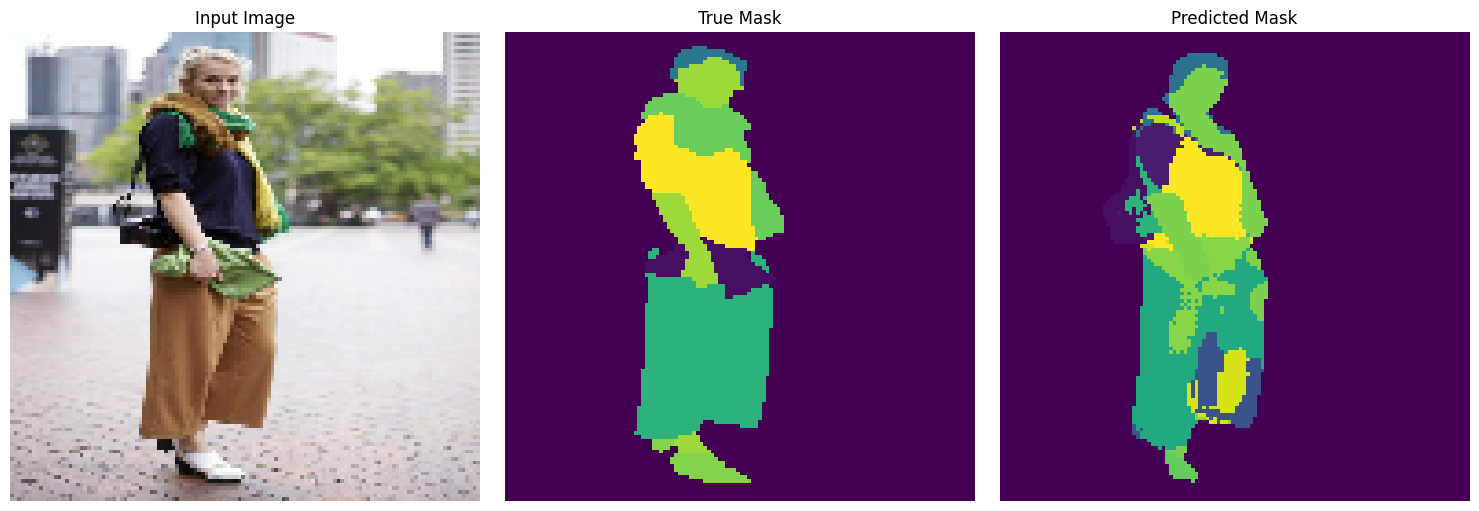

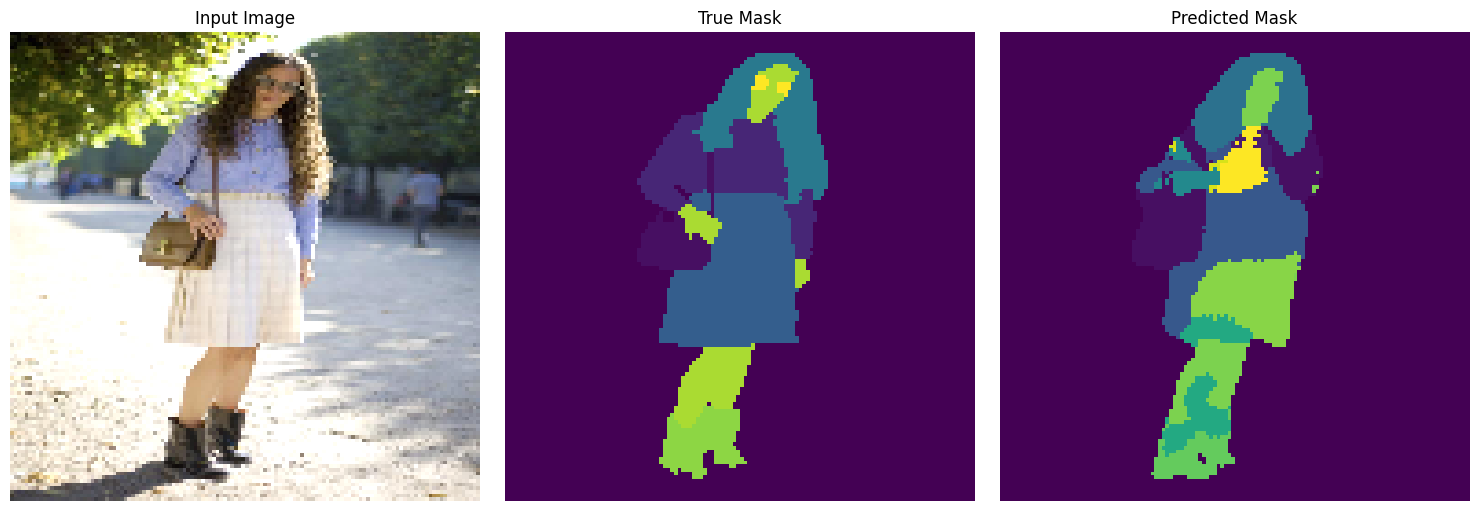

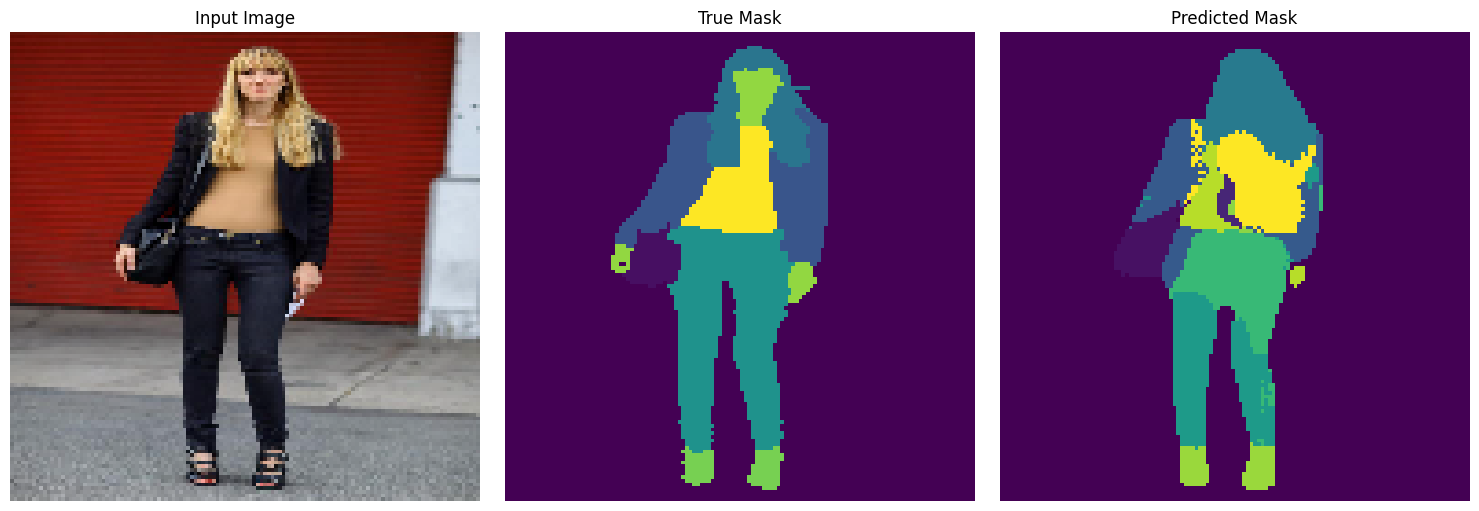

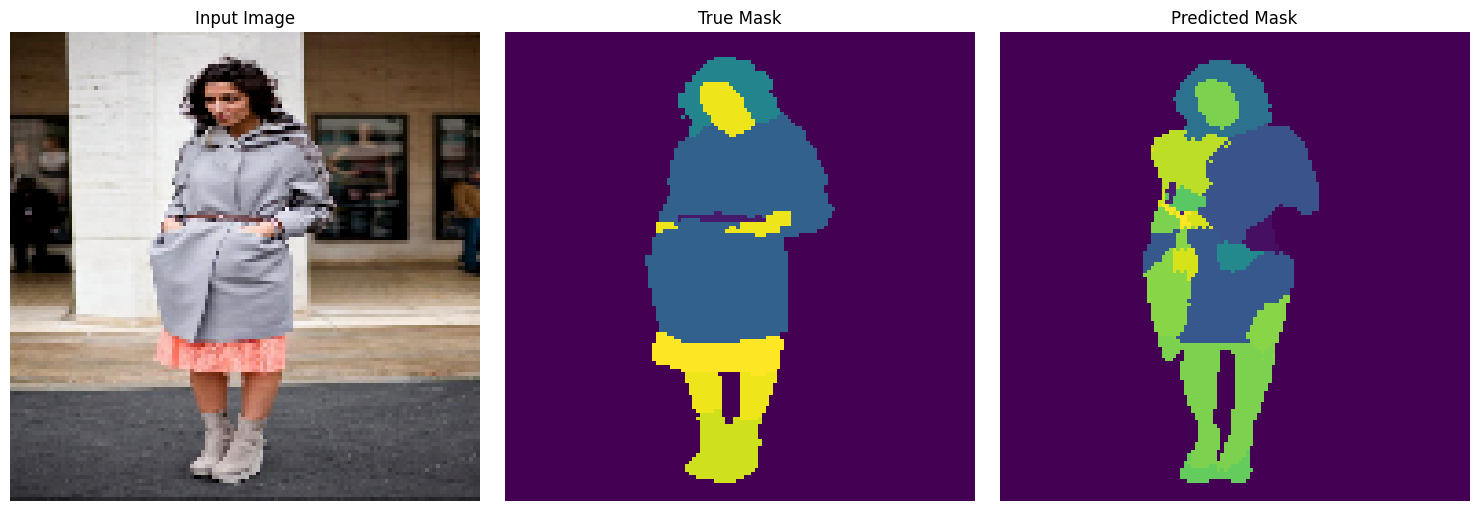

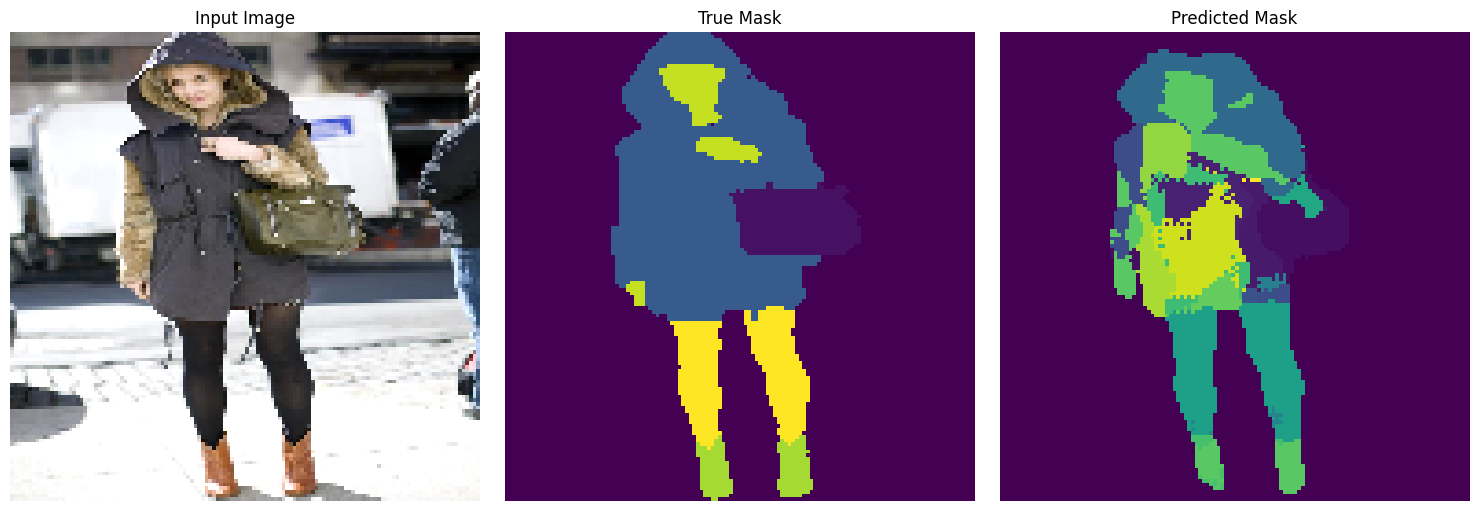

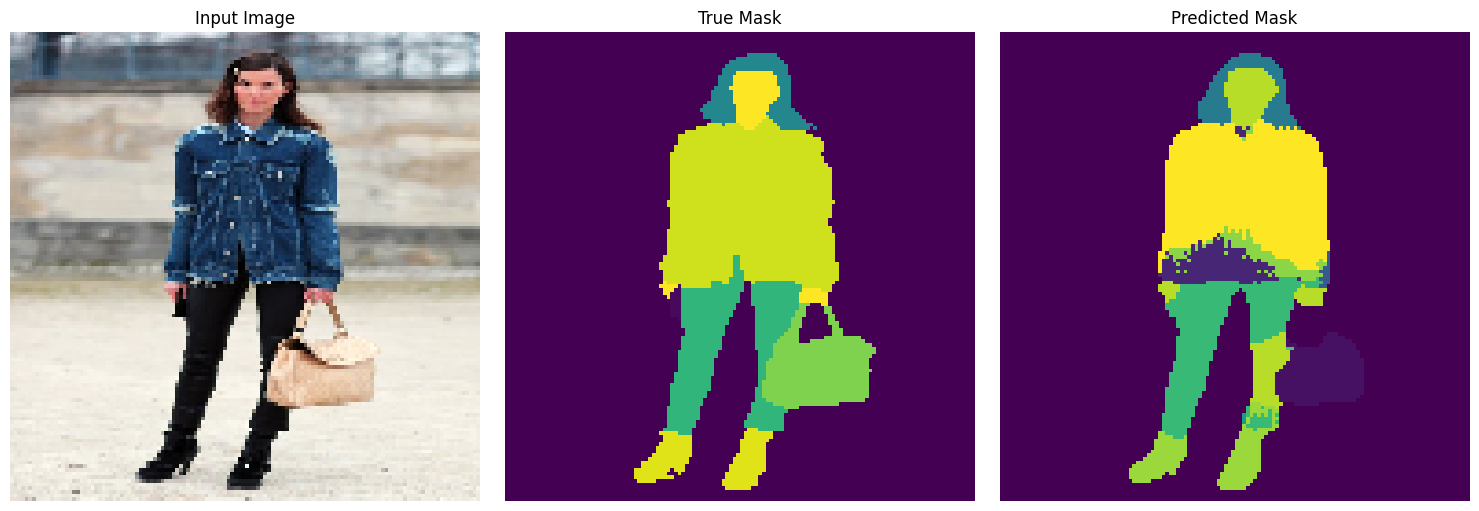

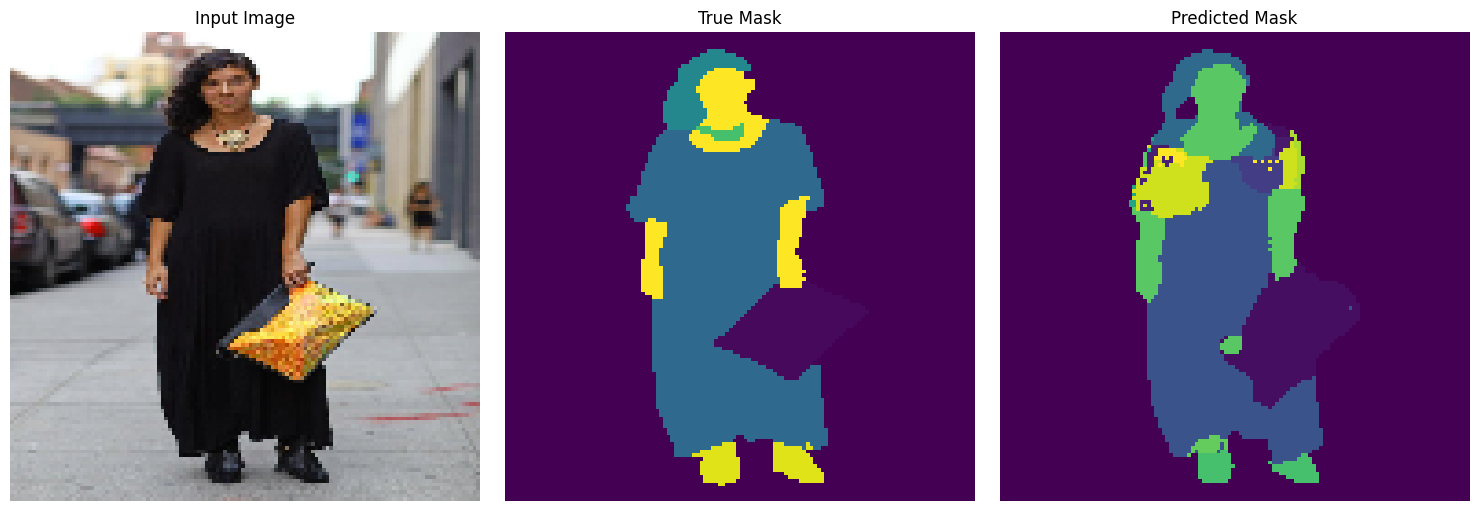

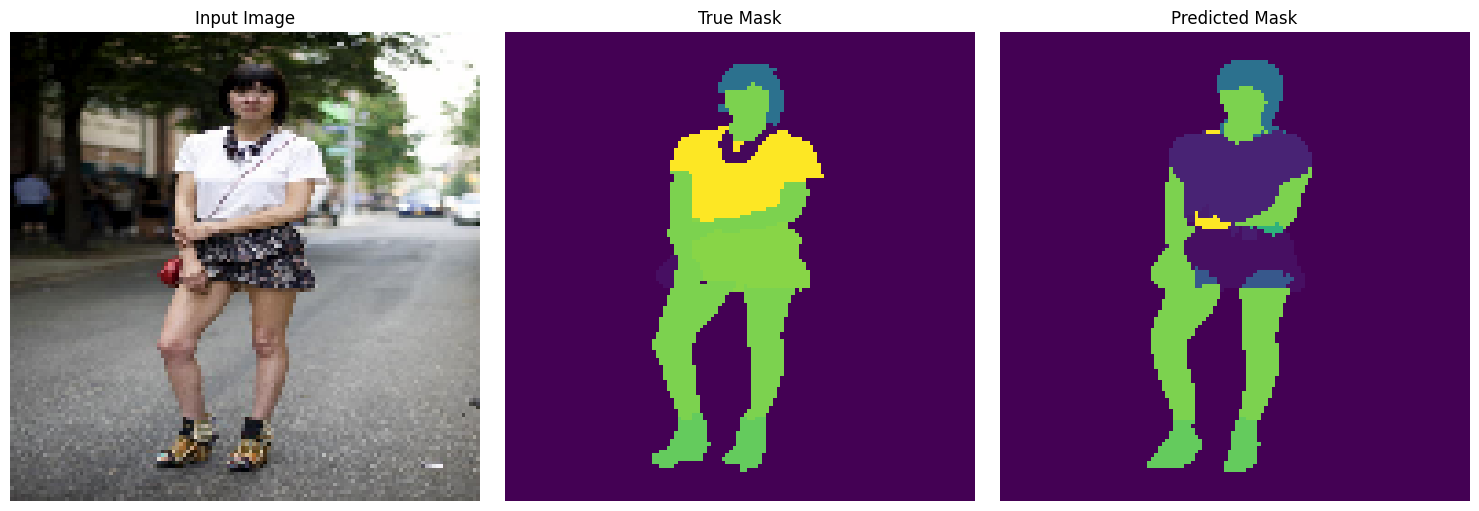

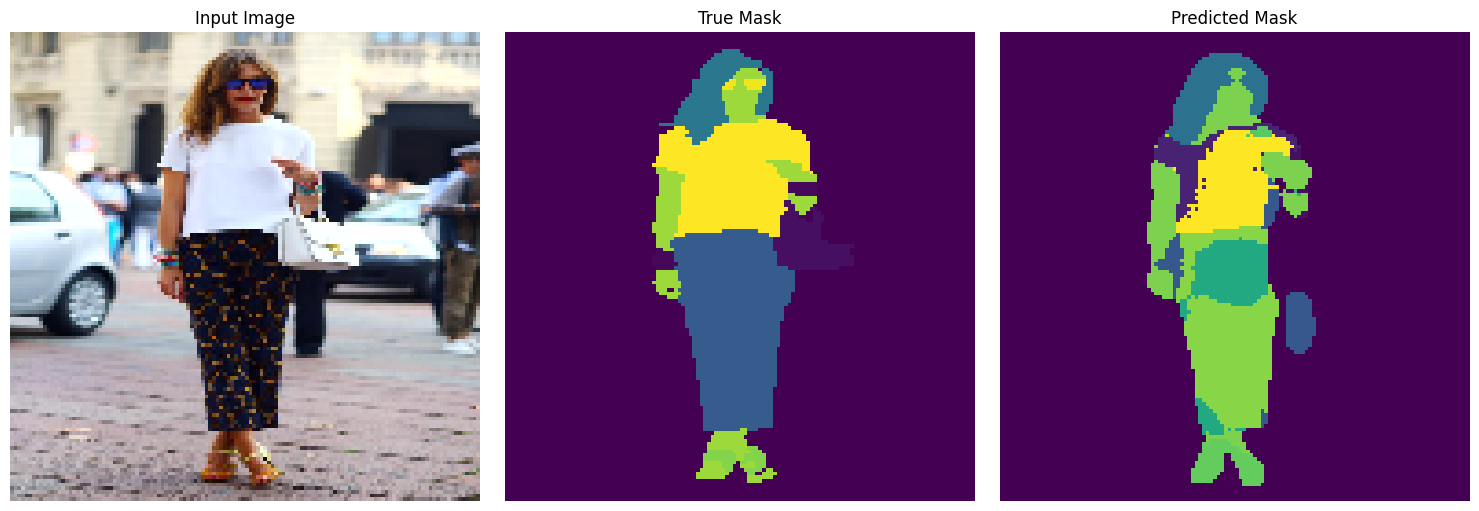

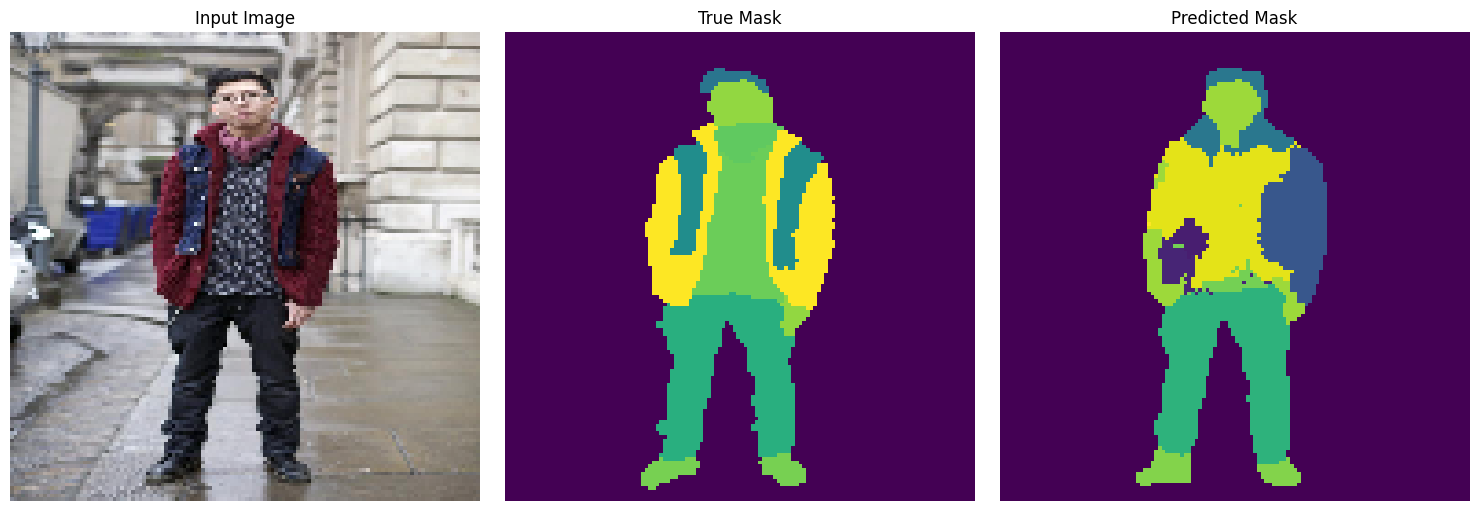

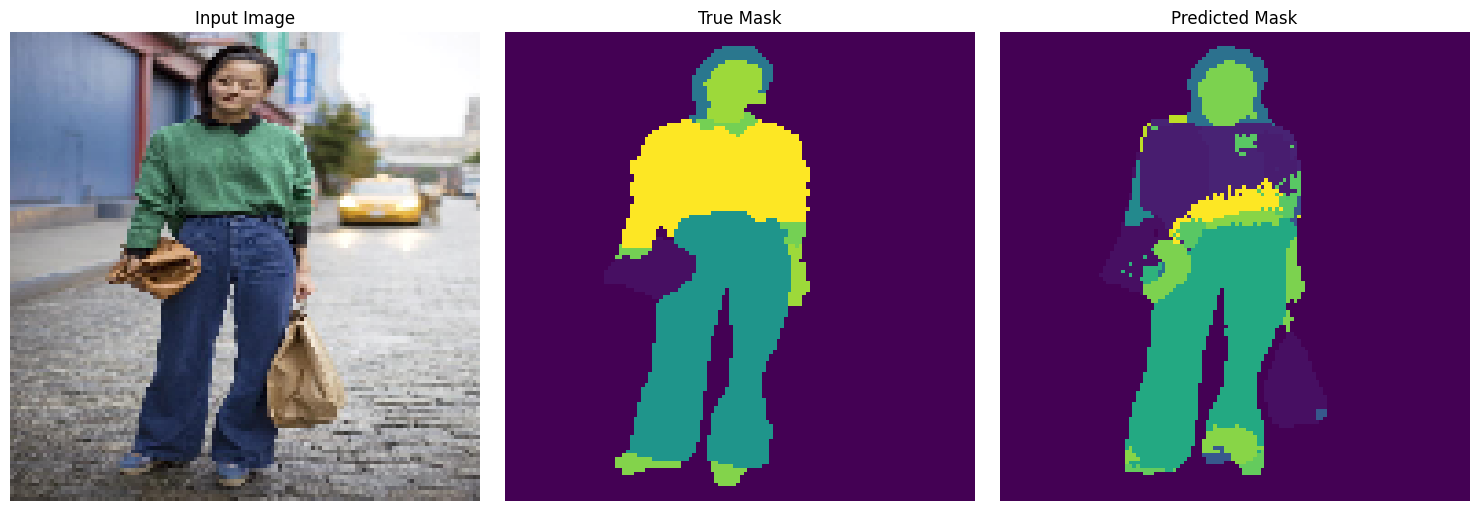

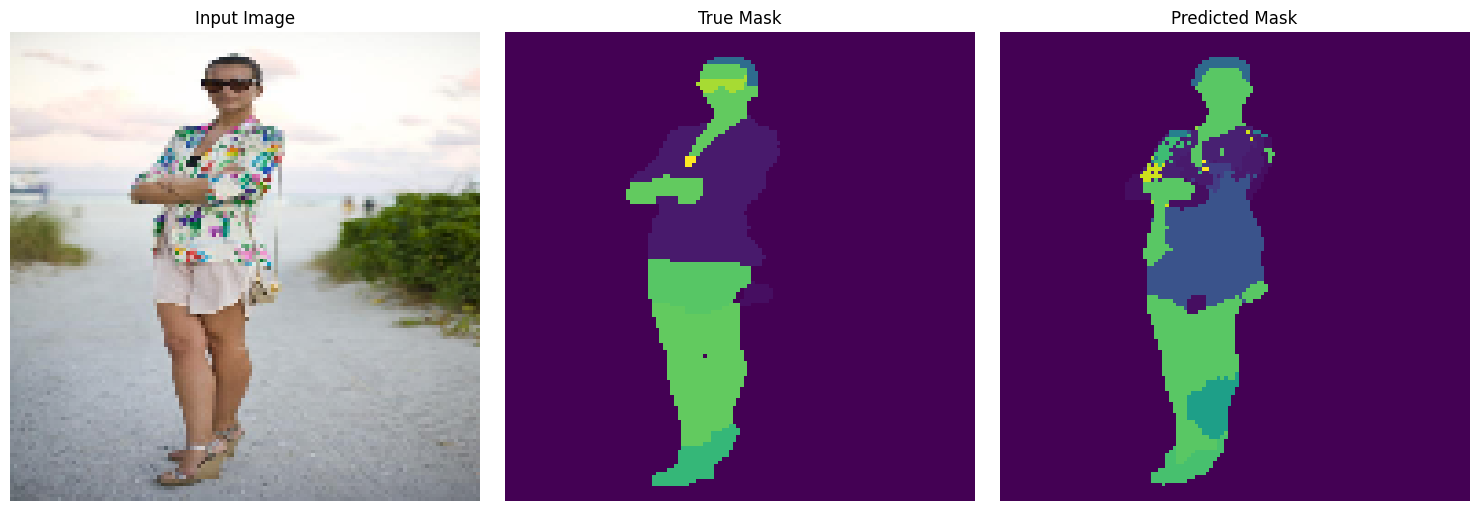

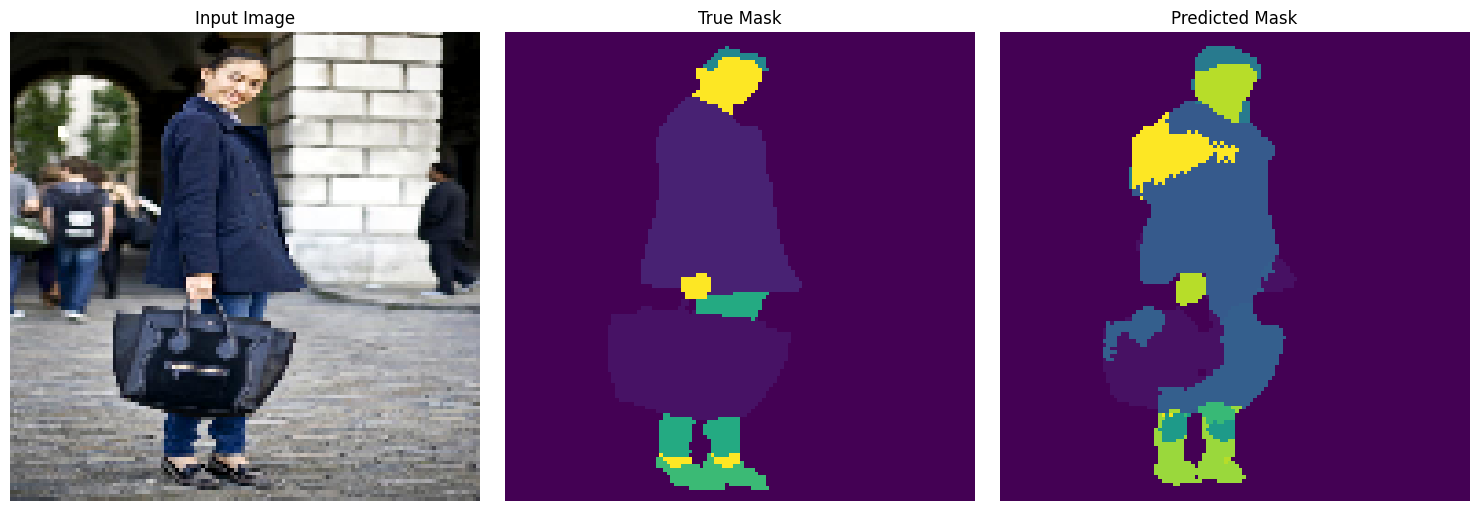

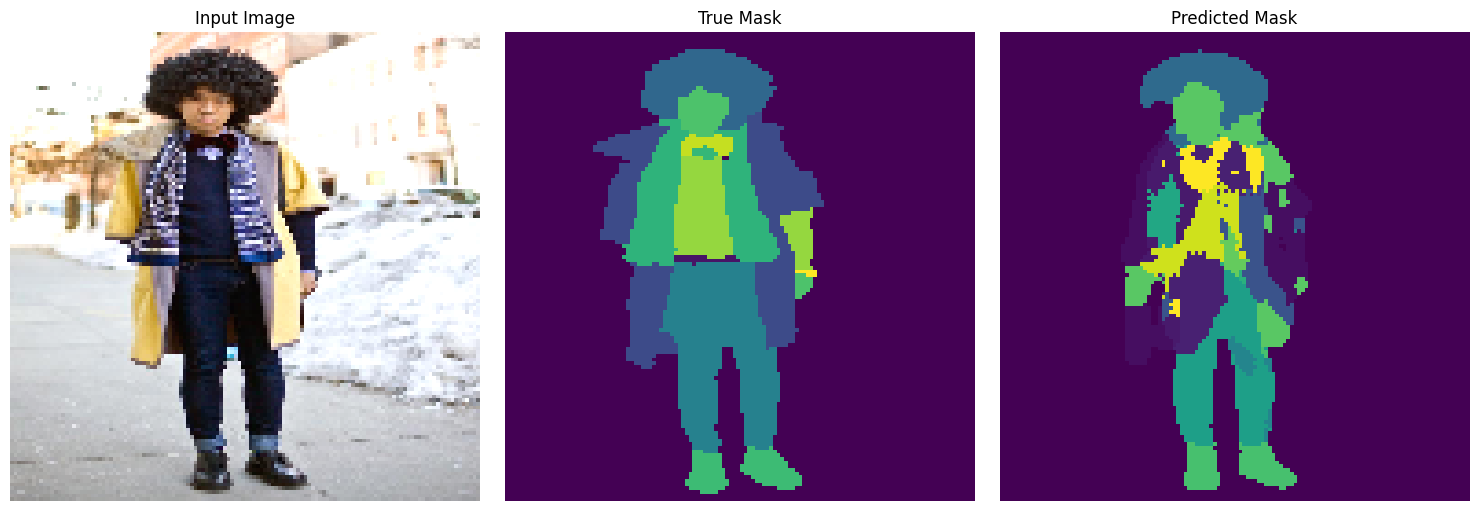

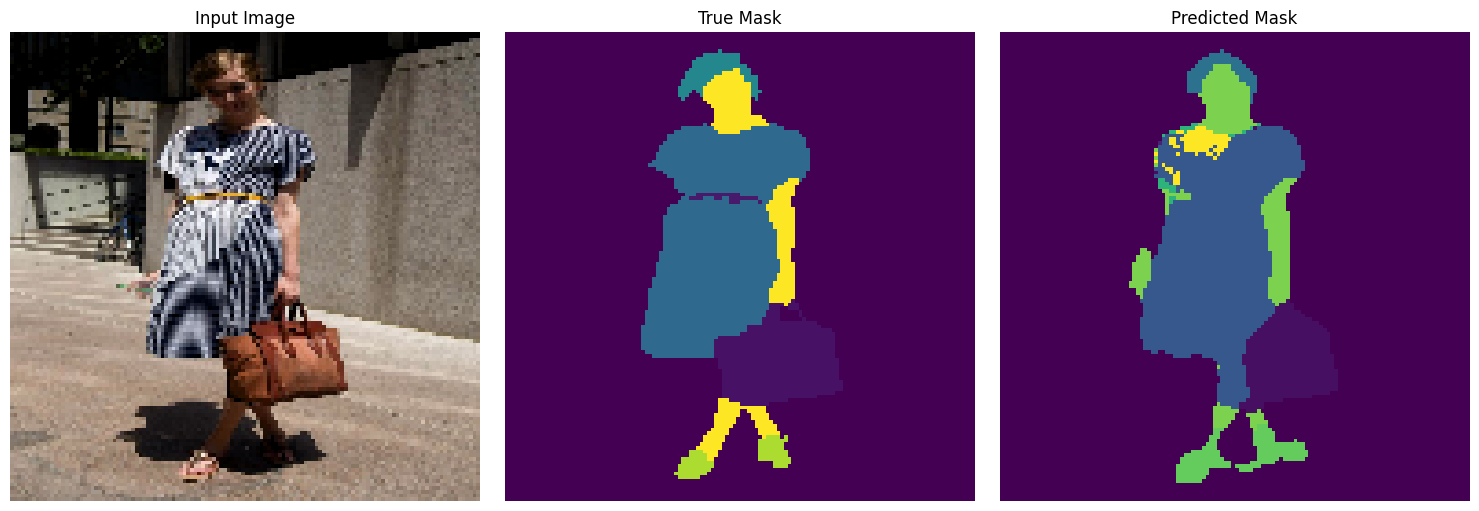

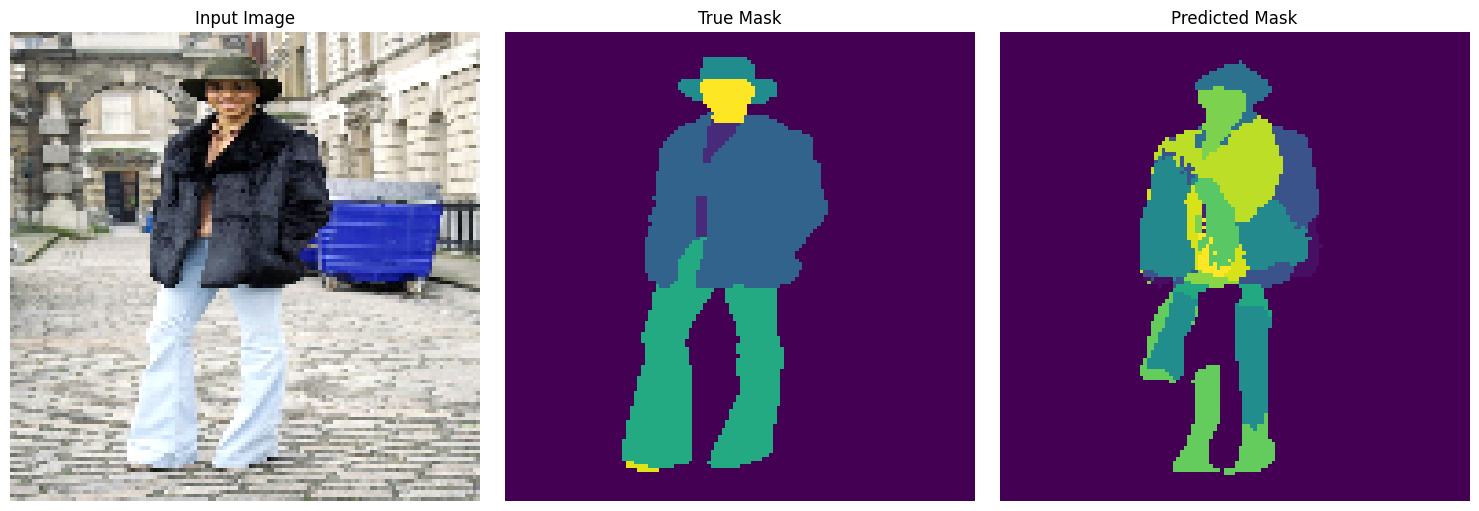

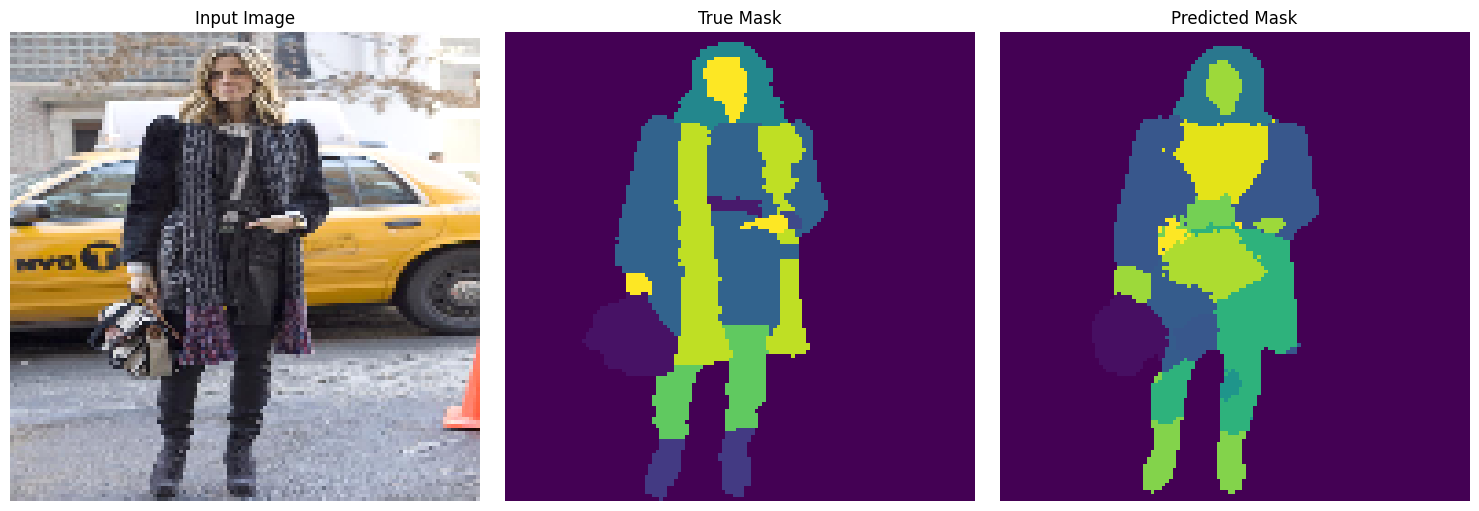

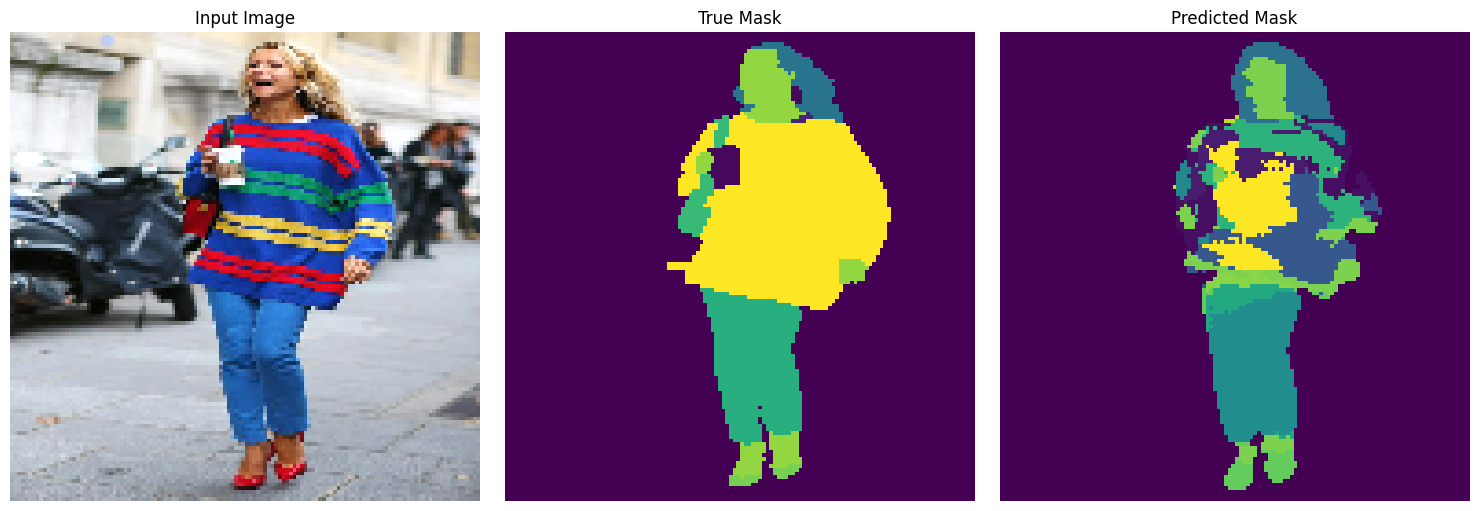

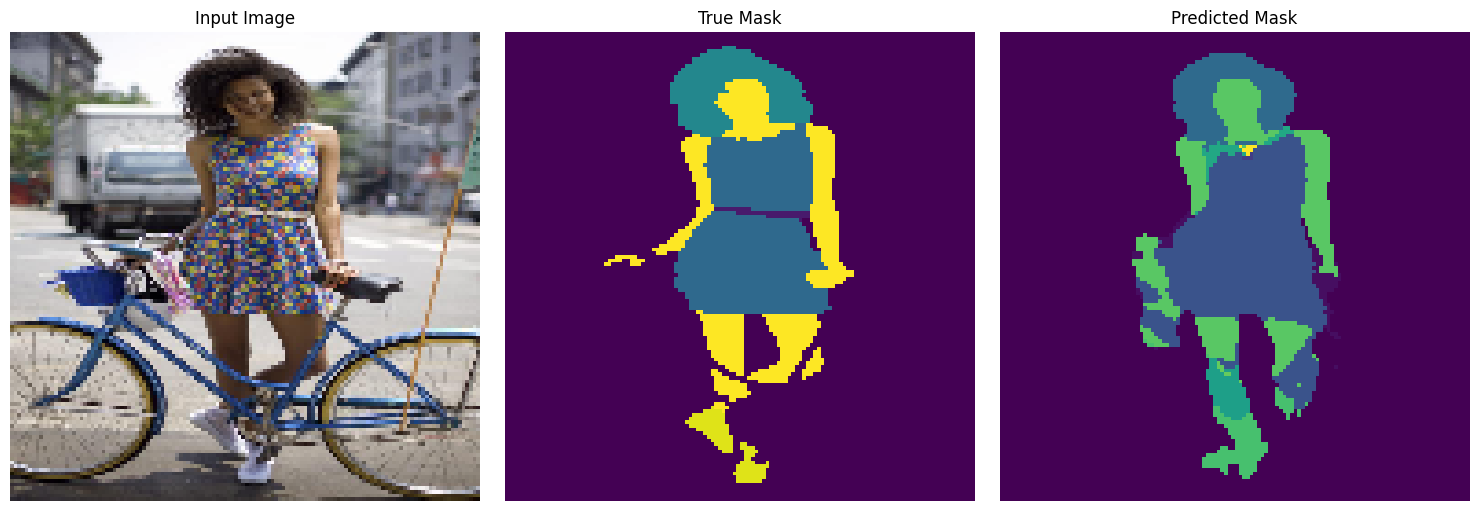

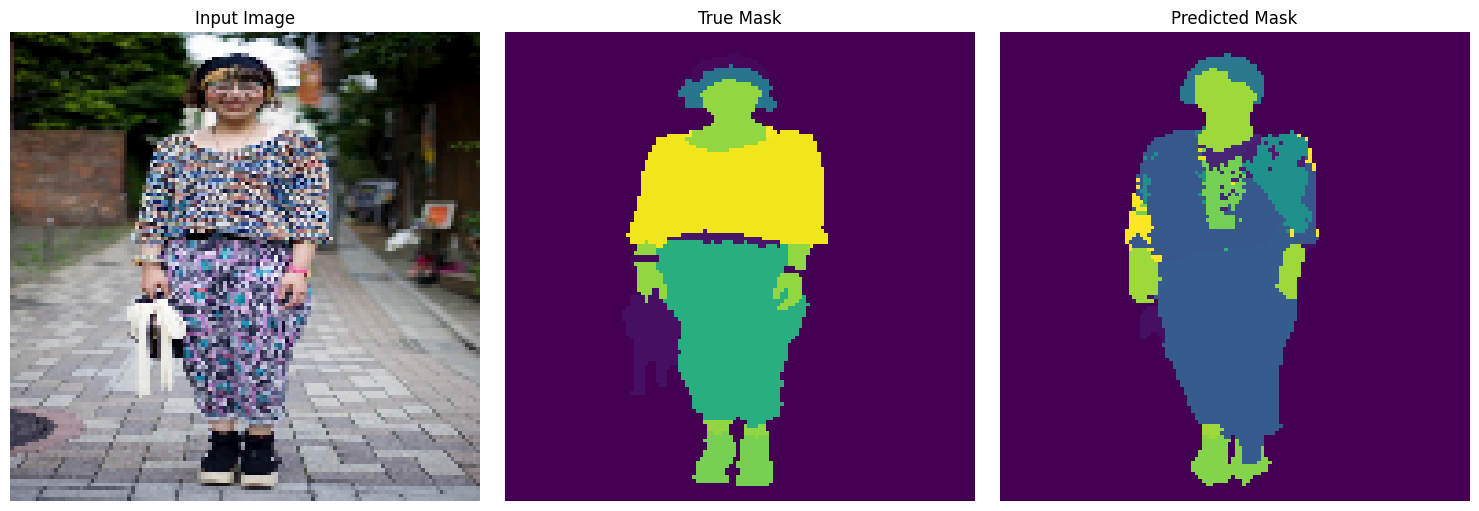

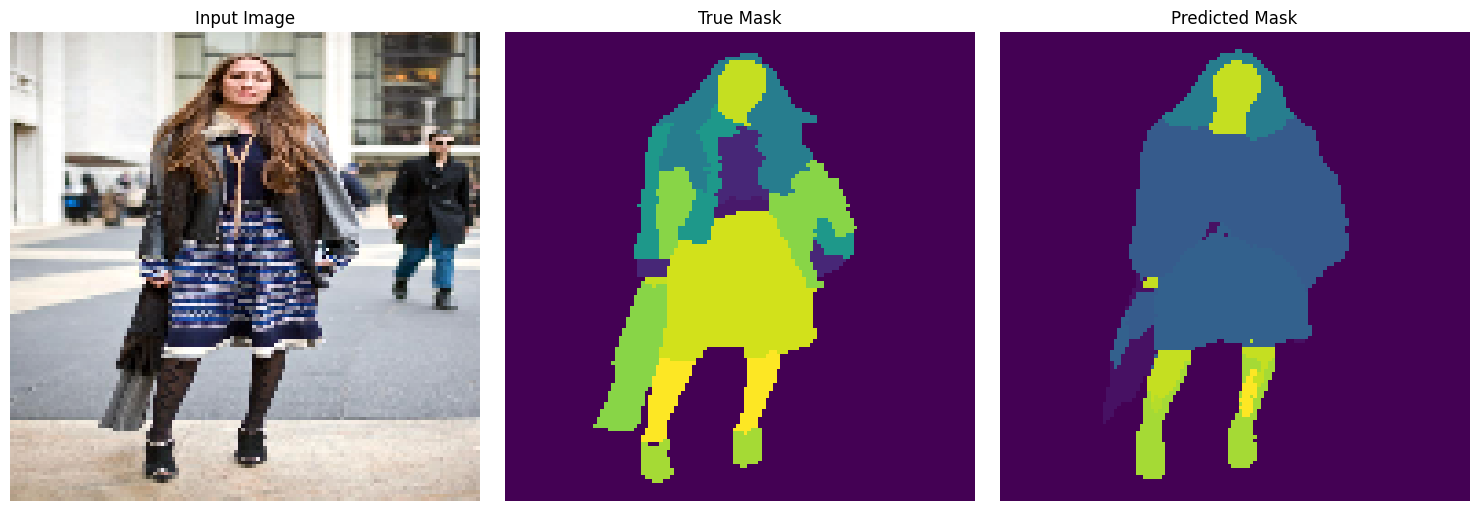

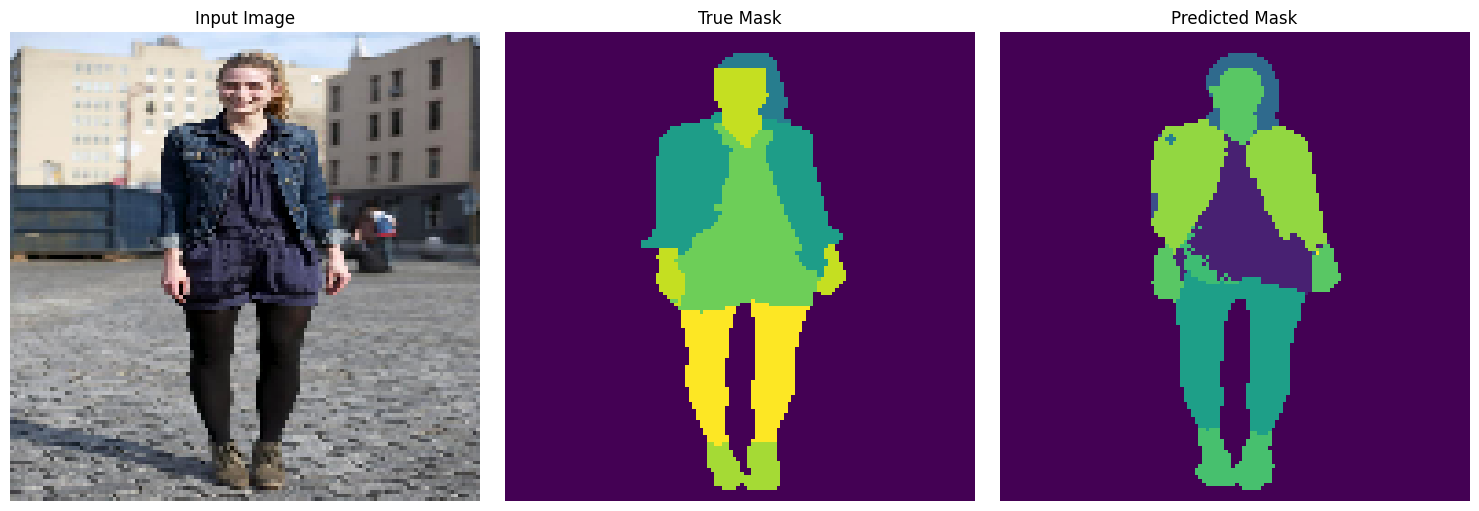

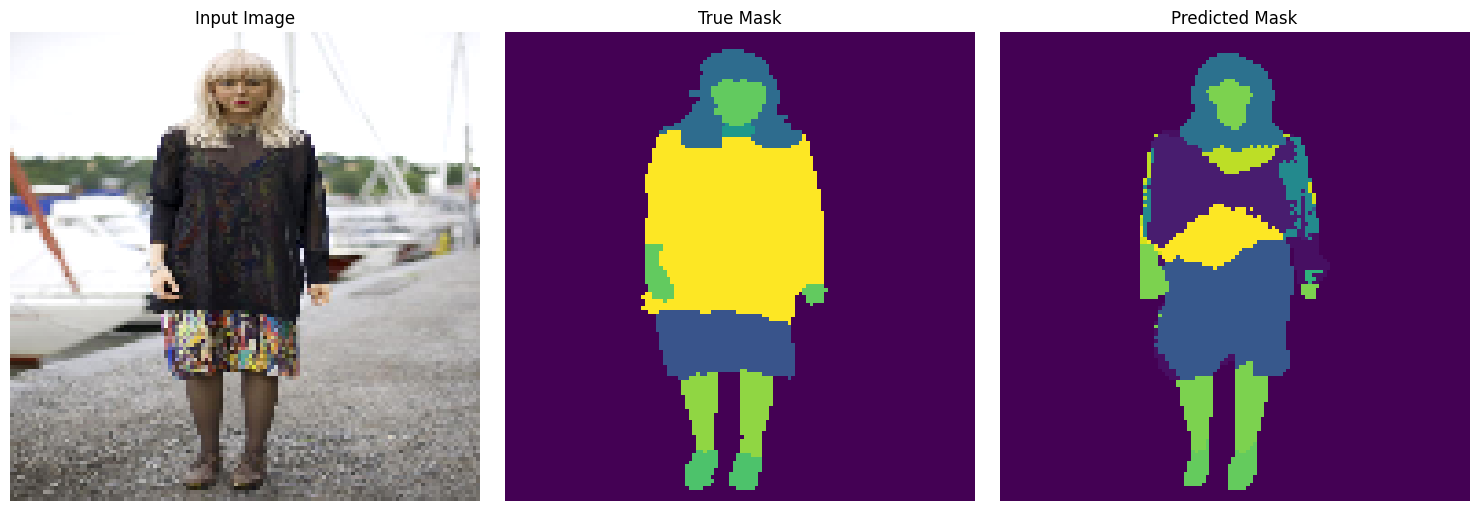

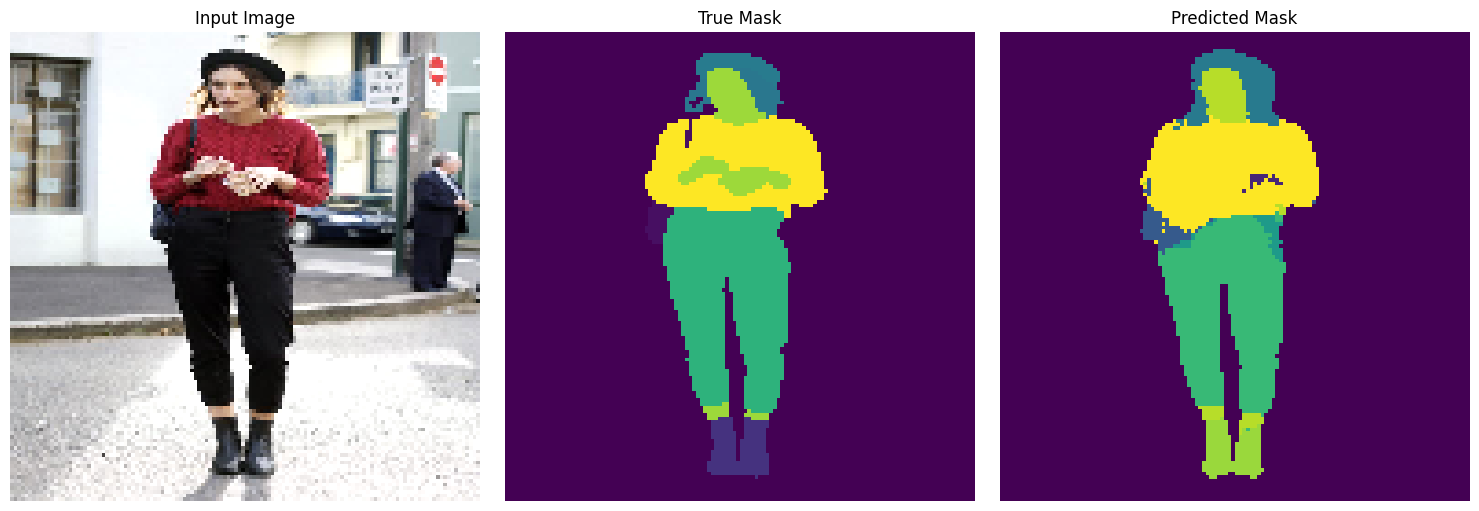

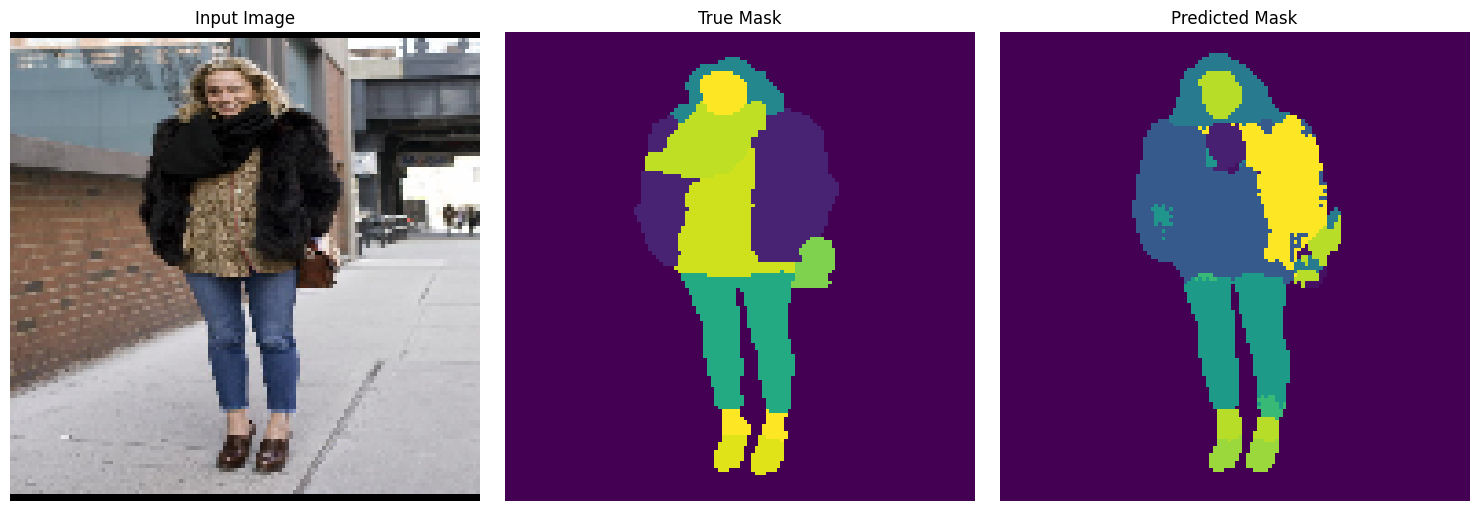

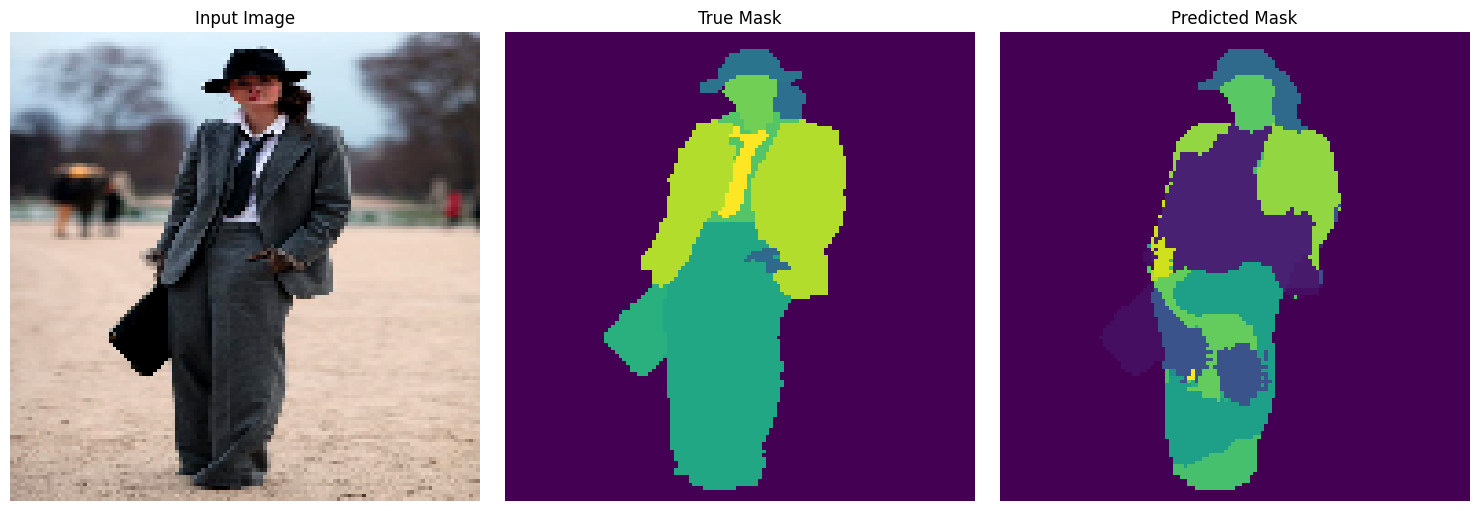

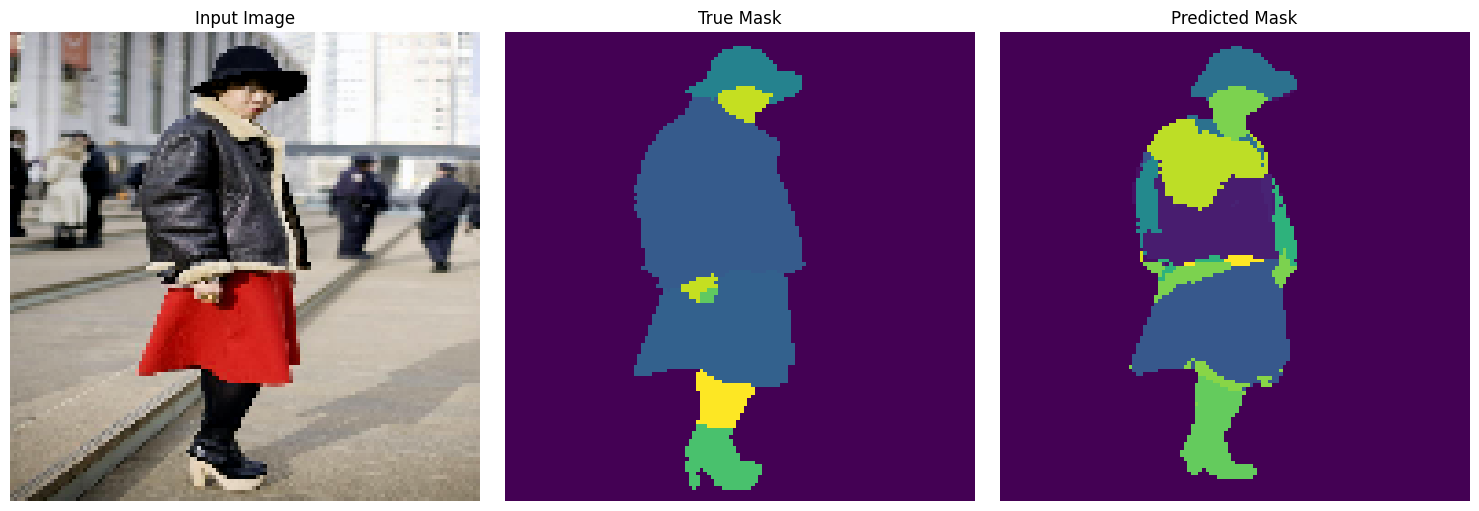

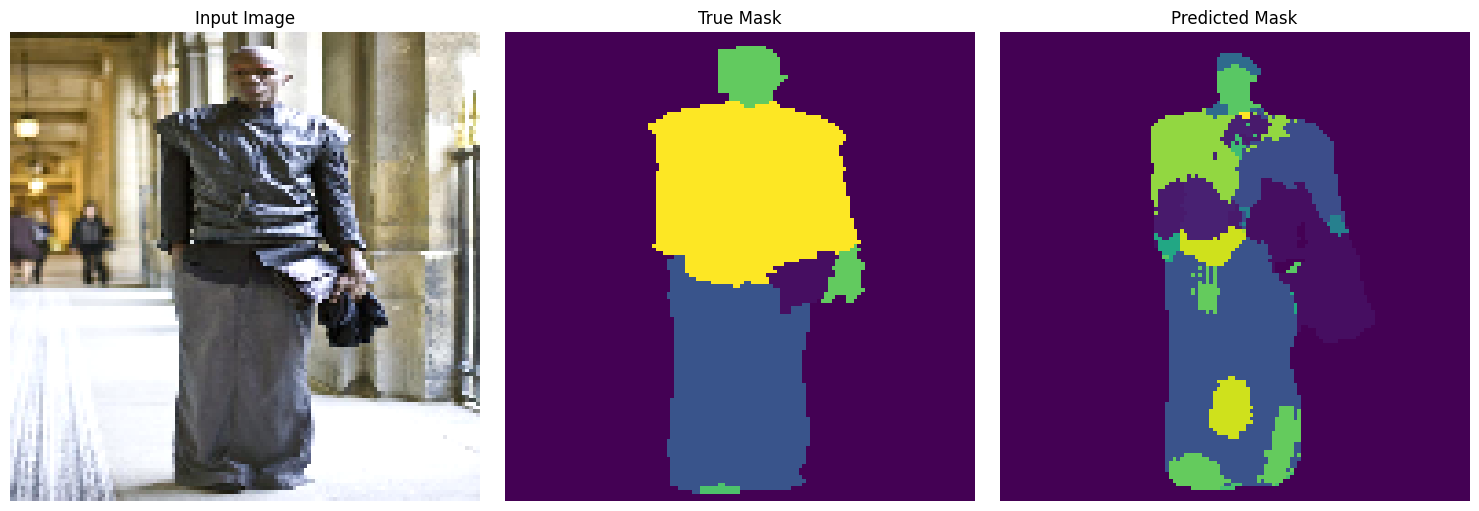

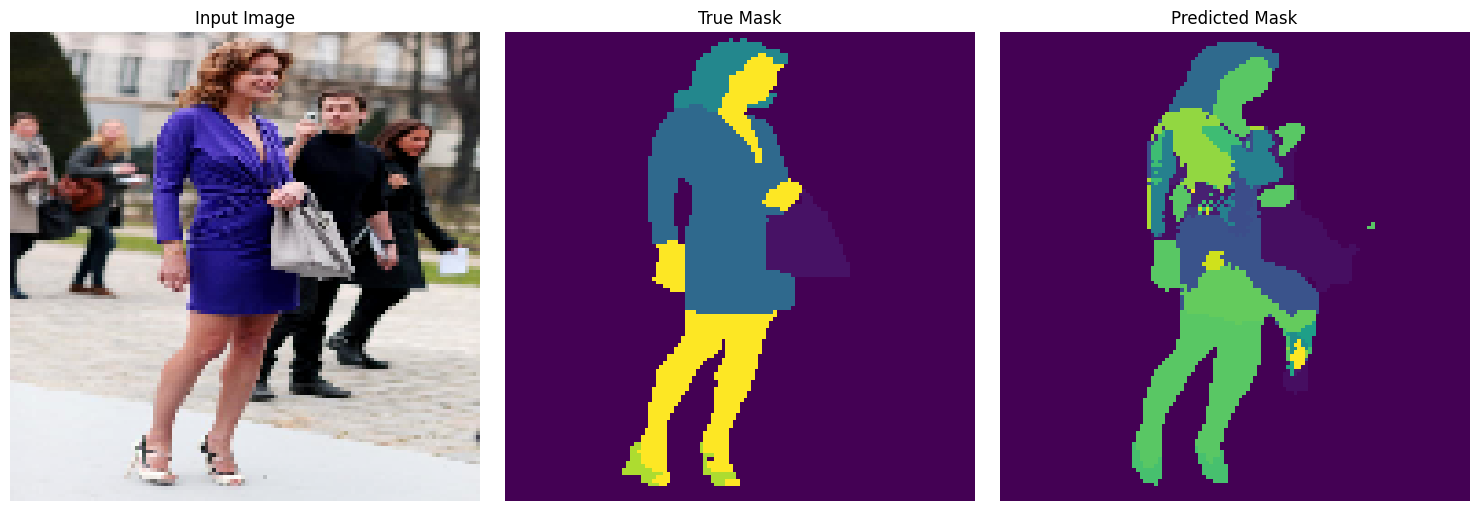

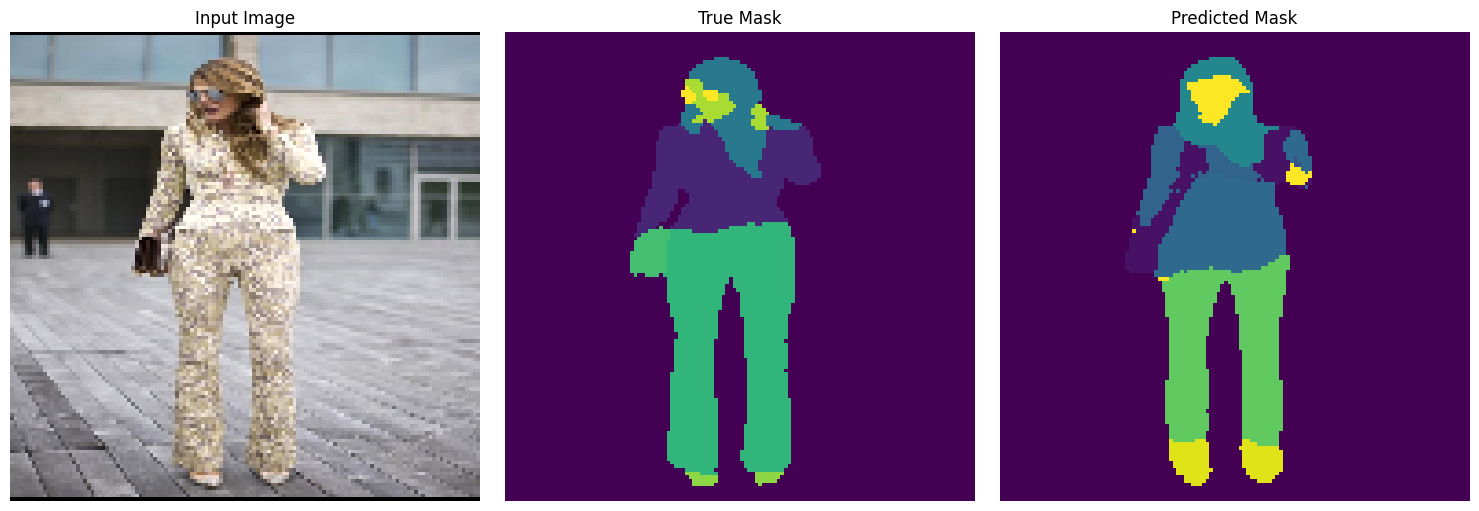

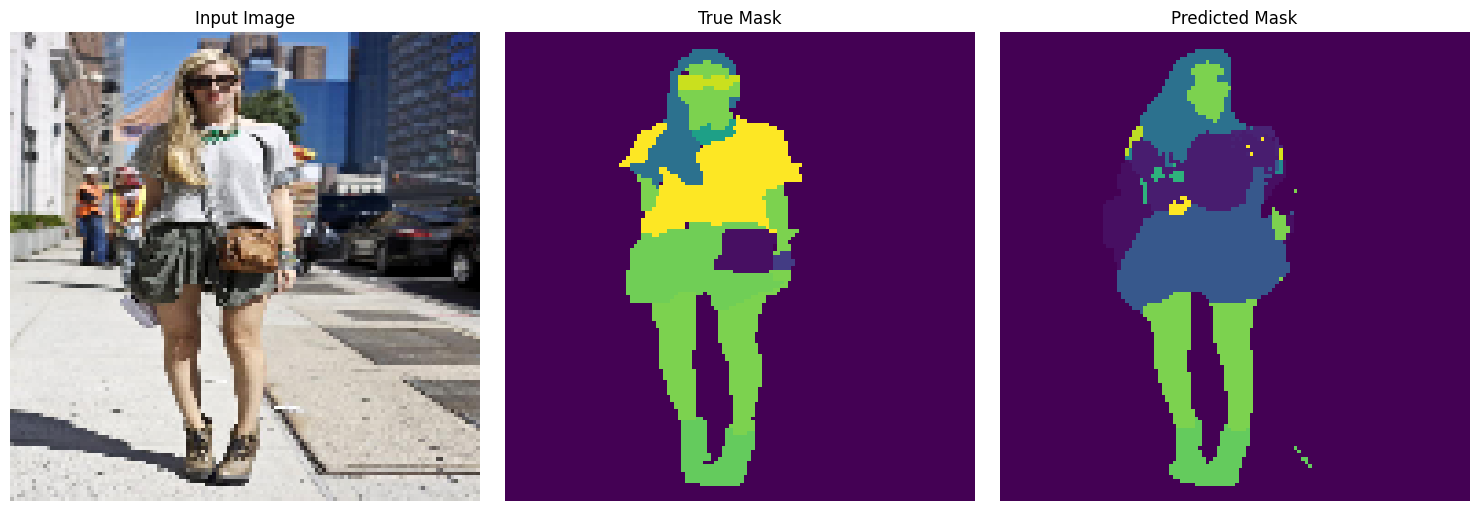

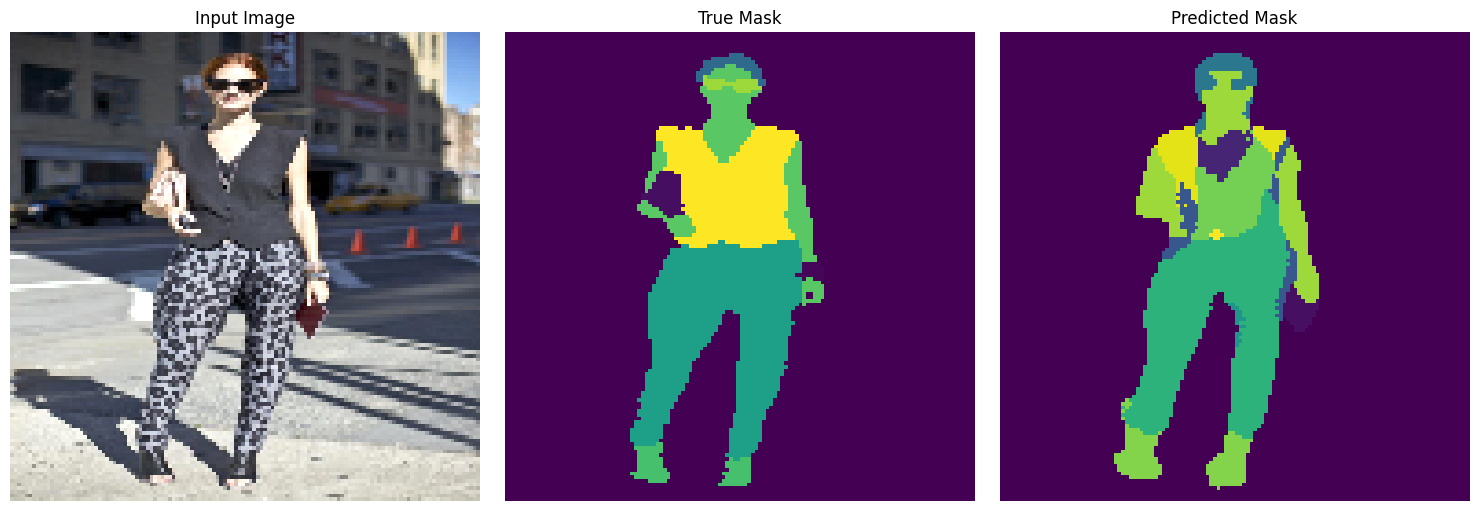

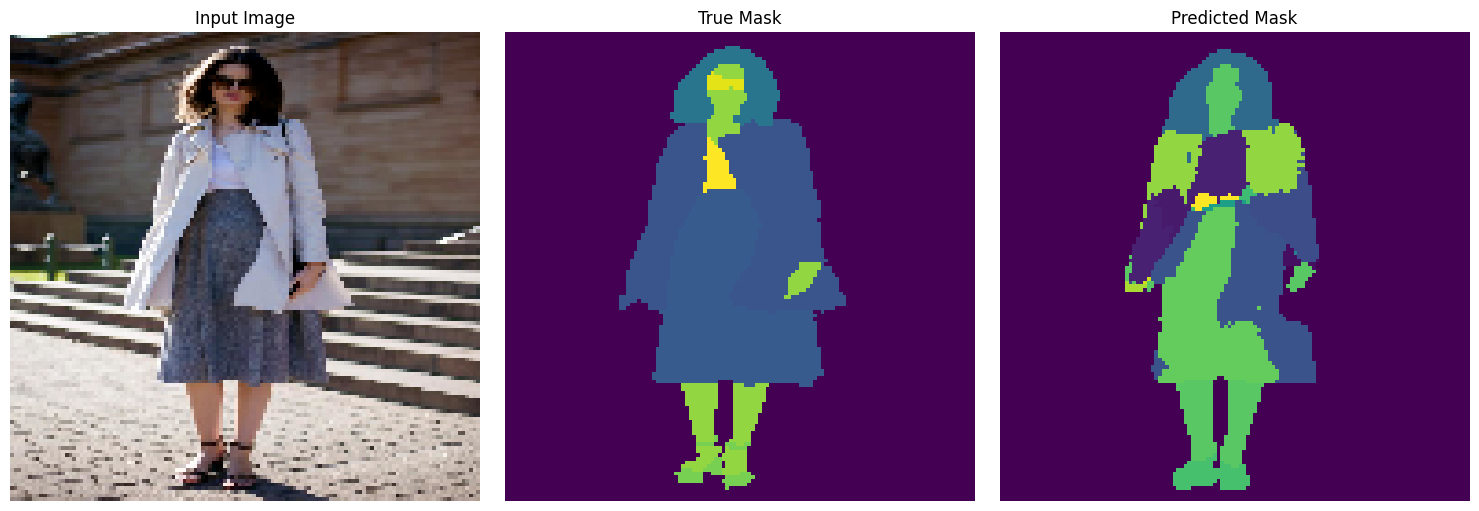

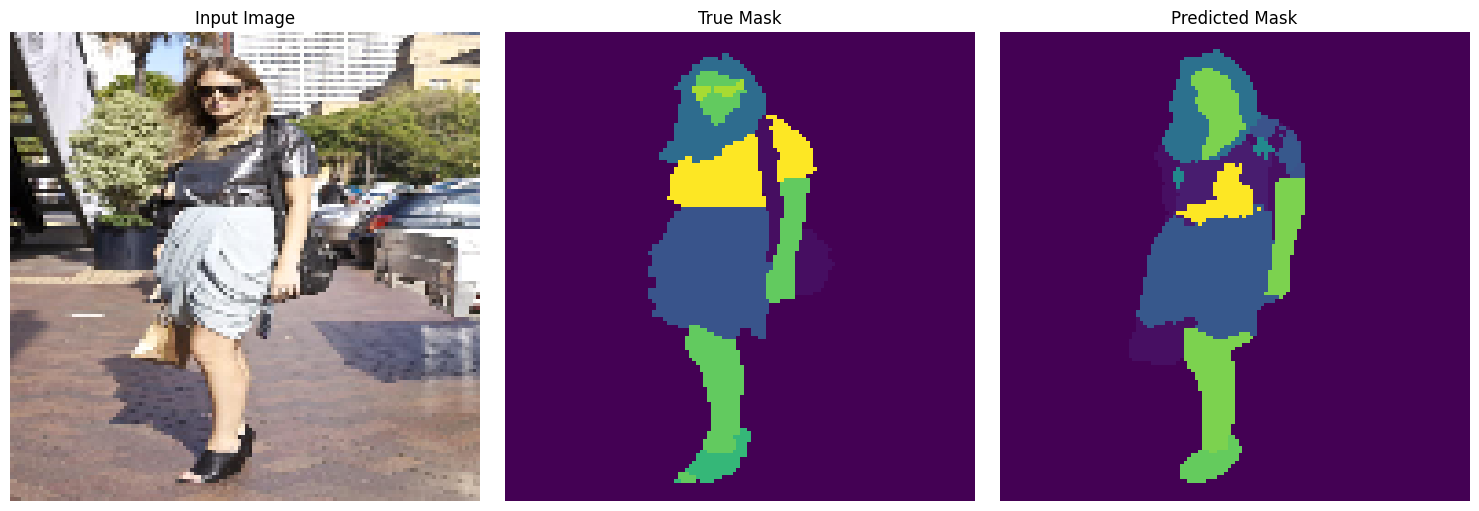

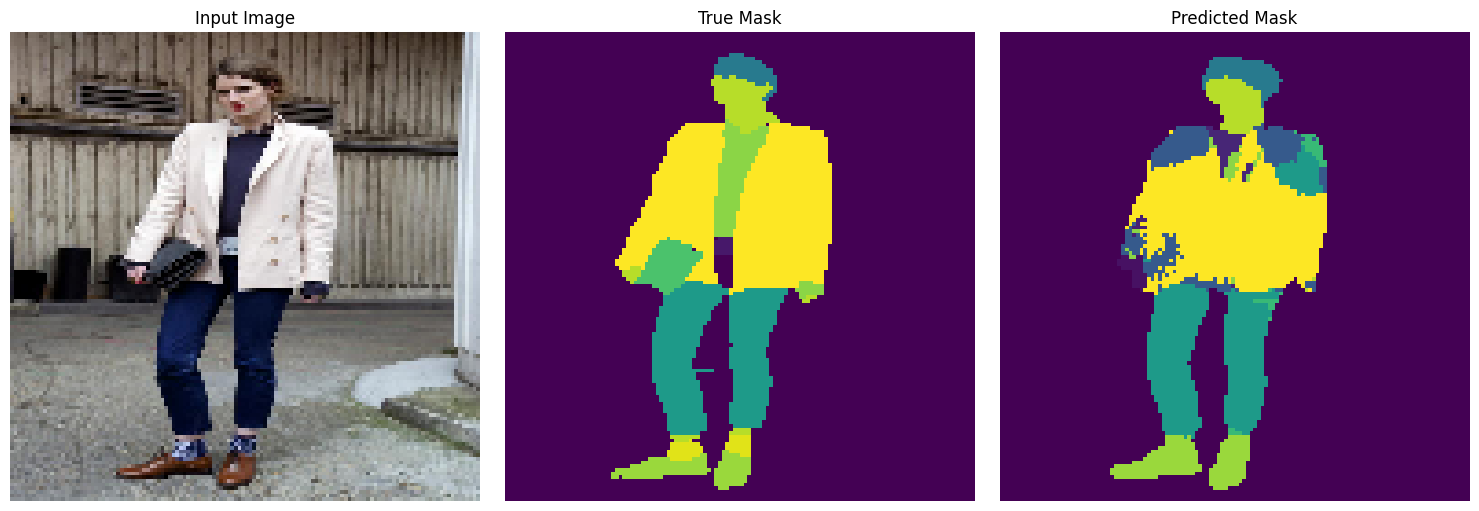

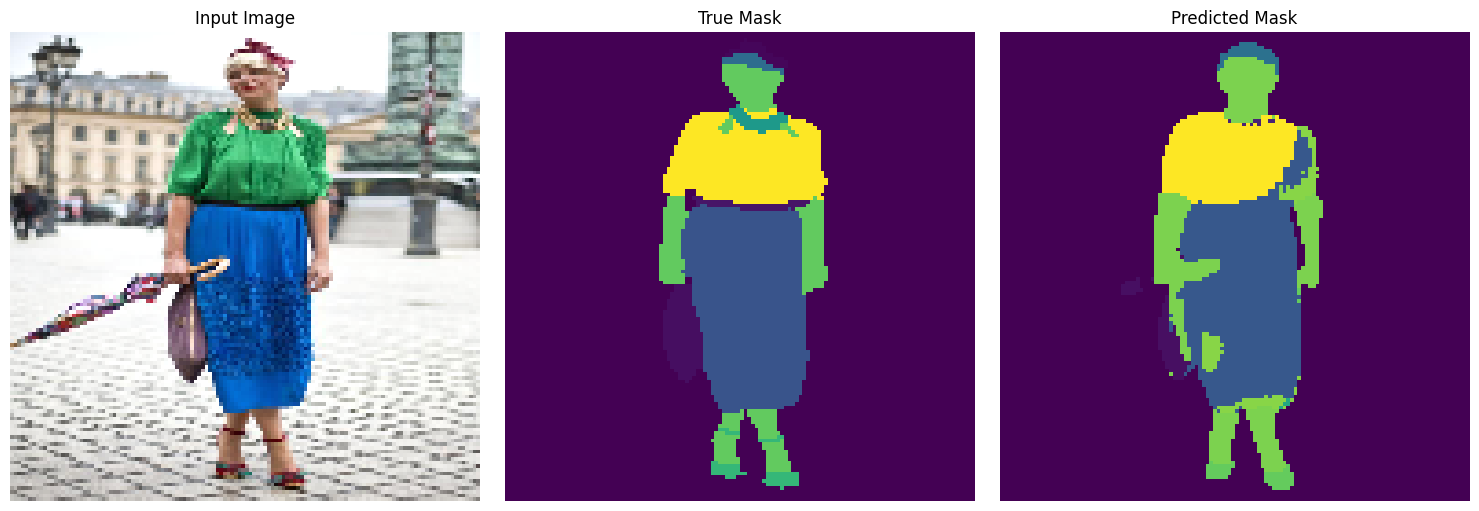

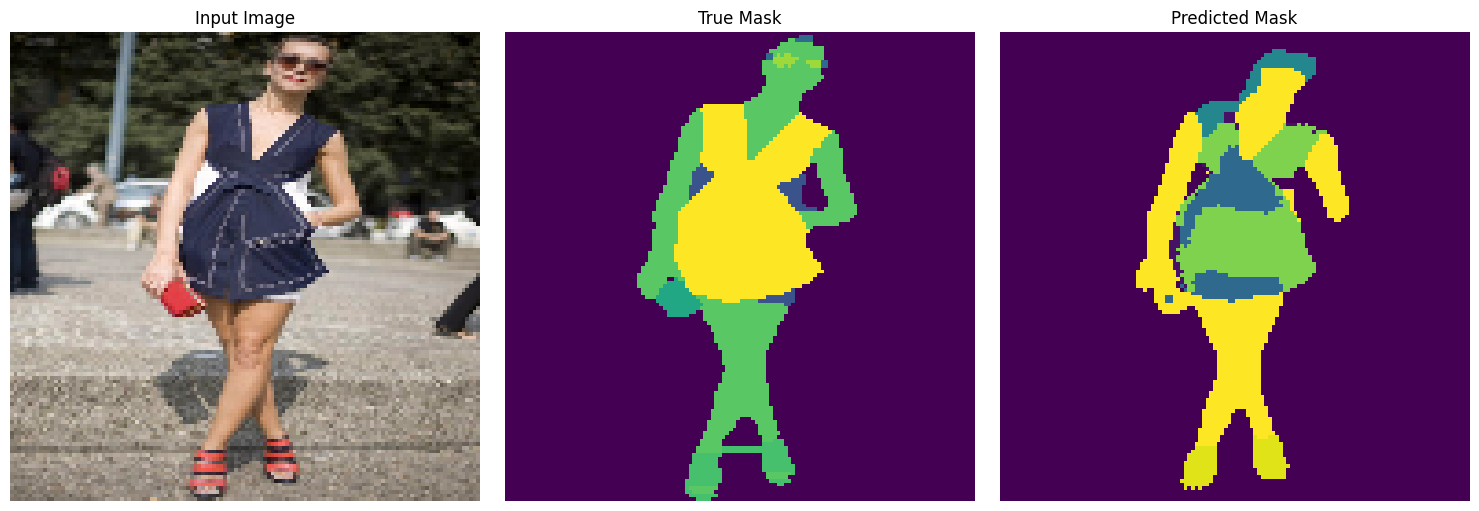

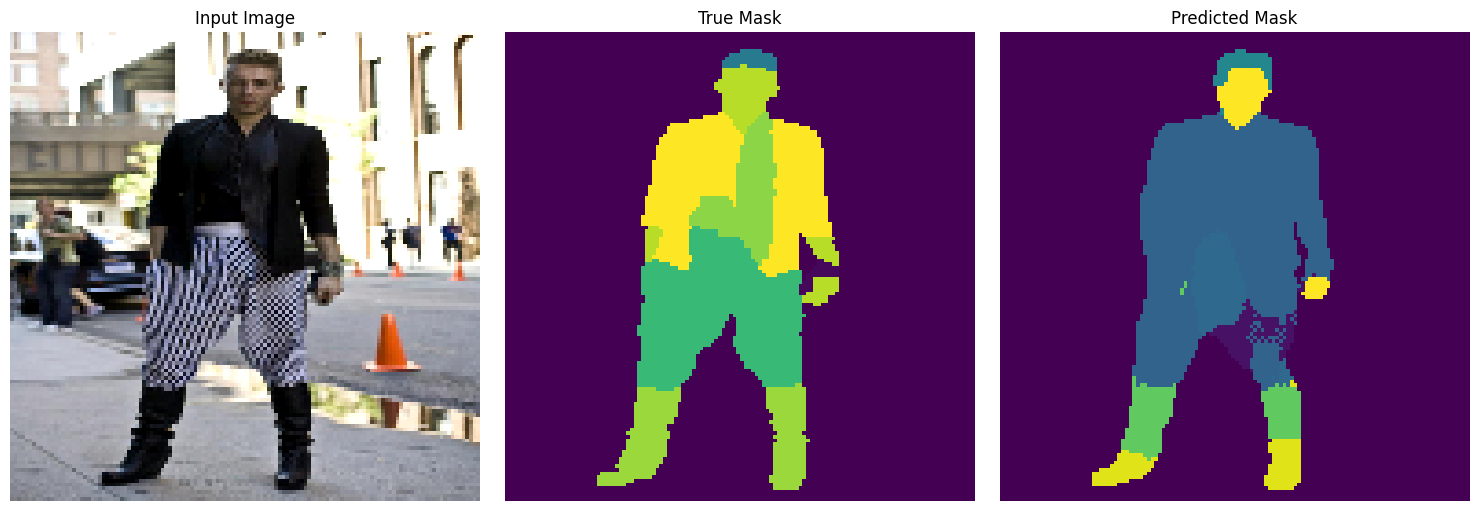

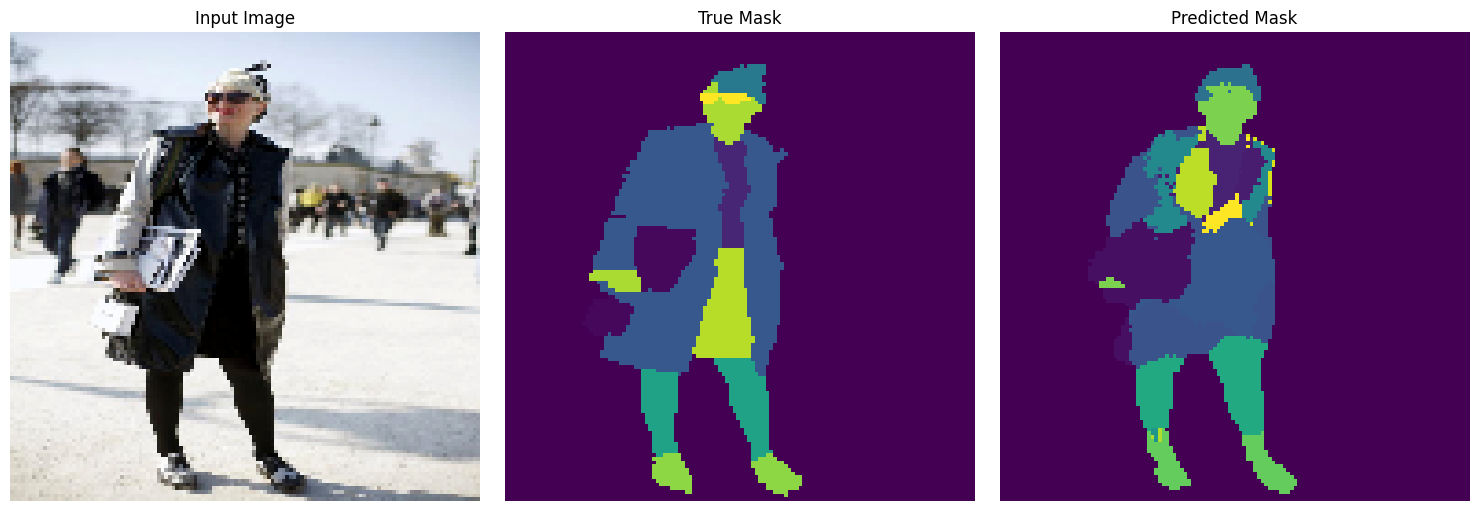

In [35]:
segment_image(dataset=val_dataset,num=10)

## GUARDAR EL MODELO

In [36]:
save_model(unet_model,'ModeloGuardado.keras')

## Prueba

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


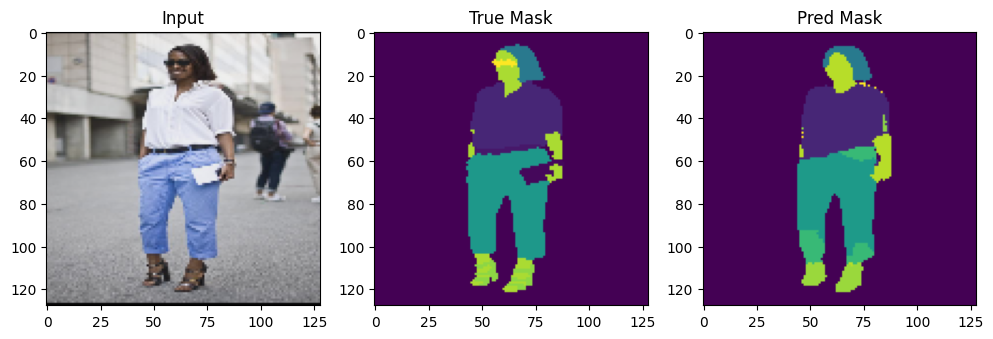

In [38]:
image, mask = next(iter(test_dataset))
pred = unet_model.predict(image)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Input"); plt.imshow(image[0])
plt.subplot(1,3,2); plt.title("True Mask"); plt.imshow(mask[0].numpy().squeeze())
plt.subplot(1,3,3); plt.title("Pred Mask"); plt.imshow(np.argmax(pred[0],axis=-1))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


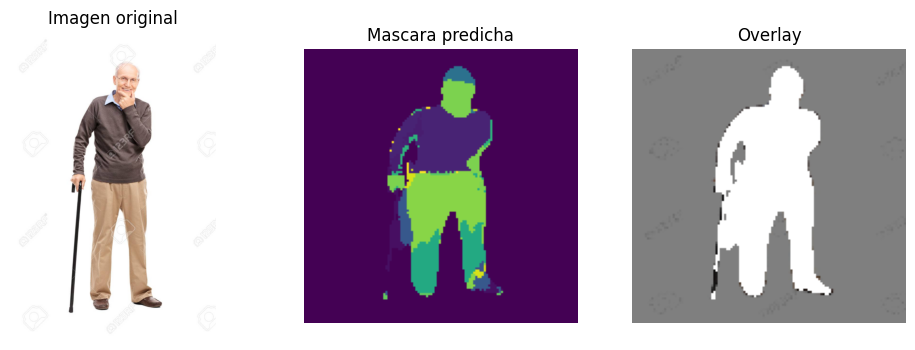

In [40]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/ProyectoIA/img_pruebas_andres/test_1.jpg'

def overlay_mask(img_array, pred_mask):
    # Crear versión RGB de la máscara
    mask_rgb = np.stack([pred_mask]*3, axis=-1)

    # Mezclar al 50%
    blended = img_array * 0.5 + mask_rgb * 0.5

    return blended


def predict_single_image(image_path):
    # Cargar imagen
    img = load_img(image_path, target_size=(128,128))
    img_array = img_to_array(img) / 255.0

    # Expandir dimensión (batch=1)
    img_batch = np.expand_dims(img_array, axis=0)

    # Predecir
    pred = unet_model.predict(img_batch)

    # Obtener máscara (argmax por pixel)
    pred_mask = np.argmax(pred[0], axis=-1)

    # Crear overlay
    overlay = overlay_mask(img_array, pred_mask)

    # Mostrar resultados
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Imagen original")
    plt.imshow(load_img(image_path))
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Mascara predicha")
    plt.imshow(pred_mask)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()


# Ejecutar
predict_single_image(image_path)
